# Lab exercises 3 - Part 1

For this lab exercises, please submit 2 notebooks / python script and 2 reports, one for each part. The deadline is 22 december.

It is important the you **read the documentation** to understand how to use Pytorch functions, what kind of transformation they apply etc. You have to **take time to read it carefully** to understand what you are doing.

- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/docs/stable/torch.html


The following libraries are necessary for this assignment.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

sns.set()

import dataset_loader

%matplotlib inline

## 1. Part one: MNIST classification with Pytorch

The goal of the first part is to learn how to use Pytorch and to observe the impact of regularization during training. You should test different network architectures, e.g. with hidden layers of size 128-128, 128-64-32-16, 256-128-64-32-16, 512-256-128-64-32-16, 800-800, and different activation functions (tanh, relu, sigmoid).

Remember that Pytorch expects data in a different format than in the previous lab exercise: the first dimension is always the batch dimension.

In [0]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [0]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [0]:
train_img = train_data[0]
train_label = train_data[1]
dev_img = dev_data[0]
dev_label = dev_data[1]
test_img = test_data[0]
test_label = test_data[1]

In [0]:
train_img[1].shape

(784,)

In [0]:
train_label

array([0, 9, 3, ..., 8, 7, 3])

In [0]:
train_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
type(train_img[0])

numpy.ndarray

### 1.2. Layer initialization

By default, Pytorch will apply Kaiming initialization to linear layers. However, I recommend you to always explicitly initialize you network by hand in the constructor.


In [0]:
class ReluMLP(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_value):
        super(ReluMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[0], layer_dims[1]))
        layers.append(nn.ReLU())
        for i in range(len(layer_dims)-2):
            layers.append(nn.Dropout(dropout_value))
            layers.append(nn.Linear(layer_dims[i+1], layer_dims[i+2]))
            layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[-1], 10))
        self.seq = nn.Sequential(*layers)
                    
    def forward(self, inputs):
        return self.seq(inputs)

In [0]:
NLLloss = nn.CrossEntropyLoss()

In [0]:
def training(model,
            train_images,
            train_labels,
            loss_function,
            optimizer,
            dev_images,
            dev_labels,
            n_epochs,
            batch_size):
    
    loss_list = []
    dev_acc_list = []

    cuda0 = torch.device('cuda:0')
            
    for epoch in range(n_epochs):
        print('Starting epoch: {}'.format(epoch))
        model.train()
        cost = 0
        
        for first in range(0, len(train_images), batch_size):
            model.zero_grad()
            
            batch_input = torch.cat(
                [
                    torch.from_numpy(image).reshape(1, -1)
                    for image in train_images[first:first + batch_size]
                    
                ],
                    dim=0
            )
            batch_labels = torch.from_numpy(train_labels[first:first + batch_size].reshape(-1, 1)).to(cuda0)
            output = model(batch_input.to(cuda0))
            # compute loss, backprop and call step()
            
            batch_labels = batch_labels.squeeze_()
            #print('labels: ', batch_labels)
            #print('output: ', output)
            
            loss = loss_function(output, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5.)
            optimizer.step()
            cost += loss.item()             
            
        mean_loss = cost / (len(train_images)/batch_size + 1)
        acc = accuracy(model, dev_images, dev_labels, batch_size)
        print('mean loss: ', mean_loss)
        print('dev accuracy: ', acc)
        
        loss_list.append(mean_loss)
        dev_acc_list.append(acc) 
    
    return model, loss_list, dev_acc_list
            
#model = ReluMLP(784, layer_dims = [128,128], dropout_value = 0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

#training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, 10, 10)

In [0]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)

In [0]:
def plot_graphs(mean_losses, 
                dev_accus, 
                dropout_value, 
                layer_dims,
                lr,
                batch_size,
                activationfunction):
    #print(mean_losses.shape)
    #print(dev_accus)
    #print(dev_accus.shape)
    #print([i for i in range(EPOCHS)].shape)
    plt.plot([i for i in range(EPOCHS)],mean_losses, label='mean loss')
    plt.plot([i for i in range(EPOCHS)],dev_accus, label='accuracy on dev')
    plt.xlabel('Epochs')
    plt.title('{} hidden layers, {} dropout, {} learning rate, {} batch_size, {} activation function'.format(layer_dims,
                                                          dropout_value, lr, batch_size, activationfunction))
    plt.legend()
    plt.savefig('{}hidden layers{}dropout{}learning rate{}batch_size{}acivationfunctoin.png'.format(layer_dims,
                                                          dropout_value, lr, batch_size, activationfunction))
    plt.show()

In [0]:
def accuracy(model, images, labels, batch_size):
    correct = 0
    total = 0
    model.eval()
    cuda0 = torch.device('cuda:0')
    for i in range(len(images)):
        #print(images[i])
        output = model(torch.from_numpy(images[i]).reshape(1, -1).to(cuda0))

        _, predicted = torch.max(output.data, 1)
        #print(batch_labels.size(0))
        total += 1
        #print(predicted)
        #print(type(predicted))
        #print(labels[i])
        #print(type(labels[i]))
        correct += (predicted == labels[i]).item()
        #print(correct.item())
    
    return correct/total

#### In order to run a more elaborate test, the cell below can be run, though I recommend saving the time and going to the cell below.

Starting epoch: 0
mean loss:  0.24178928938179833
dev accuracy:  0.9621
Starting epoch: 1
mean loss:  0.10942661766088817
dev accuracy:  0.9643
Starting epoch: 2
mean loss:  0.07611376218375906
dev accuracy:  0.9674
Starting epoch: 3
mean loss:  0.05837846595609018
dev accuracy:  0.9694
Starting epoch: 4
mean loss:  0.04769859109590812
dev accuracy:  0.9663
Starting epoch: 5
mean loss:  0.038907859100859414
dev accuracy:  0.968
Starting epoch: 6
mean loss:  0.03435795811849798
dev accuracy:  0.9696
Starting epoch: 7
mean loss:  0.030215627013260894
dev accuracy:  0.9652
Starting epoch: 8
mean loss:  0.02805878962373302
dev accuracy:  0.9717
Starting epoch: 9
mean loss:  0.026823125058972577
dev accuracy:  0.9718
Starting epoch: 10
mean loss:  0.025421246038540807
dev accuracy:  0.974
Starting epoch: 11
mean loss:  0.022270696840108652
dev accuracy:  0.9747
Starting epoch: 12
mean loss:  0.023550985244652392
dev accuracy:  0.9742
Starting epoch: 13
mean loss:  0.024384251091057883
dev a

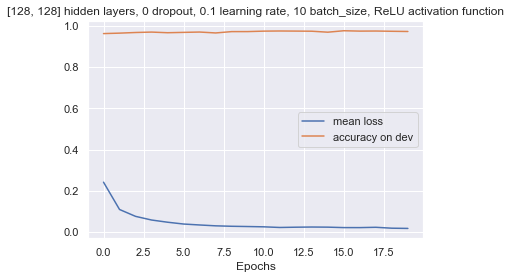

Starting epoch: 0
mean loss:  0.4014899246171563
dev accuracy:  0.9334
Starting epoch: 1
mean loss:  0.19546127735735652
dev accuracy:  0.9502
Starting epoch: 2
mean loss:  0.1448480947883781
dev accuracy:  0.9592
Starting epoch: 3
mean loss:  0.11600095270472967
dev accuracy:  0.9637
Starting epoch: 4
mean loss:  0.09613504963452944
dev accuracy:  0.9672
Starting epoch: 5
mean loss:  0.08164037443965139
dev accuracy:  0.9692
Starting epoch: 6
mean loss:  0.07018002744080004
dev accuracy:  0.9692
Starting epoch: 7
mean loss:  0.060709675651289034
dev accuracy:  0.97
Starting epoch: 8
mean loss:  0.052847227540811496
dev accuracy:  0.9708
Starting epoch: 9
mean loss:  0.0461620026957727
dev accuracy:  0.9714
Starting epoch: 10
mean loss:  0.040351172133967904
dev accuracy:  0.9729
Starting epoch: 11
mean loss:  0.03530051113810844
dev accuracy:  0.9738
Starting epoch: 12
mean loss:  0.03094061139688461
dev accuracy:  0.9745
Starting epoch: 13
mean loss:  0.027101657760446658
dev accurac

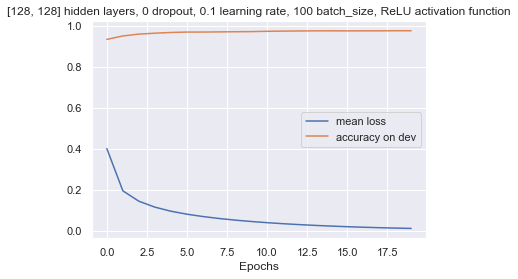

Starting epoch: 0
mean loss:  1.0188516816672157
dev accuracy:  0.8873
Starting epoch: 1
mean loss:  0.4304187180949192
dev accuracy:  0.9099
Starting epoch: 2
mean loss:  0.34830297032992047
dev accuracy:  0.9181
Starting epoch: 3
mean loss:  0.3104250393077439
dev accuracy:  0.9224
Starting epoch: 4
mean loss:  0.28536692203259933
dev accuracy:  0.9273
Starting epoch: 5
mean loss:  0.26627155583278805
dev accuracy:  0.9308
Starting epoch: 6
mean loss:  0.2506489385576809
dev accuracy:  0.934
Starting epoch: 7
mean loss:  0.23725114821218976
dev accuracy:  0.9372
Starting epoch: 8
mean loss:  0.22552588056115544
dev accuracy:  0.9394
Starting epoch: 9
mean loss:  0.21513728476038166
dev accuracy:  0.942
Starting epoch: 10
mean loss:  0.20576278018016442
dev accuracy:  0.9445
Starting epoch: 11
mean loss:  0.19717421864762025
dev accuracy:  0.9467
Starting epoch: 12
mean loss:  0.18925534188747406
dev accuracy:  0.9494
Starting epoch: 13
mean loss:  0.18191278857343338
dev accuracy:  0

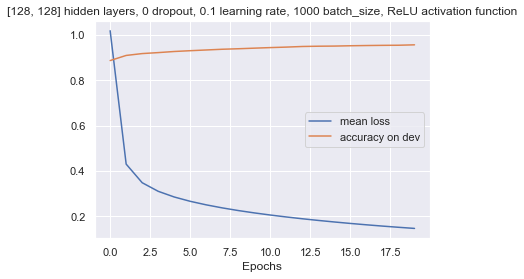

Starting epoch: 0
mean loss:  0.335619614230148
dev accuracy:  0.961
Starting epoch: 1
mean loss:  0.18981782354232857
dev accuracy:  0.9628
Starting epoch: 2
mean loss:  0.1530095461821322
dev accuracy:  0.966
Starting epoch: 3
mean loss:  0.13518623747825756
dev accuracy:  0.9679
Starting epoch: 4
mean loss:  0.11872309941801709
dev accuracy:  0.9685
Starting epoch: 5
mean loss:  0.11039631993352071
dev accuracy:  0.9712
Starting epoch: 6
mean loss:  0.10266373306175645
dev accuracy:  0.9715
Starting epoch: 7
mean loss:  0.09383761908068895
dev accuracy:  0.973
Starting epoch: 8
mean loss:  0.09245712322548019
dev accuracy:  0.9722
Starting epoch: 9
mean loss:  0.08489353499453511
dev accuracy:  0.9749
Starting epoch: 10
mean loss:  0.08298084777835545
dev accuracy:  0.9718
Starting epoch: 11
mean loss:  0.08050995666638817
dev accuracy:  0.9719
Starting epoch: 12
mean loss:  0.07765495075647133
dev accuracy:  0.9745
Starting epoch: 13
mean loss:  0.07309141498775795
dev accuracy:  0

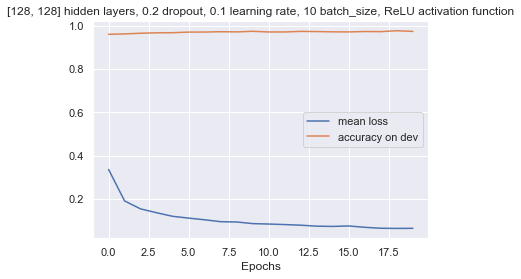

Starting epoch: 0
mean loss:  0.5168889757699358
dev accuracy:  0.938
Starting epoch: 1
mean loss:  0.2634149648234278
dev accuracy:  0.9543
Starting epoch: 2
mean loss:  0.2055779957768327
dev accuracy:  0.9626
Starting epoch: 3
mean loss:  0.1762485928134528
dev accuracy:  0.9659
Starting epoch: 4
mean loss:  0.15486122128700544
dev accuracy:  0.9673
Starting epoch: 5
mean loss:  0.13944113436721994
dev accuracy:  0.9704
Starting epoch: 6
mean loss:  0.12669722167050054
dev accuracy:  0.9699
Starting epoch: 7
mean loss:  0.11608960529688947
dev accuracy:  0.9727
Starting epoch: 8
mean loss:  0.10764895392555796
dev accuracy:  0.9748
Starting epoch: 9
mean loss:  0.10082261169147111
dev accuracy:  0.9734
Starting epoch: 10
mean loss:  0.09349798725661404
dev accuracy:  0.9748
Starting epoch: 11
mean loss:  0.08915984026991024
dev accuracy:  0.9738
Starting epoch: 12
mean loss:  0.08444309951979184
dev accuracy:  0.977
Starting epoch: 13
mean loss:  0.08097387386854002
dev accuracy:  0

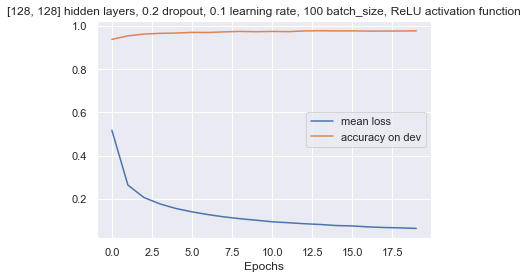

Starting epoch: 0
mean loss:  1.3021744992218764
dev accuracy:  0.8632
Starting epoch: 1
mean loss:  0.6515684899161843
dev accuracy:  0.8937
Starting epoch: 2
mean loss:  0.5133501969131768
dev accuracy:  0.9078
Starting epoch: 3
mean loss:  0.4516490136875826
dev accuracy:  0.9155
Starting epoch: 4
mean loss:  0.4069274336683984
dev accuracy:  0.9212
Starting epoch: 5
mean loss:  0.37680700538205164
dev accuracy:  0.9255
Starting epoch: 6
mean loss:  0.3593197973335491
dev accuracy:  0.9286
Starting epoch: 7
mean loss:  0.3354935441531387
dev accuracy:  0.932
Starting epoch: 8
mean loss:  0.3172348544878118
dev accuracy:  0.9369
Starting epoch: 9
mean loss:  0.3032895729822271
dev accuracy:  0.9392
Starting epoch: 10
mean loss:  0.2930465136088577
dev accuracy:  0.9405
Starting epoch: 11
mean loss:  0.27868834868365644
dev accuracy:  0.9435
Starting epoch: 12
mean loss:  0.26870544751485187
dev accuracy:  0.9457
Starting epoch: 13
mean loss:  0.26071609147623476
dev accuracy:  0.9486

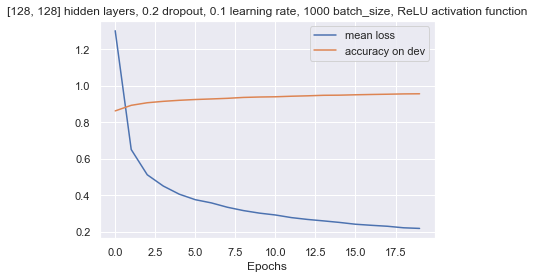

Starting epoch: 0
mean loss:  0.5041169848925331
dev accuracy:  0.9457
Starting epoch: 1
mean loss:  0.31716570076545114
dev accuracy:  0.9542
Starting epoch: 2
mean loss:  0.2745902846470221
dev accuracy:  0.9599
Starting epoch: 3
mean loss:  0.2556515264882247
dev accuracy:  0.9649
Starting epoch: 4
mean loss:  0.2313342559404785
dev accuracy:  0.9661
Starting epoch: 5
mean loss:  0.2200443253362629
dev accuracy:  0.9655
Starting epoch: 6
mean loss:  0.21525821722891533
dev accuracy:  0.9592
Starting epoch: 7
mean loss:  0.20536312167330095
dev accuracy:  0.9688
Starting epoch: 8
mean loss:  0.20386975746660538
dev accuracy:  0.9652
Starting epoch: 9
mean loss:  0.18842640132778904
dev accuracy:  0.9665
Starting epoch: 10
mean loss:  0.1866376872182346
dev accuracy:  0.9656
Starting epoch: 11
mean loss:  0.1880848364187534
dev accuracy:  0.9693
Starting epoch: 12
mean loss:  0.17995031981014636
dev accuracy:  0.9672
Starting epoch: 13
mean loss:  0.17177804467842667
dev accuracy:  0.

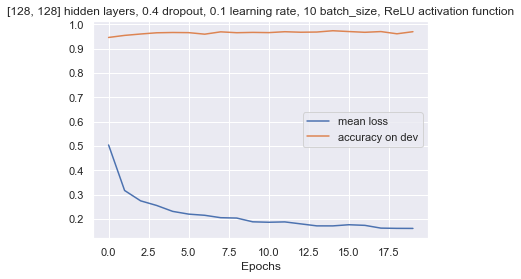

Starting epoch: 0
mean loss:  0.7095425780899748
dev accuracy:  0.9297
Starting epoch: 1
mean loss:  0.3745065286547362
dev accuracy:  0.945
Starting epoch: 2
mean loss:  0.30277161884629084
dev accuracy:  0.9544
Starting epoch: 3
mean loss:  0.2636665313722131
dev accuracy:  0.9569
Starting epoch: 4
mean loss:  0.23452433007592688
dev accuracy:  0.965
Starting epoch: 5
mean loss:  0.21261598474667695
dev accuracy:  0.9669
Starting epoch: 6
mean loss:  0.19776933754751544
dev accuracy:  0.9677
Starting epoch: 7
mean loss:  0.18531293845075572
dev accuracy:  0.9688
Starting epoch: 8
mean loss:  0.1796592590203899
dev accuracy:  0.9703
Starting epoch: 9
mean loss:  0.1652009747550635
dev accuracy:  0.9711
Starting epoch: 10
mean loss:  0.15957342006429703
dev accuracy:  0.9722
Starting epoch: 11
mean loss:  0.15481229557724532
dev accuracy:  0.9728
Starting epoch: 12
mean loss:  0.14809417601920175
dev accuracy:  0.9737
Starting epoch: 13
mean loss:  0.14577768028838312
dev accuracy:  0.

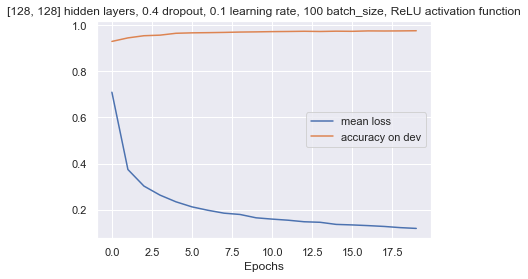

Starting epoch: 0
mean loss:  1.584588275236242
dev accuracy:  0.8386
Starting epoch: 1
mean loss:  0.8794021384388793
dev accuracy:  0.8825
Starting epoch: 2
mean loss:  0.6875688386898414
dev accuracy:  0.9024
Starting epoch: 3
mean loss:  0.5891944619954801
dev accuracy:  0.9104
Starting epoch: 4
mean loss:  0.5287221243568495
dev accuracy:  0.9162
Starting epoch: 5
mean loss:  0.48786372004770767
dev accuracy:  0.9209
Starting epoch: 6
mean loss:  0.4540608770707074
dev accuracy:  0.9248
Starting epoch: 7
mean loss:  0.4301997066712847
dev accuracy:  0.9281
Starting epoch: 8
mean loss:  0.40790654046862734
dev accuracy:  0.9304
Starting epoch: 9
mean loss:  0.39096488321528716
dev accuracy:  0.933
Starting epoch: 10
mean loss:  0.3760081506242939
dev accuracy:  0.936
Starting epoch: 11
mean loss:  0.3606399864542718
dev accuracy:  0.9381
Starting epoch: 12
mean loss:  0.3507607035777148
dev accuracy:  0.941
Starting epoch: 13
mean loss:  0.33783313632011414
dev accuracy:  0.9426
St

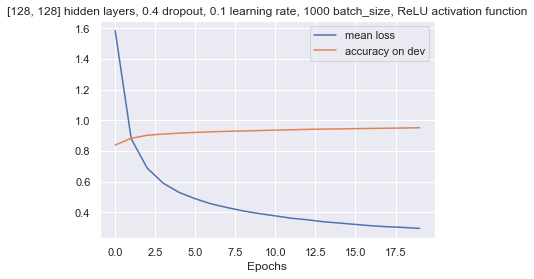

Starting epoch: 0
mean loss:  0.8947087866858459
dev accuracy:  0.9207
Starting epoch: 1
mean loss:  0.6506715959965604
dev accuracy:  0.9336
Starting epoch: 2
mean loss:  0.614512525720898
dev accuracy:  0.932
Starting epoch: 3
mean loss:  0.5823618544340404
dev accuracy:  0.9356
Starting epoch: 4
mean loss:  0.570679663939696
dev accuracy:  0.9338
Starting epoch: 5
mean loss:  0.5497361858177632
dev accuracy:  0.938
Starting epoch: 6
mean loss:  0.5460904612081802
dev accuracy:  0.9419
Starting epoch: 7
mean loss:  0.5459494711209125
dev accuracy:  0.9425
Starting epoch: 8
mean loss:  0.5258012348062387
dev accuracy:  0.9396
Starting epoch: 9
mean loss:  0.5212235821370119
dev accuracy:  0.9399
Starting epoch: 10
mean loss:  0.5129564111469186
dev accuracy:  0.9386
Starting epoch: 11
mean loss:  0.5222999867917419
dev accuracy:  0.9425
Starting epoch: 12
mean loss:  0.5082083838866455
dev accuracy:  0.9429
Starting epoch: 13
mean loss:  0.48906033564970824
dev accuracy:  0.9447
Start

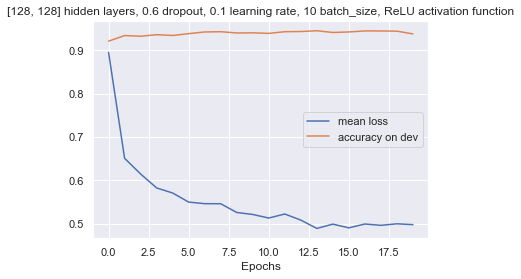

Starting epoch: 0
mean loss:  0.955804113261476
dev accuracy:  0.9197
Starting epoch: 1
mean loss:  0.5458265252693922
dev accuracy:  0.9359
Starting epoch: 2
mean loss:  0.45659593161113726
dev accuracy:  0.9431
Starting epoch: 3
mean loss:  0.40913865243841313
dev accuracy:  0.9477
Starting epoch: 4
mean loss:  0.38041276709286276
dev accuracy:  0.9525
Starting epoch: 5
mean loss:  0.35029212110294794
dev accuracy:  0.9562
Starting epoch: 6
mean loss:  0.3311667489166745
dev accuracy:  0.9592
Starting epoch: 7
mean loss:  0.31757751807659684
dev accuracy:  0.9609
Starting epoch: 8
mean loss:  0.30882695287525536
dev accuracy:  0.963
Starting epoch: 9
mean loss:  0.2961960019406206
dev accuracy:  0.9634
Starting epoch: 10
mean loss:  0.2833635928536842
dev accuracy:  0.9649
Starting epoch: 11
mean loss:  0.2769958325578067
dev accuracy:  0.9649
Starting epoch: 12
mean loss:  0.26636100434019655
dev accuracy:  0.9658
Starting epoch: 13
mean loss:  0.25926252494672103
dev accuracy:  0.9

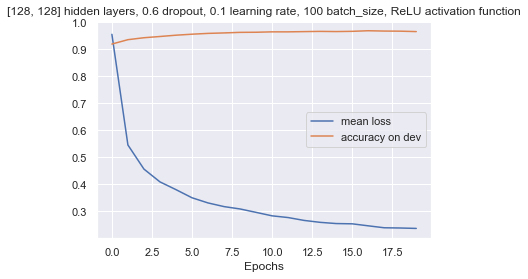

Starting epoch: 0
mean loss:  1.8943096305809768
dev accuracy:  0.7948
Starting epoch: 1
mean loss:  1.2614081724017274
dev accuracy:  0.86
Starting epoch: 2
mean loss:  0.9990443902857163
dev accuracy:  0.8812
Starting epoch: 3
mean loss:  0.8648954770144295
dev accuracy:  0.8927
Starting epoch: 4
mean loss:  0.7776388923327128
dev accuracy:  0.9011
Starting epoch: 5
mean loss:  0.7033704203717849
dev accuracy:  0.9077
Starting epoch: 6
mean loss:  0.6591917545187707
dev accuracy:  0.9122
Starting epoch: 7
mean loss:  0.6286600232124329
dev accuracy:  0.916
Starting epoch: 8
mean loss:  0.6033648182364071
dev accuracy:  0.9183
Starting epoch: 9
mean loss:  0.5682802895704905
dev accuracy:  0.9211
Starting epoch: 10
mean loss:  0.5510595727200601
dev accuracy:  0.9244
Starting epoch: 11
mean loss:  0.5350644611844829
dev accuracy:  0.9273
Starting epoch: 12
mean loss:  0.5214881534669914
dev accuracy:  0.9294
Starting epoch: 13
mean loss:  0.505032840312696
dev accuracy:  0.9308
Starti

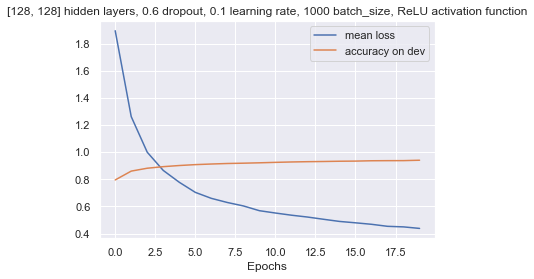

Starting epoch: 0
mean loss:  0.4007324291766733
dev accuracy:  0.9355
Starting epoch: 1
mean loss:  0.19826214412129317
dev accuracy:  0.9519
Starting epoch: 2
mean loss:  0.14775725378816634
dev accuracy:  0.9609
Starting epoch: 3
mean loss:  0.11797991799928054
dev accuracy:  0.9644
Starting epoch: 4
mean loss:  0.0974910592575365
dev accuracy:  0.9662
Starting epoch: 5
mean loss:  0.08247556734983871
dev accuracy:  0.9689
Starting epoch: 6
mean loss:  0.07080605139494699
dev accuracy:  0.9702
Starting epoch: 7
mean loss:  0.061396496561733814
dev accuracy:  0.9706
Starting epoch: 8
mean loss:  0.05350936864098917
dev accuracy:  0.9713
Starting epoch: 9
mean loss:  0.04678180049240006
dev accuracy:  0.9724
Starting epoch: 10
mean loss:  0.04086727973179792
dev accuracy:  0.9731
Starting epoch: 11
mean loss:  0.03562363692510138
dev accuracy:  0.974
Starting epoch: 12
mean loss:  0.031133624056712293
dev accuracy:  0.9745
Starting epoch: 13
mean loss:  0.027068895132279978
dev accura

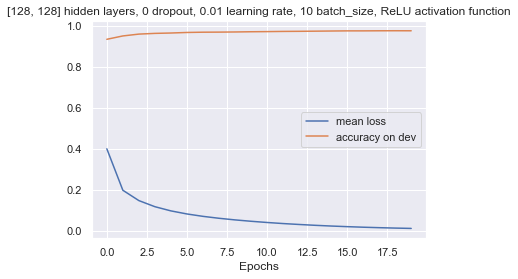

Starting epoch: 0
mean loss:  1.086724016837731
dev accuracy:  0.8779
Starting epoch: 1
mean loss:  0.43990802512078464
dev accuracy:  0.9066
Starting epoch: 2
mean loss:  0.35677976382825666
dev accuracy:  0.9164
Starting epoch: 3
mean loss:  0.31779321223616364
dev accuracy:  0.9223
Starting epoch: 4
mean loss:  0.2917334197940465
dev accuracy:  0.9258
Starting epoch: 5
mean loss:  0.27165622087176927
dev accuracy:  0.9297
Starting epoch: 6
mean loss:  0.2550386867658821
dev accuracy:  0.9341
Starting epoch: 7
mean loss:  0.2408188142462405
dev accuracy:  0.9383
Starting epoch: 8
mean loss:  0.2283943797835333
dev accuracy:  0.9407
Starting epoch: 9
mean loss:  0.21741822564197397
dev accuracy:  0.9427
Starting epoch: 10
mean loss:  0.20756883538530735
dev accuracy:  0.9455
Starting epoch: 11
mean loss:  0.19865248584283327
dev accuracy:  0.9475
Starting epoch: 12
mean loss:  0.19048825959989174
dev accuracy:  0.9502
Starting epoch: 13
mean loss:  0.1829419211073669
dev accuracy:  0.

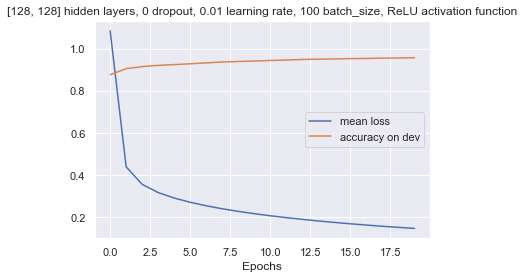

Starting epoch: 0
mean loss:  2.063289008888544
dev accuracy:  0.5186
Starting epoch: 1
mean loss:  1.6319775721606087
dev accuracy:  0.6953
Starting epoch: 2
mean loss:  1.2729069017896466
dev accuracy:  0.7753
Starting epoch: 3
mean loss:  1.0089034064143312
dev accuracy:  0.8204
Starting epoch: 4
mean loss:  0.8362585329541973
dev accuracy:  0.8436
Starting epoch: 5
mean loss:  0.7235086934239257
dev accuracy:  0.8586
Starting epoch: 6
mean loss:  0.6462182881785374
dev accuracy:  0.868
Starting epoch: 7
mean loss:  0.5903263197225683
dev accuracy:  0.8758
Starting epoch: 8
mean loss:  0.5480125780199089
dev accuracy:  0.8822
Starting epoch: 9
mean loss:  0.5148779895960116
dev accuracy:  0.8861
Starting epoch: 10
mean loss:  0.48823058371450384
dev accuracy:  0.8901
Starting epoch: 11
mean loss:  0.4662969620788799
dev accuracy:  0.8933
Starting epoch: 12
mean loss:  0.4478917022546132
dev accuracy:  0.8947
Starting epoch: 13
mean loss:  0.43221625218204424
dev accuracy:  0.8962
St

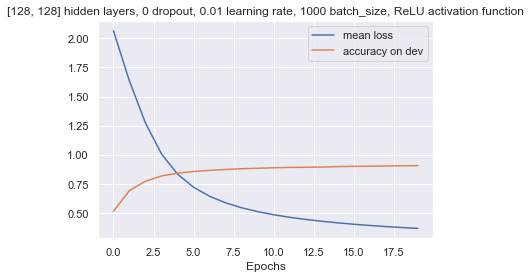

Starting epoch: 0
mean loss:  0.5270041142773033
dev accuracy:  0.9408
Starting epoch: 1
mean loss:  0.2659809817573984
dev accuracy:  0.9548
Starting epoch: 2
mean loss:  0.2057955519625758
dev accuracy:  0.9618
Starting epoch: 3
mean loss:  0.17683229398843567
dev accuracy:  0.9677
Starting epoch: 4
mean loss:  0.1528636345944446
dev accuracy:  0.97
Starting epoch: 5
mean loss:  0.13671168238331716
dev accuracy:  0.9726
Starting epoch: 6
mean loss:  0.12362719861226222
dev accuracy:  0.9742
Starting epoch: 7
mean loss:  0.11245734870423309
dev accuracy:  0.9742
Starting epoch: 8
mean loss:  0.10446043009469948
dev accuracy:  0.9766
Starting epoch: 9
mean loss:  0.0997013426351135
dev accuracy:  0.9747
Starting epoch: 10
mean loss:  0.09274894370492484
dev accuracy:  0.9755
Starting epoch: 11
mean loss:  0.08726981140077315
dev accuracy:  0.9775
Starting epoch: 12
mean loss:  0.08365482452249089
dev accuracy:  0.9773
Starting epoch: 13
mean loss:  0.07734427993972355
dev accuracy:  0.

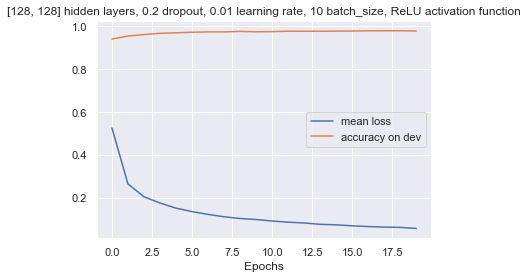

Starting epoch: 0
mean loss:  1.375687177309733
dev accuracy:  0.8613
Starting epoch: 1
mean loss:  0.6579105793953893
dev accuracy:  0.8984
Starting epoch: 2
mean loss:  0.5179660256632311
dev accuracy:  0.9093
Starting epoch: 3
mean loss:  0.45155870135196907
dev accuracy:  0.9181
Starting epoch: 4
mean loss:  0.4071445472821028
dev accuracy:  0.9233
Starting epoch: 5
mean loss:  0.37848947817337014
dev accuracy:  0.9282
Starting epoch: 6
mean loss:  0.3506827065925636
dev accuracy:  0.932
Starting epoch: 7
mean loss:  0.33087526797177547
dev accuracy:  0.9371
Starting epoch: 8
mean loss:  0.31386568859784664
dev accuracy:  0.9393
Starting epoch: 9
mean loss:  0.3014969018970183
dev accuracy:  0.9425
Starting epoch: 10
mean loss:  0.28824345279715496
dev accuracy:  0.9453
Starting epoch: 11
mean loss:  0.27477242077836495
dev accuracy:  0.9493
Starting epoch: 12
mean loss:  0.2623860745462115
dev accuracy:  0.9507
Starting epoch: 13
mean loss:  0.2551660130540292
dev accuracy:  0.952

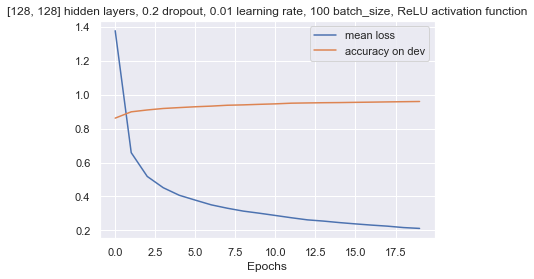

Starting epoch: 0
mean loss:  2.200150620703604
dev accuracy:  0.4815
Starting epoch: 1
mean loss:  1.8634283495884316
dev accuracy:  0.683
Starting epoch: 2
mean loss:  1.5810496900595872
dev accuracy:  0.7494
Starting epoch: 3
mean loss:  1.3407001986223108
dev accuracy:  0.7896
Starting epoch: 4
mean loss:  1.1583124539431404
dev accuracy:  0.8167
Starting epoch: 5
mean loss:  1.027596022568497
dev accuracy:  0.8387
Starting epoch: 6
mean loss:  0.9277472858335457
dev accuracy:  0.8494
Starting epoch: 7
mean loss:  0.8550400266460344
dev accuracy:  0.8601
Starting epoch: 8
mean loss:  0.7970625629612044
dev accuracy:  0.8673
Starting epoch: 9
mean loss:  0.7538728889297036
dev accuracy:  0.8734
Starting epoch: 10
mean loss:  0.7158559677647609
dev accuracy:  0.8779
Starting epoch: 11
mean loss:  0.6836246181936825
dev accuracy:  0.8811
Starting epoch: 12
mean loss:  0.6568955463521621
dev accuracy:  0.8861
Starting epoch: 13
mean loss:  0.6346154995993072
dev accuracy:  0.8893
Start

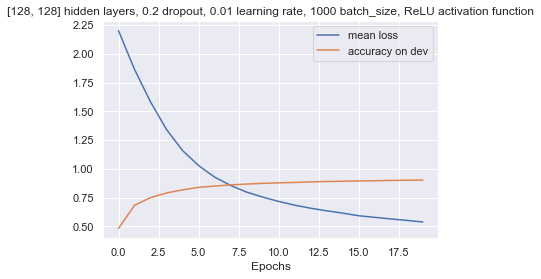

Starting epoch: 0
mean loss:  0.6757202384584852
dev accuracy:  0.9314
Starting epoch: 1
mean loss:  0.3638363093101613
dev accuracy:  0.9461
Starting epoch: 2
mean loss:  0.30015816613949386
dev accuracy:  0.9548
Starting epoch: 3
mean loss:  0.25949532404417475
dev accuracy:  0.9605
Starting epoch: 4
mean loss:  0.23219366947220538
dev accuracy:  0.9624
Starting epoch: 5
mean loss:  0.21669144947564598
dev accuracy:  0.9656
Starting epoch: 6
mean loss:  0.1977483188949645
dev accuracy:  0.968
Starting epoch: 7
mean loss:  0.18880703340054208
dev accuracy:  0.9697
Starting epoch: 8
mean loss:  0.17814072916241303
dev accuracy:  0.9708
Starting epoch: 9
mean loss:  0.16714762921609977
dev accuracy:  0.9712
Starting epoch: 10
mean loss:  0.16211869403765772
dev accuracy:  0.9708
Starting epoch: 11
mean loss:  0.15207783489512763
dev accuracy:  0.9724
Starting epoch: 12
mean loss:  0.15043359489534858
dev accuracy:  0.9736
Starting epoch: 13
mean loss:  0.14172039806285264
dev accuracy: 

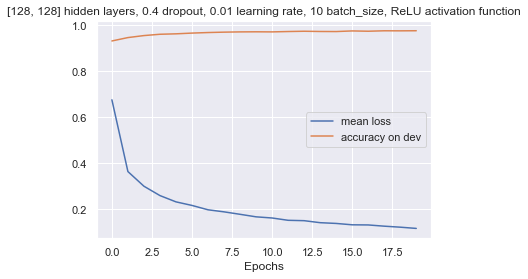

Starting epoch: 0
mean loss:  1.54535012544986
dev accuracy:  0.8507
Starting epoch: 1
mean loss:  0.8684740181930527
dev accuracy:  0.8926
Starting epoch: 2
mean loss:  0.6769361412691737
dev accuracy:  0.9068
Starting epoch: 3
mean loss:  0.5827869087636114
dev accuracy:  0.9132
Starting epoch: 4
mean loss:  0.5286445765200252
dev accuracy:  0.9188
Starting epoch: 5
mean loss:  0.48809271009858257
dev accuracy:  0.9222
Starting epoch: 6
mean loss:  0.4600401708108936
dev accuracy:  0.9262
Starting epoch: 7
mean loss:  0.4365467330414854
dev accuracy:  0.9291
Starting epoch: 8
mean loss:  0.4180498537784089
dev accuracy:  0.9319
Starting epoch: 9
mean loss:  0.3988291669986443
dev accuracy:  0.9339
Starting epoch: 10
mean loss:  0.38555236473054944
dev accuracy:  0.9382
Starting epoch: 11
mean loss:  0.3706714496641102
dev accuracy:  0.9397
Starting epoch: 12
mean loss:  0.35844142006304924
dev accuracy:  0.942
Starting epoch: 13
mean loss:  0.34878014715131883
dev accuracy:  0.9443
S

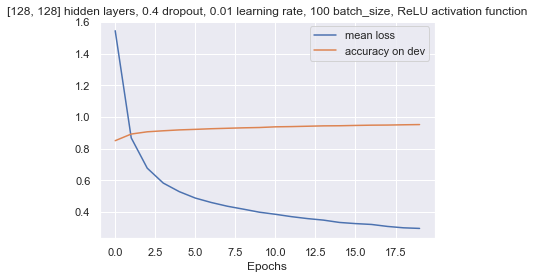

Starting epoch: 0
mean loss:  2.3060702716602997
dev accuracy:  0.4492
Starting epoch: 1
mean loss:  2.0285811307383517
dev accuracy:  0.6073
Starting epoch: 2
mean loss:  1.8427165816811955
dev accuracy:  0.6822
Starting epoch: 3
mean loss:  1.6721056232265397
dev accuracy:  0.7275
Starting epoch: 4
mean loss:  1.5289404205247468
dev accuracy:  0.758
Starting epoch: 5
mean loss:  1.4019045572654873
dev accuracy:  0.7836
Starting epoch: 6
mean loss:  1.2989327673818551
dev accuracy:  0.8018
Starting epoch: 7
mean loss:  1.2112184085097968
dev accuracy:  0.815
Starting epoch: 8
mean loss:  1.1398071658377553
dev accuracy:  0.8256
Starting epoch: 9
mean loss:  1.0719468242981856
dev accuracy:  0.8332
Starting epoch: 10
mean loss:  1.0223382828282375
dev accuracy:  0.8423
Starting epoch: 11
mean loss:  0.980875734020682
dev accuracy:  0.8502
Starting epoch: 12
mean loss:  0.9390651747292164
dev accuracy:  0.8553
Starting epoch: 13
mean loss:  0.9040254296041003
dev accuracy:  0.8606
Start

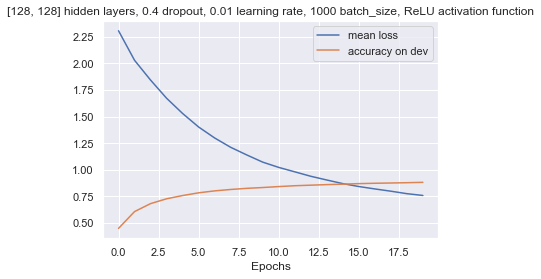

Starting epoch: 0
mean loss:  0.9785765702747757
dev accuracy:  0.9172
Starting epoch: 1
mean loss:  0.5498782545259236
dev accuracy:  0.9304
Starting epoch: 2
mean loss:  0.4590928934172237
dev accuracy:  0.9443
Starting epoch: 3
mean loss:  0.41125951470910366
dev accuracy:  0.9473
Starting epoch: 4
mean loss:  0.3767810174516538
dev accuracy:  0.954
Starting epoch: 5
mean loss:  0.34867051835140916
dev accuracy:  0.9537
Starting epoch: 6
mean loss:  0.3307843320616878
dev accuracy:  0.958
Starting epoch: 7
mean loss:  0.31192702047160525
dev accuracy:  0.9613
Starting epoch: 8
mean loss:  0.30499716181213243
dev accuracy:  0.9608
Starting epoch: 9
mean loss:  0.29796229573024424
dev accuracy:  0.9632
Starting epoch: 10
mean loss:  0.2803590427163474
dev accuracy:  0.9641
Starting epoch: 11
mean loss:  0.27837558330336853
dev accuracy:  0.965
Starting epoch: 12
mean loss:  0.2666254126013243
dev accuracy:  0.9657
Starting epoch: 13
mean loss:  0.261241310557562
dev accuracy:  0.9669


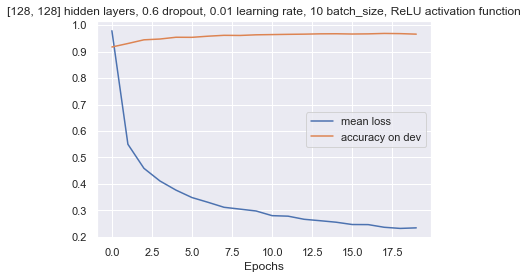

Starting epoch: 0
mean loss:  1.8954204328045874
dev accuracy:  0.7863
Starting epoch: 1
mean loss:  1.2633525076026688
dev accuracy:  0.8599
Starting epoch: 2
mean loss:  1.0027781220491299
dev accuracy:  0.8867
Starting epoch: 3
mean loss:  0.8627782099975083
dev accuracy:  0.8989
Starting epoch: 4
mean loss:  0.7804497965200694
dev accuracy:  0.904
Starting epoch: 5
mean loss:  0.7139366752135301
dev accuracy:  0.9106
Starting epoch: 6
mean loss:  0.6618019765365624
dev accuracy:  0.9142
Starting epoch: 7
mean loss:  0.630797671165295
dev accuracy:  0.9178
Starting epoch: 8
mean loss:  0.6050410885177925
dev accuracy:  0.9201
Starting epoch: 9
mean loss:  0.57549901577289
dev accuracy:  0.9225
Starting epoch: 10
mean loss:  0.5582124520680624
dev accuracy:  0.9236
Starting epoch: 11
mean loss:  0.5430190516208222
dev accuracy:  0.927
Starting epoch: 12
mean loss:  0.524515785321504
dev accuracy:  0.9282
Starting epoch: 13
mean loss:  0.5080834326153981
dev accuracy:  0.93
Starting e

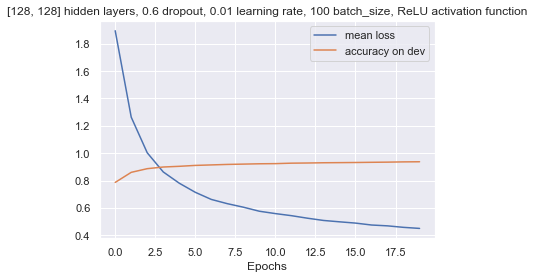

Starting epoch: 0
mean loss:  2.416721348669015
dev accuracy:  0.3379
Starting epoch: 1
mean loss:  2.166202222599703
dev accuracy:  0.5229
Starting epoch: 2
mean loss:  2.0523165113785686
dev accuracy:  0.5969
Starting epoch: 3
mean loss:  1.9586123555314308
dev accuracy:  0.6335
Starting epoch: 4
mean loss:  1.870825769854527
dev accuracy:  0.6703
Starting epoch: 5
mean loss:  1.781982005811205
dev accuracy:  0.6972
Starting epoch: 6
mean loss:  1.7029196655049044
dev accuracy:  0.7231
Starting epoch: 7
mean loss:  1.6290248375312955
dev accuracy:  0.7458
Starting epoch: 8
mean loss:  1.5564474755642461
dev accuracy:  0.7663
Starting epoch: 9
mean loss:  1.4925669969296922
dev accuracy:  0.7838
Starting epoch: 10
mean loss:  1.4400237120834052
dev accuracy:  0.7965
Starting epoch: 11
mean loss:  1.3854526281356812
dev accuracy:  0.8046
Starting epoch: 12
mean loss:  1.3400759790457932
dev accuracy:  0.817
Starting epoch: 13
mean loss:  1.2960312623603671
dev accuracy:  0.8241
Startin

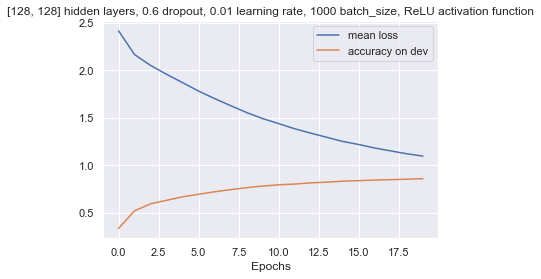

Starting epoch: 0
mean loss:  1.0319668080875979
dev accuracy:  0.8838
Starting epoch: 1
mean loss:  0.4304476424029674
dev accuracy:  0.9062
Starting epoch: 2
mean loss:  0.34995941910147815
dev accuracy:  0.9162
Starting epoch: 3
mean loss:  0.311737616820951
dev accuracy:  0.9238
Starting epoch: 4
mean loss:  0.28587680533334653
dev accuracy:  0.9293
Starting epoch: 5
mean loss:  0.26588801343645396
dev accuracy:  0.9336
Starting epoch: 6
mean loss:  0.24945466215881487
dev accuracy:  0.937
Starting epoch: 7
mean loss:  0.23551322663574592
dev accuracy:  0.9411
Starting epoch: 8
mean loss:  0.22342187456565582
dev accuracy:  0.9436
Starting epoch: 9
mean loss:  0.2127453250485258
dev accuracy:  0.9457
Starting epoch: 10
mean loss:  0.2031671160939035
dev accuracy:  0.9475
Starting epoch: 11
mean loss:  0.1944621283359121
dev accuracy:  0.9499
Starting epoch: 12
mean loss:  0.18655749359588056
dev accuracy:  0.9515
Starting epoch: 13
mean loss:  0.17927453510136038
dev accuracy:  0.9

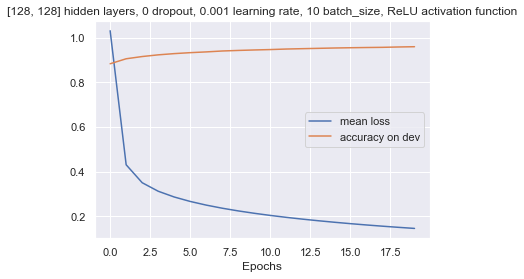

Starting epoch: 0
mean loss:  2.173245454738716
dev accuracy:  0.4637
Starting epoch: 1
mean loss:  1.7855412034455411
dev accuracy:  0.6683
Starting epoch: 2
mean loss:  1.4152981975597299
dev accuracy:  0.7504
Starting epoch: 3
mean loss:  1.1168223831230057
dev accuracy:  0.7968
Starting epoch: 4
mean loss:  0.9136359143161964
dev accuracy:  0.8244
Starting epoch: 5
mean loss:  0.7799102081034236
dev accuracy:  0.8435
Starting epoch: 6
mean loss:  0.6887718417092473
dev accuracy:  0.8585
Starting epoch: 7
mean loss:  0.62354744640653
dev accuracy:  0.8673
Starting epoch: 8
mean loss:  0.5747690210918228
dev accuracy:  0.8748
Starting epoch: 9
mean loss:  0.5369607472491121
dev accuracy:  0.8791
Starting epoch: 10
mean loss:  0.5068745893275667
dev accuracy:  0.8842
Starting epoch: 11
mean loss:  0.48238194738319534
dev accuracy:  0.8889
Starting epoch: 12
mean loss:  0.46207276016414284
dev accuracy:  0.8934
Starting epoch: 13
mean loss:  0.4449496318599183
dev accuracy:  0.896
Star

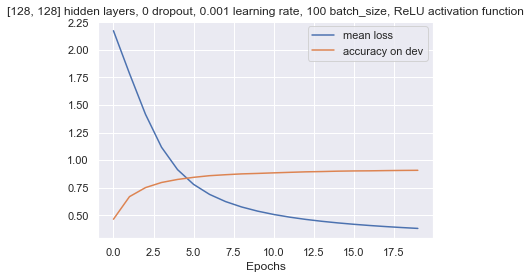

Starting epoch: 0
mean loss:  2.346194440243291
dev accuracy:  0.0821
Starting epoch: 1
mean loss:  2.2996210116966096
dev accuracy:  0.1037
Starting epoch: 2
mean loss:  2.2572891478445016
dev accuracy:  0.1308
Starting epoch: 3
mean loss:  2.217927984162873
dev accuracy:  0.1691
Starting epoch: 4
mean loss:  2.180674478119495
dev accuracy:  0.2146
Starting epoch: 5
mean loss:  2.144858533260869
dev accuracy:  0.2629
Starting epoch: 6
mean loss:  2.109953071556839
dev accuracy:  0.3048
Starting epoch: 7
mean loss:  2.0756044107324936
dev accuracy:  0.3424
Starting epoch: 8
mean loss:  2.041555030673158
dev accuracy:  0.3742
Starting epoch: 9
mean loss:  2.0076256780063404
dev accuracy:  0.4063
Starting epoch: 10
mean loss:  1.9736816415599747
dev accuracy:  0.4369
Starting epoch: 11
mean loss:  1.9396322848750096
dev accuracy:  0.4668
Starting epoch: 12
mean loss:  1.905407050076653
dev accuracy:  0.4943
Starting epoch: 13
mean loss:  1.8709808214038026
dev accuracy:  0.5182
Starting 

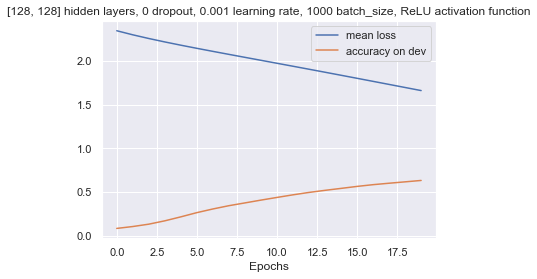

Starting epoch: 0
mean loss:  1.2149745816410695
dev accuracy:  0.8769
Starting epoch: 1
mean loss:  0.6095431597009108
dev accuracy:  0.9012
Starting epoch: 2
mean loss:  0.4944085682492939
dev accuracy:  0.9137
Starting epoch: 3
mean loss:  0.43577073219030577
dev accuracy:  0.9203
Starting epoch: 4
mean loss:  0.3981569189402496
dev accuracy:  0.9258
Starting epoch: 5
mean loss:  0.3706347289527015
dev accuracy:  0.9312
Starting epoch: 6
mean loss:  0.34449693185817903
dev accuracy:  0.9337
Starting epoch: 7
mean loss:  0.3264722890343306
dev accuracy:  0.9363
Starting epoch: 8
mean loss:  0.3097608538037786
dev accuracy:  0.9389
Starting epoch: 9
mean loss:  0.2979294098678092
dev accuracy:  0.9419
Starting epoch: 10
mean loss:  0.2843329077808142
dev accuracy:  0.9435
Starting epoch: 11
mean loss:  0.2730065005771083
dev accuracy:  0.9462
Starting epoch: 12
mean loss:  0.2629115304045924
dev accuracy:  0.9489
Starting epoch: 13
mean loss:  0.25157853746689873
dev accuracy:  0.9503

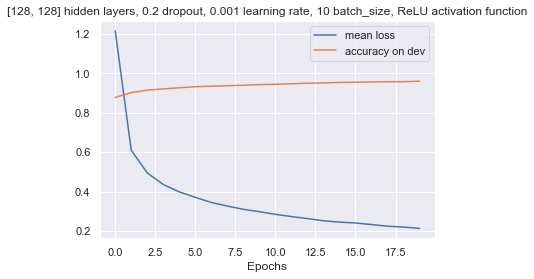

Starting epoch: 0
mean loss:  2.2759220576333905
dev accuracy:  0.3758
Starting epoch: 1
mean loss:  1.9855691356335334
dev accuracy:  0.6059
Starting epoch: 2
mean loss:  1.7297903542033213
dev accuracy:  0.6993
Starting epoch: 3
mean loss:  1.4893821432680903
dev accuracy:  0.7542
Starting epoch: 4
mean loss:  1.2970512203589646
dev accuracy:  0.7849
Starting epoch: 5
mean loss:  1.1517149826247772
dev accuracy:  0.8113
Starting epoch: 6
mean loss:  1.0431585855588703
dev accuracy:  0.8306
Starting epoch: 7
mean loss:  0.956826354572159
dev accuracy:  0.8454
Starting epoch: 8
mean loss:  0.8922548698569962
dev accuracy:  0.856
Starting epoch: 9
mean loss:  0.8386584677382144
dev accuracy:  0.8632
Starting epoch: 10
mean loss:  0.7895563750447865
dev accuracy:  0.8702
Starting epoch: 11
mean loss:  0.7469076828328435
dev accuracy:  0.8756
Starting epoch: 12
mean loss:  0.7180926187071733
dev accuracy:  0.881
Starting epoch: 13
mean loss:  0.6889266633463953
dev accuracy:  0.8849
Start

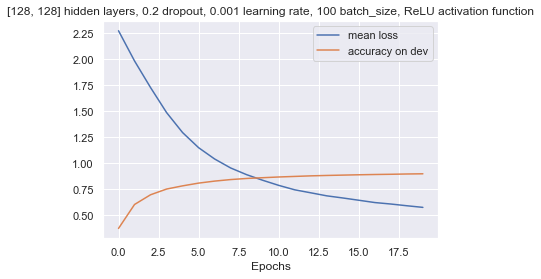

Starting epoch: 0
mean loss:  2.3647864986868465
dev accuracy:  0.1212
Starting epoch: 1
mean loss:  2.3034258777020025
dev accuracy:  0.1407
Starting epoch: 2
mean loss:  2.2567716953801176
dev accuracy:  0.1731
Starting epoch: 3
mean loss:  2.2161846815371047
dev accuracy:  0.2153
Starting epoch: 4
mean loss:  2.181457271762923
dev accuracy:  0.2607
Starting epoch: 5
mean loss:  2.1486018451989866
dev accuracy:  0.3069
Starting epoch: 6
mean loss:  2.1149500678567326
dev accuracy:  0.3522
Starting epoch: 7
mean loss:  2.0865347104914047
dev accuracy:  0.3928
Starting epoch: 8
mean loss:  2.055383990792667
dev accuracy:  0.4287
Starting epoch: 9
mean loss:  2.027141075508267
dev accuracy:  0.4585
Starting epoch: 10
mean loss:  2.0021871491974474
dev accuracy:  0.4864
Starting epoch: 11
mean loss:  1.971964960004769
dev accuracy:  0.5072
Starting epoch: 12
mean loss:  1.944211057588166
dev accuracy:  0.5277
Starting epoch: 13
mean loss:  1.9168482341018378
dev accuracy:  0.5452
Startin

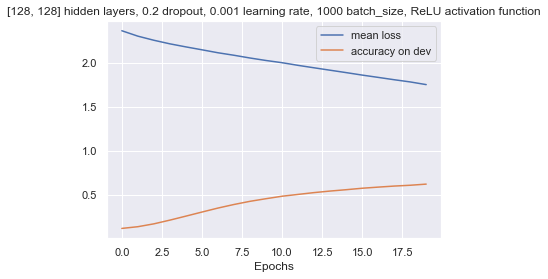

Starting epoch: 0
mean loss:  1.5523885825626185
dev accuracy:  0.8506
Starting epoch: 1
mean loss:  0.8668232080197958
dev accuracy:  0.8911
Starting epoch: 2
mean loss:  0.6875797415767114
dev accuracy:  0.9049
Starting epoch: 3
mean loss:  0.589208730790519
dev accuracy:  0.9158
Starting epoch: 4
mean loss:  0.5301292241729574
dev accuracy:  0.9205
Starting epoch: 5
mean loss:  0.4972892908859529
dev accuracy:  0.9254
Starting epoch: 6
mean loss:  0.465949798859857
dev accuracy:  0.9284
Starting epoch: 7
mean loss:  0.43516742726208757
dev accuracy:  0.9322
Starting epoch: 8
mean loss:  0.41693943761843333
dev accuracy:  0.9338
Starting epoch: 9
mean loss:  0.3978625953585204
dev accuracy:  0.9364
Starting epoch: 10
mean loss:  0.38105893531064466
dev accuracy:  0.9382
Starting epoch: 11
mean loss:  0.3677968136903656
dev accuracy:  0.9398
Starting epoch: 12
mean loss:  0.3552135638641244
dev accuracy:  0.9418
Starting epoch: 13
mean loss:  0.34510204200604006
dev accuracy:  0.9433


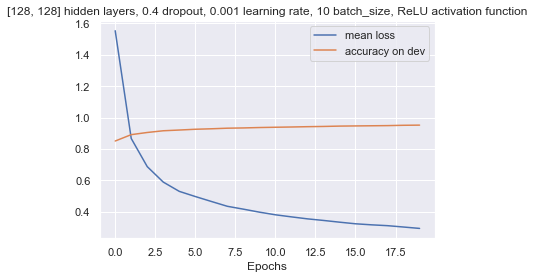

Starting epoch: 0
mean loss:  2.3102314481716193
dev accuracy:  0.4016
Starting epoch: 1
mean loss:  2.0833023650917464
dev accuracy:  0.5946
Starting epoch: 2
mean loss:  1.8926994222366882
dev accuracy:  0.6888
Starting epoch: 3
mean loss:  1.7115542181951557
dev accuracy:  0.7457
Starting epoch: 4
mean loss:  1.5590585215600903
dev accuracy:  0.7816
Starting epoch: 5
mean loss:  1.4196514210063302
dev accuracy:  0.8007
Starting epoch: 6
mean loss:  1.316197247086409
dev accuracy:  0.8165
Starting epoch: 7
mean loss:  1.2195307423254687
dev accuracy:  0.83
Starting epoch: 8
mean loss:  1.1455168608657853
dev accuracy:  0.8386
Starting epoch: 9
mean loss:  1.0812610394940405
dev accuracy:  0.8483
Starting epoch: 10
mean loss:  1.0307039237783817
dev accuracy:  0.8563
Starting epoch: 11
mean loss:  0.9823737096881676
dev accuracy:  0.862
Starting epoch: 12
mean loss:  0.9454127144432829
dev accuracy:  0.868
Starting epoch: 13
mean loss:  0.9073197341964631
dev accuracy:  0.8719
Startin

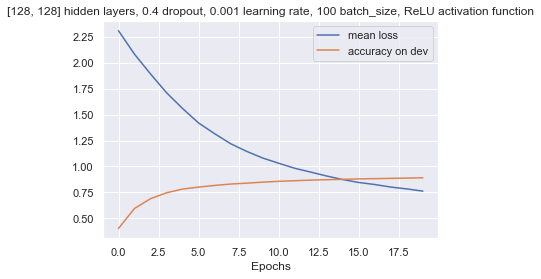

Starting epoch: 0
mean loss:  2.49107689483493
dev accuracy:  0.1438
Starting epoch: 1
mean loss:  2.4060740096896303
dev accuracy:  0.1766
Starting epoch: 2
mean loss:  2.3458549742605173
dev accuracy:  0.2091
Starting epoch: 3
mean loss:  2.3018163886724734
dev accuracy:  0.2463
Starting epoch: 4
mean loss:  2.2605422197603713
dev accuracy:  0.2788
Starting epoch: 5
mean loss:  2.2246912974937287
dev accuracy:  0.3101
Starting epoch: 6
mean loss:  2.199054531022614
dev accuracy:  0.3365
Starting epoch: 7
mean loss:  2.1714854988397336
dev accuracy:  0.357
Starting epoch: 8
mean loss:  2.148085739098343
dev accuracy:  0.3842
Starting epoch: 9
mean loss:  2.123590679729686
dev accuracy:  0.4109
Starting epoch: 10
mean loss:  2.103849270764519
dev accuracy:  0.4347
Starting epoch: 11
mean loss:  2.083148858126472
dev accuracy:  0.4621
Starting epoch: 12
mean loss:  2.0624767892500935
dev accuracy:  0.487
Starting epoch: 13
mean loss:  2.0455001382266773
dev accuracy:  0.507
Starting epo

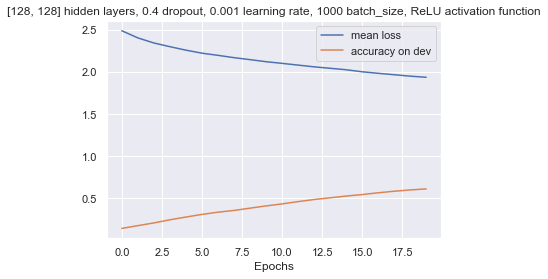

Starting epoch: 0
mean loss:  1.9267265513834297
dev accuracy:  0.804
Starting epoch: 1
mean loss:  1.2598941753659576
dev accuracy:  0.8674
Starting epoch: 2
mean loss:  0.9855256370426869
dev accuracy:  0.8871
Starting epoch: 3
mean loss:  0.8491049640624077
dev accuracy:  0.8993
Starting epoch: 4
mean loss:  0.765234602957523
dev accuracy:  0.9054
Starting epoch: 5
mean loss:  0.6978132994947934
dev accuracy:  0.9107
Starting epoch: 6
mean loss:  0.6562521681345967
dev accuracy:  0.9155
Starting epoch: 7
mean loss:  0.6213126871325158
dev accuracy:  0.9178
Starting epoch: 8
mean loss:  0.5976637312999024
dev accuracy:  0.9206
Starting epoch: 9
mean loss:  0.5721092130575411
dev accuracy:  0.922
Starting epoch: 10
mean loss:  0.5466329110043272
dev accuracy:  0.9243
Starting epoch: 11
mean loss:  0.531430243276666
dev accuracy:  0.9271
Starting epoch: 12
mean loss:  0.5213733600254024
dev accuracy:  0.9276
Starting epoch: 13
mean loss:  0.4983433293254286
dev accuracy:  0.9287
Starti

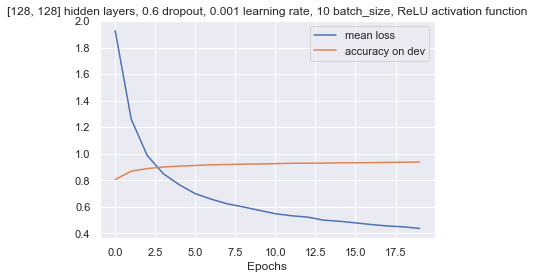

Starting epoch: 0
mean loss:  2.4535245481365453
dev accuracy:  0.367
Starting epoch: 1
mean loss:  2.202342633477704
dev accuracy:  0.5274
Starting epoch: 2
mean loss:  2.0755444505733407
dev accuracy:  0.6026
Starting epoch: 3
mean loss:  1.9654489924569805
dev accuracy:  0.6433
Starting epoch: 4
mean loss:  1.8639241573577394
dev accuracy:  0.687
Starting epoch: 5
mean loss:  1.7789193717781417
dev accuracy:  0.7259
Starting epoch: 6
mean loss:  1.690494942569923
dev accuracy:  0.7575
Starting epoch: 7
mean loss:  1.606978641060774
dev accuracy:  0.7772
Starting epoch: 8
mean loss:  1.5422004996659513
dev accuracy:  0.7935
Starting epoch: 9
mean loss:  1.4779175581808337
dev accuracy:  0.8065
Starting epoch: 10
mean loss:  1.4240952594551497
dev accuracy:  0.8172
Starting epoch: 11
mean loss:  1.381558588878837
dev accuracy:  0.8246
Starting epoch: 12
mean loss:  1.3326245427369596
dev accuracy:  0.8332
Starting epoch: 13
mean loss:  1.2927171848491281
dev accuracy:  0.8396
Starting

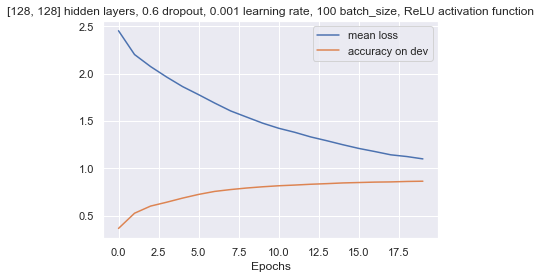

Starting epoch: 0
mean loss:  2.713698200151032
dev accuracy:  0.1146
Starting epoch: 1
mean loss:  2.589765127967386
dev accuracy:  0.1297
Starting epoch: 2
mean loss:  2.516746577094583
dev accuracy:  0.1562
Starting epoch: 3
mean loss:  2.460455450357175
dev accuracy:  0.1848
Starting epoch: 4
mean loss:  2.4183222546296963
dev accuracy:  0.2147
Starting epoch: 5
mean loss:  2.3865315119425454
dev accuracy:  0.2425
Starting epoch: 6
mean loss:  2.3561878297843184
dev accuracy:  0.2704
Starting epoch: 7
mean loss:  2.3297249289119946
dev accuracy:  0.2976
Starting epoch: 8
mean loss:  2.3077402722601796
dev accuracy:  0.3234
Starting epoch: 9
mean loss:  2.286103795556461
dev accuracy:  0.3448
Starting epoch: 10
mean loss:  2.2716958663042854
dev accuracy:  0.3674
Starting epoch: 11
mean loss:  2.252931823917464
dev accuracy:  0.3861
Starting epoch: 12
mean loss:  2.237376156975241
dev accuracy:  0.4072
Starting epoch: 13
mean loss:  2.22879966100057
dev accuracy:  0.4241
Starting ep

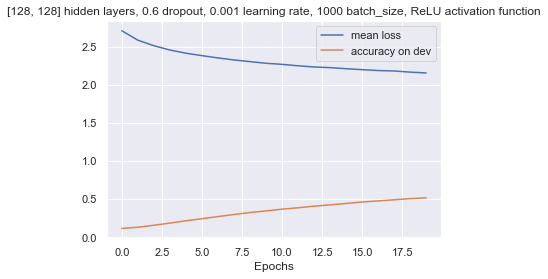

Starting epoch: 0
mean loss:  2.1651112975132176
dev accuracy:  0.4646
Starting epoch: 1
mean loss:  1.7334044445183152
dev accuracy:  0.6801
Starting epoch: 2
mean loss:  1.355517664305617
dev accuracy:  0.7571
Starting epoch: 3
mean loss:  1.0777179929845884
dev accuracy:  0.7999
Starting epoch: 4
mean loss:  0.8935452559856719
dev accuracy:  0.8255
Starting epoch: 5
mean loss:  0.7707094672834175
dev accuracy:  0.8454
Starting epoch: 6
mean loss:  0.6852267047293876
dev accuracy:  0.858
Starting epoch: 7
mean loss:  0.6231147823209072
dev accuracy:  0.8688
Starting epoch: 8
mean loss:  0.5762737970028227
dev accuracy:  0.8757
Starting epoch: 9
mean loss:  0.5398629855955274
dev accuracy:  0.881
Starting epoch: 10
mean loss:  0.5108517629355699
dev accuracy:  0.8852
Starting epoch: 11
mean loss:  0.48719482950402887
dev accuracy:  0.8885
Starting epoch: 12
mean loss:  0.4675361478231569
dev accuracy:  0.8916
Starting epoch: 13
mean loss:  0.450915227773201
dev accuracy:  0.8944
Start

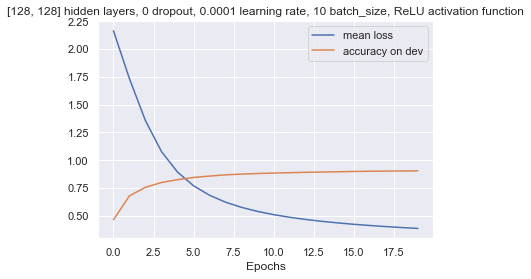

Starting epoch: 0
mean loss:  2.3534040094135764
dev accuracy:  0.1566
Starting epoch: 1
mean loss:  2.294987408224932
dev accuracy:  0.1886
Starting epoch: 2
mean loss:  2.246850362556899
dev accuracy:  0.2233
Starting epoch: 3
mean loss:  2.2042974236006745
dev accuracy:  0.2545
Starting epoch: 4
mean loss:  2.164928394401383
dev accuracy:  0.2929
Starting epoch: 5
mean loss:  2.12735399324261
dev accuracy:  0.3298
Starting epoch: 6
mean loss:  2.0907814997636867
dev accuracy:  0.3664
Starting epoch: 7
mean loss:  2.0546830342915245
dev accuracy:  0.4073
Starting epoch: 8
mean loss:  2.0186892314823326
dev accuracy:  0.4454
Starting epoch: 9
mean loss:  1.9825695612711345
dev accuracy:  0.48
Starting epoch: 10
mean loss:  1.9461899591301253
dev accuracy:  0.5088
Starting epoch: 11
mean loss:  1.9094739790686115
dev accuracy:  0.5356
Starting epoch: 12
mean loss:  1.8723557661631387
dev accuracy:  0.5562
Starting epoch: 13
mean loss:  1.8348766394004137
dev accuracy:  0.5768
Starting 

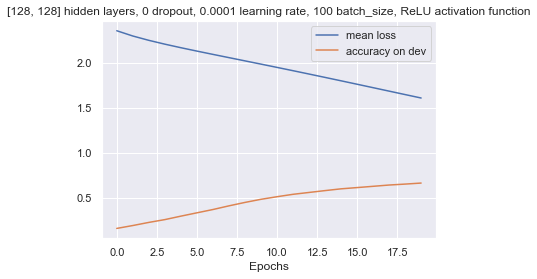

Starting epoch: 0
mean loss:  2.395509813346115
dev accuracy:  0.1098
Starting epoch: 1
mean loss:  2.386916394327201
dev accuracy:  0.1129
Starting epoch: 2
mean loss:  2.37855751841676
dev accuracy:  0.1163
Starting epoch: 3
mean loss:  2.3704130462571684
dev accuracy:  0.1189
Starting epoch: 4
mean loss:  2.3624756897197052
dev accuracy:  0.1231
Starting epoch: 5
mean loss:  2.3547388338575175
dev accuracy:  0.127
Starting epoch: 6
mean loss:  2.3471923435435578
dev accuracy:  0.1302
Starting epoch: 7
mean loss:  2.339821404101802
dev accuracy:  0.1344
Starting epoch: 8
mean loss:  2.3326176895814785
dev accuracy:  0.1379
Starting epoch: 9
mean loss:  2.32557040569829
dev accuracy:  0.1422
Starting epoch: 10
mean loss:  2.3186698053397383
dev accuracy:  0.146
Starting epoch: 11
mean loss:  2.311908852820303
dev accuracy:  0.1491
Starting epoch: 12
mean loss:  2.3052808911192653
dev accuracy:  0.153
Starting epoch: 13
mean loss:  2.2987781552707447
dev accuracy:  0.156
Starting epoch

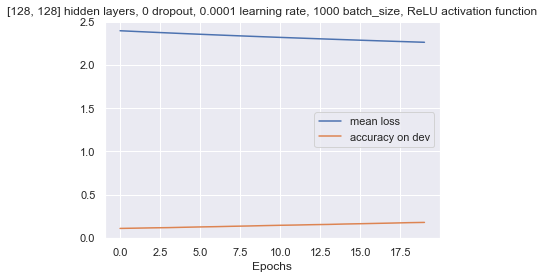

Starting epoch: 0
mean loss:  2.2215433909496864
dev accuracy:  0.4343
Starting epoch: 1
mean loss:  1.8891157302063146
dev accuracy:  0.631
Starting epoch: 2
mean loss:  1.6028095058526213
dev accuracy:  0.7354
Starting epoch: 3
mean loss:  1.3593584569102166
dev accuracy:  0.794
Starting epoch: 4
mean loss:  1.1746757885285126
dev accuracy:  0.8279
Starting epoch: 5
mean loss:  1.0393828848044269
dev accuracy:  0.8444
Starting epoch: 6
mean loss:  0.9415089288006494
dev accuracy:  0.8568
Starting epoch: 7
mean loss:  0.8724845831685246
dev accuracy:  0.8641
Starting epoch: 8
mean loss:  0.8150107596092666
dev accuracy:  0.8705
Starting epoch: 9
mean loss:  0.7715570522359408
dev accuracy:  0.8747
Starting epoch: 10
mean loss:  0.7328778061031747
dev accuracy:  0.8788
Starting epoch: 11
mean loss:  0.7045779908669993
dev accuracy:  0.8827
Starting epoch: 12
mean loss:  0.6700970045961492
dev accuracy:  0.8857
Starting epoch: 13
mean loss:  0.6483230377731621
dev accuracy:  0.8898
Star

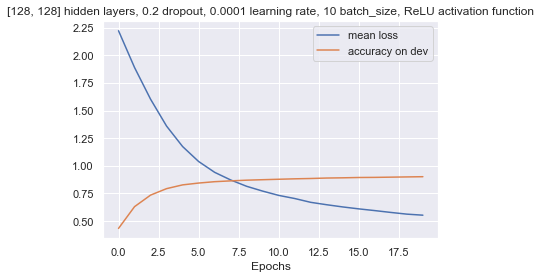

Starting epoch: 0
mean loss:  2.4690359852271166
dev accuracy:  0.1088
Starting epoch: 1
mean loss:  2.378356215006815
dev accuracy:  0.1269
Starting epoch: 2
mean loss:  2.3180553394401384
dev accuracy:  0.1657
Starting epoch: 3
mean loss:  2.266054294780343
dev accuracy:  0.2144
Starting epoch: 4
mean loss:  2.2208816791009047
dev accuracy:  0.2651
Starting epoch: 5
mean loss:  2.1807155161798595
dev accuracy:  0.3098
Starting epoch: 6
mean loss:  2.14535804994092
dev accuracy:  0.355
Starting epoch: 7
mean loss:  2.111705718640082
dev accuracy:  0.3899
Starting epoch: 8
mean loss:  2.0777793159028013
dev accuracy:  0.4215
Starting epoch: 9
mean loss:  2.0430251500325762
dev accuracy:  0.451
Starting epoch: 10
mean loss:  2.0124703950272824
dev accuracy:  0.4762
Starting epoch: 11
mean loss:  1.9833584969153186
dev accuracy:  0.498
Starting epoch: 12
mean loss:  1.9526881598188968
dev accuracy:  0.5165
Starting epoch: 13
mean loss:  1.9231629048041003
dev accuracy:  0.5362
Starting e

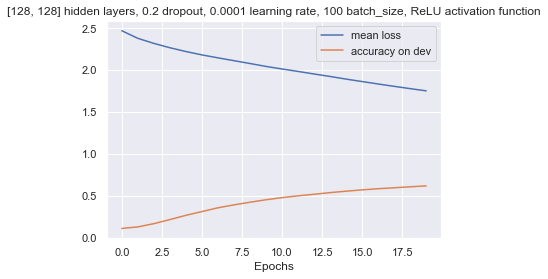

Starting epoch: 0
mean loss:  2.4759477119819793
dev accuracy:  0.1421
Starting epoch: 1
mean loss:  2.4658890191246483
dev accuracy:  0.1445
Starting epoch: 2
mean loss:  2.4547919666065887
dev accuracy:  0.1464
Starting epoch: 3
mean loss:  2.4476650836420992
dev accuracy:  0.148
Starting epoch: 4
mean loss:  2.4374163244284834
dev accuracy:  0.1493
Starting epoch: 5
mean loss:  2.4320366242352653
dev accuracy:  0.1507
Starting epoch: 6
mean loss:  2.4208038133733414
dev accuracy:  0.152
Starting epoch: 7
mean loss:  2.416286870545032
dev accuracy:  0.1537
Starting epoch: 8
mean loss:  2.4112829507565965
dev accuracy:  0.1557
Starting epoch: 9
mean loss:  2.4016315002067414
dev accuracy:  0.1572
Starting epoch: 10
mean loss:  2.393698767119763
dev accuracy:  0.1586
Starting epoch: 11
mean loss:  2.3862773670869717
dev accuracy:  0.1607
Starting epoch: 12
mean loss:  2.3787924308402864
dev accuracy:  0.1624
Starting epoch: 13
mean loss:  2.3727594730900785
dev accuracy:  0.1655
Starti

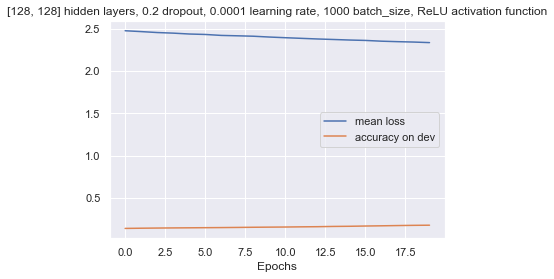

Starting epoch: 0
mean loss:  2.358689355101735
dev accuracy:  0.3682
Starting epoch: 1
mean loss:  2.071653209765228
dev accuracy:  0.5675
Starting epoch: 2
mean loss:  1.8893619610819428
dev accuracy:  0.65
Starting epoch: 3
mean loss:  1.7174147126126875
dev accuracy:  0.709
Starting epoch: 4
mean loss:  1.5682394521709824
dev accuracy:  0.7513
Starting epoch: 5
mean loss:  1.438361527597492
dev accuracy:  0.7829
Starting epoch: 6
mean loss:  1.331924454161368
dev accuracy:  0.8037
Starting epoch: 7
mean loss:  1.2463281607060546
dev accuracy:  0.8187
Starting epoch: 8
mean loss:  1.1655166800845458
dev accuracy:  0.833
Starting epoch: 9
mean loss:  1.1050775152484171
dev accuracy:  0.8426
Starting epoch: 10
mean loss:  1.0506971911165004
dev accuracy:  0.8497
Starting epoch: 11
mean loss:  1.0038194084460677
dev accuracy:  0.8552
Starting epoch: 12
mean loss:  0.9596450273942003
dev accuracy:  0.8616
Starting epoch: 13
mean loss:  0.9247335151949303
dev accuracy:  0.8663
Starting e

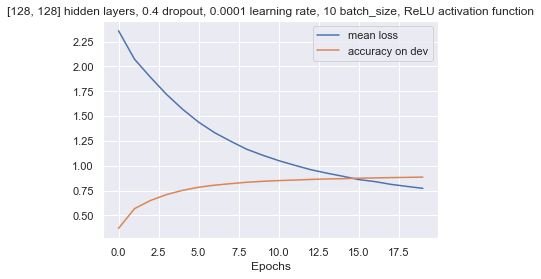

Starting epoch: 0
mean loss:  2.4378494550130085
dev accuracy:  0.1349
Starting epoch: 1
mean loss:  2.394165583475383
dev accuracy:  0.1557
Starting epoch: 2
mean loss:  2.3599025132413396
dev accuracy:  0.1804
Starting epoch: 3
mean loss:  2.327649262612927
dev accuracy:  0.2044
Starting epoch: 4
mean loss:  2.294556558251143
dev accuracy:  0.2285
Starting epoch: 5
mean loss:  2.2735511138291655
dev accuracy:  0.2561
Starting epoch: 6
mean loss:  2.249185947600953
dev accuracy:  0.2843
Starting epoch: 7
mean loss:  2.228315683182128
dev accuracy:  0.3168
Starting epoch: 8
mean loss:  2.206811021188062
dev accuracy:  0.3482
Starting epoch: 9
mean loss:  2.188920507411995
dev accuracy:  0.3811
Starting epoch: 10
mean loss:  2.167325110730535
dev accuracy:  0.4071
Starting epoch: 11
mean loss:  2.151626230000022
dev accuracy:  0.4345
Starting epoch: 12
mean loss:  2.130881147470303
dev accuracy:  0.4607
Starting epoch: 13
mean loss:  2.1135444103362793
dev accuracy:  0.4826
Starting epo

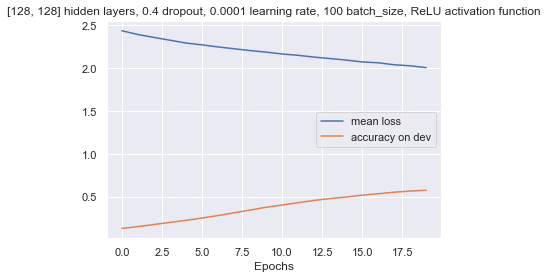

Starting epoch: 0
mean loss:  2.63337435909346
dev accuracy:  0.0801
Starting epoch: 1
mean loss:  2.625137263653325
dev accuracy:  0.0794
Starting epoch: 2
mean loss:  2.604049388100119
dev accuracy:  0.0809
Starting epoch: 3
mean loss:  2.59132316533257
dev accuracy:  0.0835
Starting epoch: 4
mean loss:  2.574578738680073
dev accuracy:  0.0852
Starting epoch: 5
mean loss:  2.5624180588067746
dev accuracy:  0.0877
Starting epoch: 6
mean loss:  2.5508253247130153
dev accuracy:  0.0899
Starting epoch: 7
mean loss:  2.54231325785319
dev accuracy:  0.0936
Starting epoch: 8
mean loss:  2.5358028411865234
dev accuracy:  0.0955
Starting epoch: 9
mean loss:  2.5269471804300943
dev accuracy:  0.0981
Starting epoch: 10
mean loss:  2.510986608617446
dev accuracy:  0.1001
Starting epoch: 11
mean loss:  2.5043374463623644
dev accuracy:  0.1026
Starting epoch: 12
mean loss:  2.4939072599598004
dev accuracy:  0.1044
Starting epoch: 13
mean loss:  2.490228956820918
dev accuracy:  0.107
Starting epoch

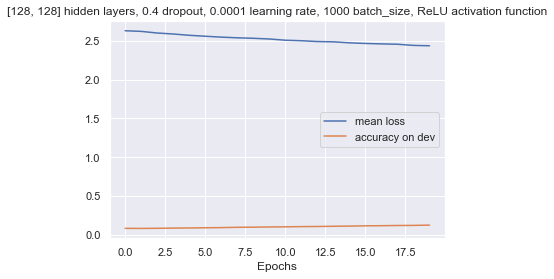

Starting epoch: 0
mean loss:  2.481069935152374
dev accuracy:  0.3665
Starting epoch: 1
mean loss:  2.221729372530264
dev accuracy:  0.5652
Starting epoch: 2
mean loss:  2.1087032712428386
dev accuracy:  0.6331
Starting epoch: 3
mean loss:  2.0135313767334195
dev accuracy:  0.6683
Starting epoch: 4
mean loss:  1.9179808051794487
dev accuracy:  0.6969
Starting epoch: 5
mean loss:  1.8368657910092023
dev accuracy:  0.7187
Starting epoch: 6
mean loss:  1.7580212282910392
dev accuracy:  0.7389
Starting epoch: 7
mean loss:  1.6771917649327075
dev accuracy:  0.7569
Starting epoch: 8
mean loss:  1.605840722255005
dev accuracy:  0.7716
Starting epoch: 9
mean loss:  1.5451825593107105
dev accuracy:  0.7832
Starting epoch: 10
mean loss:  1.4885489074880185
dev accuracy:  0.7984
Starting epoch: 11
mean loss:  1.4437773344552987
dev accuracy:  0.8101
Starting epoch: 12
mean loss:  1.3885997764720033
dev accuracy:  0.818
Starting epoch: 13
mean loss:  1.346120866786907
dev accuracy:  0.8261
Startin

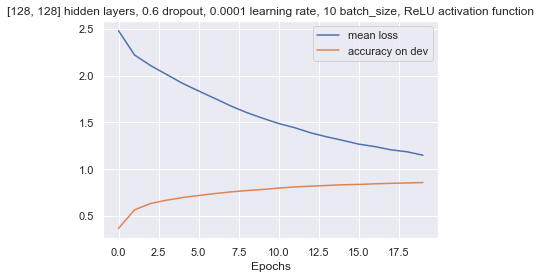

Starting epoch: 0
mean loss:  2.829591398943446
dev accuracy:  0.1153
Starting epoch: 1
mean loss:  2.695912561968653
dev accuracy:  0.1468
Starting epoch: 2
mean loss:  2.5857125289901766
dev accuracy:  0.1808
Starting epoch: 3
mean loss:  2.522191459309317
dev accuracy:  0.2093
Starting epoch: 4
mean loss:  2.4733690439821956
dev accuracy:  0.2407
Starting epoch: 5
mean loss:  2.4296999172774143
dev accuracy:  0.2693
Starting epoch: 6
mean loss:  2.3874269464534676
dev accuracy:  0.2996
Starting epoch: 7
mean loss:  2.360527602498403
dev accuracy:  0.3256
Starting epoch: 8
mean loss:  2.332445514892152
dev accuracy:  0.3519
Starting epoch: 9
mean loss:  2.313442292565595
dev accuracy:  0.3749
Starting epoch: 10
mean loss:  2.2903482823552723
dev accuracy:  0.4001
Starting epoch: 11
mean loss:  2.2735359316576504
dev accuracy:  0.4229
Starting epoch: 12
mean loss:  2.255020866850893
dev accuracy:  0.4423
Starting epoch: 13
mean loss:  2.241802872773892
dev accuracy:  0.4617
Starting e

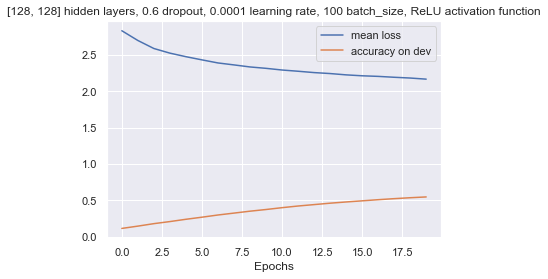

Starting epoch: 0
mean loss:  2.705985994899974
dev accuracy:  0.1175
Starting epoch: 1
mean loss:  2.6829689437267827
dev accuracy:  0.1193
Starting epoch: 2
mean loss:  2.667373086891922
dev accuracy:  0.1213
Starting epoch: 3
mean loss:  2.6474258058211384
dev accuracy:  0.1239
Starting epoch: 4
mean loss:  2.6326538207484225
dev accuracy:  0.1261
Starting epoch: 5
mean loss:  2.6265062771591485
dev accuracy:  0.1297
Starting epoch: 6
mean loss:  2.6158856971591127
dev accuracy:  0.1328
Starting epoch: 7
mean loss:  2.5987736945058786
dev accuracy:  0.1355
Starting epoch: 8
mean loss:  2.5899526652167824
dev accuracy:  0.1387
Starting epoch: 9
mean loss:  2.575891569548962
dev accuracy:  0.1413
Starting epoch: 10
mean loss:  2.563353977951349
dev accuracy:  0.1444
Starting epoch: 11
mean loss:  2.5582439852695837
dev accuracy:  0.1461
Starting epoch: 12
mean loss:  2.546450745825674
dev accuracy:  0.1502
Starting epoch: 13
mean loss:  2.5410339318069757
dev accuracy:  0.1538
Startin

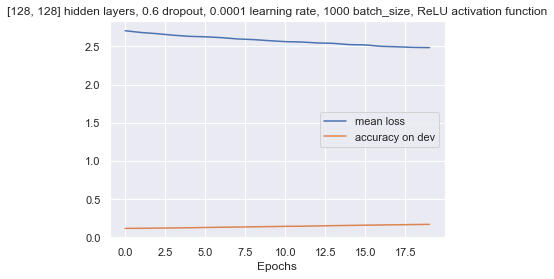

Starting epoch: 0
mean loss:  0.3269237116831836
dev accuracy:  0.9416
Starting epoch: 1
mean loss:  0.15009454646821185
dev accuracy:  0.9615
Starting epoch: 2
mean loss:  0.11091926522956086
dev accuracy:  0.9688
Starting epoch: 3
mean loss:  0.09014088317400623
dev accuracy:  0.9676
Starting epoch: 4
mean loss:  0.07687929198511269
dev accuracy:  0.9698
Starting epoch: 5
mean loss:  0.0675408043141423
dev accuracy:  0.9717
Starting epoch: 6
mean loss:  0.06006371288256936
dev accuracy:  0.9671
Starting epoch: 7
mean loss:  0.055073561734925475
dev accuracy:  0.9726
Starting epoch: 8
mean loss:  0.04842193004311655
dev accuracy:  0.9697
Starting epoch: 9
mean loss:  0.0438554739971218
dev accuracy:  0.9734
Starting epoch: 10
mean loss:  0.03981751714893727
dev accuracy:  0.9696
Starting epoch: 11
mean loss:  0.03743873108807146
dev accuracy:  0.9728
Starting epoch: 12
mean loss:  0.03041666250454811
dev accuracy:  0.972
Starting epoch: 13
mean loss:  0.032281902967565536
dev accuracy

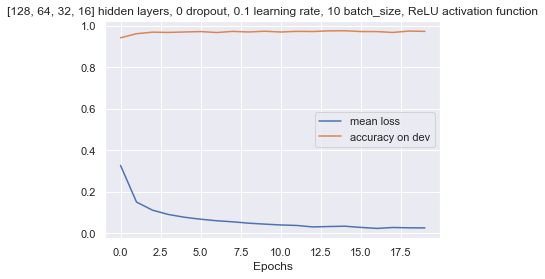

Starting epoch: 0
mean loss:  0.4639286759222101
dev accuracy:  0.9351
Starting epoch: 1
mean loss:  0.16997249727090913
dev accuracy:  0.9508
Starting epoch: 2
mean loss:  0.12101428156082858
dev accuracy:  0.9585
Starting epoch: 3
mean loss:  0.09246365483589991
dev accuracy:  0.965
Starting epoch: 4
mean loss:  0.07325699395442496
dev accuracy:  0.9671
Starting epoch: 5
mean loss:  0.05841687545942481
dev accuracy:  0.968
Starting epoch: 6
mean loss:  0.04680313536257831
dev accuracy:  0.9699
Starting epoch: 7
mean loss:  0.03691766505778401
dev accuracy:  0.97
Starting epoch: 8
mean loss:  0.054396211804483764
dev accuracy:  0.9669
Starting epoch: 9
mean loss:  0.02706117882530861
dev accuracy:  0.9701
Starting epoch: 10
mean loss:  0.02039300014744485
dev accuracy:  0.9712
Starting epoch: 11
mean loss:  0.018966762608678422
dev accuracy:  0.965
Starting epoch: 12
mean loss:  0.013960434823527471
dev accuracy:  0.972
Starting epoch: 13
mean loss:  0.06147923685770394
dev accuracy: 

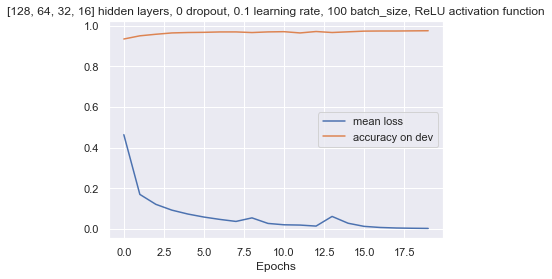

Starting epoch: 0
mean loss:  1.5341865233346528
dev accuracy:  0.7903
Starting epoch: 1
mean loss:  0.6379279622844621
dev accuracy:  0.8552
Starting epoch: 2
mean loss:  0.4084713236958373
dev accuracy:  0.9109
Starting epoch: 3
mean loss:  0.32018352986550797
dev accuracy:  0.9237
Starting epoch: 4
mean loss:  0.2749832748782401
dev accuracy:  0.935
Starting epoch: 5
mean loss:  0.243527831400142
dev accuracy:  0.9401
Starting epoch: 6
mean loss:  0.21842243829194238
dev accuracy:  0.9451
Starting epoch: 7
mean loss:  0.19899757323311826
dev accuracy:  0.948
Starting epoch: 8
mean loss:  0.18295847756021164
dev accuracy:  0.9506
Starting epoch: 9
mean loss:  0.16993850118973675
dev accuracy:  0.9522
Starting epoch: 10
mean loss:  0.15841869776155434
dev accuracy:  0.9543
Starting epoch: 11
mean loss:  0.14821345987273196
dev accuracy:  0.9549
Starting epoch: 12
mean loss:  0.13931179923169754
dev accuracy:  0.9565
Starting epoch: 13
mean loss:  0.13142964799030155
dev accuracy:  0.9

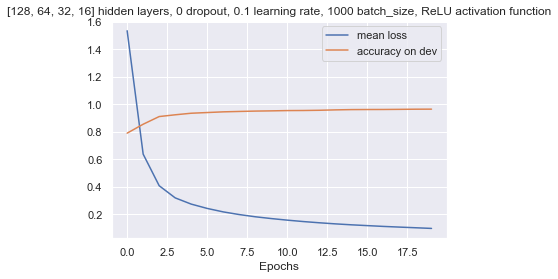

Starting epoch: 0
mean loss:  0.6967609246020068
dev accuracy:  0.9158
Starting epoch: 1
mean loss:  0.40426836465320115
dev accuracy:  0.9518
Starting epoch: 2
mean loss:  0.3384368851828973
dev accuracy:  0.9512
Starting epoch: 3
mean loss:  0.31174371408248996
dev accuracy:  0.9628
Starting epoch: 4
mean loss:  0.28773027122179345
dev accuracy:  0.9615
Starting epoch: 5
mean loss:  0.265252129683536
dev accuracy:  0.9618
Starting epoch: 6
mean loss:  0.26481278366160105
dev accuracy:  0.9616
Starting epoch: 7
mean loss:  0.25388980297610125
dev accuracy:  0.9634
Starting epoch: 8
mean loss:  0.25325616371338966
dev accuracy:  0.9671
Starting epoch: 9
mean loss:  0.2360162192004667
dev accuracy:  0.9696
Starting epoch: 10
mean loss:  0.23201220777193265
dev accuracy:  0.966
Starting epoch: 11
mean loss:  0.22640283518840176
dev accuracy:  0.9697
Starting epoch: 12
mean loss:  0.22582881024841808
dev accuracy:  0.9648
Starting epoch: 13
mean loss:  0.2254026228486567
dev accuracy:  0.

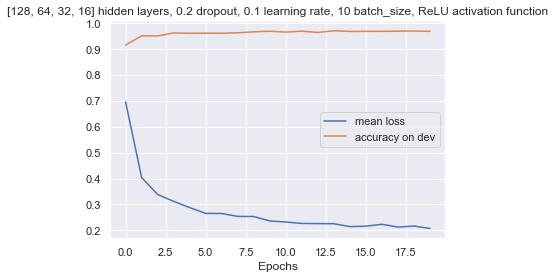

Starting epoch: 0
mean loss:  0.971311579445403
dev accuracy:  0.9301
Starting epoch: 1
mean loss:  0.4583636672494416
dev accuracy:  0.9503
Starting epoch: 2
mean loss:  0.36047794891450696
dev accuracy:  0.9596
Starting epoch: 3
mean loss:  0.30721383729202306
dev accuracy:  0.9592
Starting epoch: 4
mean loss:  0.270863540091379
dev accuracy:  0.9636
Starting epoch: 5
mean loss:  0.24942280527598368
dev accuracy:  0.9668
Starting epoch: 6
mean loss:  0.2269418945242307
dev accuracy:  0.9683
Starting epoch: 7
mean loss:  0.21201292403830502
dev accuracy:  0.9676
Starting epoch: 8
mean loss:  0.19672893339437164
dev accuracy:  0.9701
Starting epoch: 9
mean loss:  0.18870222645099768
dev accuracy:  0.9724
Starting epoch: 10
mean loss:  0.17764235091602018
dev accuracy:  0.9717
Starting epoch: 11
mean loss:  0.16459796710047656
dev accuracy:  0.9734
Starting epoch: 12
mean loss:  0.16441613405258831
dev accuracy:  0.9731
Starting epoch: 13
mean loss:  0.1551554199538664
dev accuracy:  0.

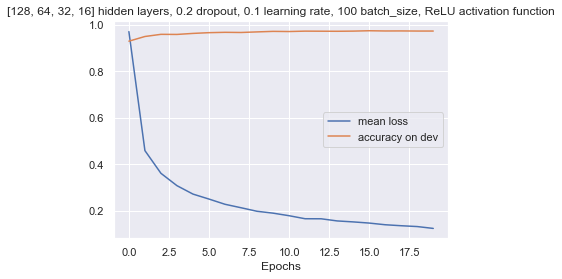

Starting epoch: 0
mean loss:  1.917524499051711
dev accuracy:  0.623
Starting epoch: 1
mean loss:  1.3567424381480497
dev accuracy:  0.7852
Starting epoch: 2
mean loss:  1.0640547240481657
dev accuracy:  0.8408
Starting epoch: 3
mean loss:  0.899207124523088
dev accuracy:  0.8778
Starting epoch: 4
mean loss:  0.7940718227741765
dev accuracy:  0.8967
Starting epoch: 5
mean loss:  0.7157499170770832
dev accuracy:  0.9121
Starting epoch: 6
mean loss:  0.6545550881647596
dev accuracy:  0.9229
Starting epoch: 7
mean loss:  0.607347872911715
dev accuracy:  0.9284
Starting epoch: 8
mean loss:  0.5646072135252111
dev accuracy:  0.9351
Starting epoch: 9
mean loss:  0.5273179359295789
dev accuracy:  0.9377
Starting epoch: 10
mean loss:  0.49688459728278367
dev accuracy:  0.9413
Starting epoch: 11
mean loss:  0.47248702773860857
dev accuracy:  0.9436
Starting epoch: 12
mean loss:  0.4454967730185565
dev accuracy:  0.947
Starting epoch: 13
mean loss:  0.43044623732566833
dev accuracy:  0.9496
Star

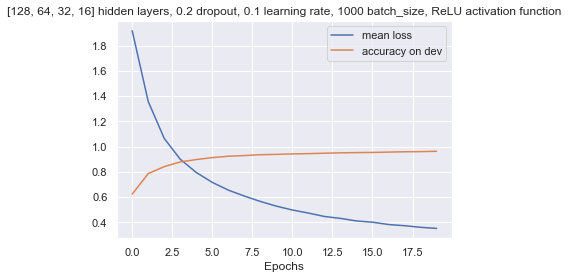

Starting epoch: 0
mean loss:  1.4323469188434557
dev accuracy:  0.7561
Starting epoch: 1
mean loss:  1.1586701627064648
dev accuracy:  0.7576
Starting epoch: 2
mean loss:  1.1417458893951358
dev accuracy:  0.7954
Starting epoch: 3
mean loss:  1.1601950075925052
dev accuracy:  0.8201
Starting epoch: 4
mean loss:  1.2537528443228625
dev accuracy:  0.7161
Starting epoch: 5
mean loss:  1.271004524544534
dev accuracy:  0.7436
Starting epoch: 6
mean loss:  1.2666055646208592
dev accuracy:  0.7126
Starting epoch: 7
mean loss:  1.2793313843015433
dev accuracy:  0.7041
Starting epoch: 8
mean loss:  1.262869484887984
dev accuracy:  0.7237
Starting epoch: 9
mean loss:  1.2510341187029141
dev accuracy:  0.7003
Starting epoch: 10
mean loss:  1.2253397140019513
dev accuracy:  0.7205
Starting epoch: 11
mean loss:  1.2696398499011516
dev accuracy:  0.7055
Starting epoch: 12
mean loss:  1.3050591271535275
dev accuracy:  0.7388
Starting epoch: 13
mean loss:  1.3174922389761015
dev accuracy:  0.7151
Star

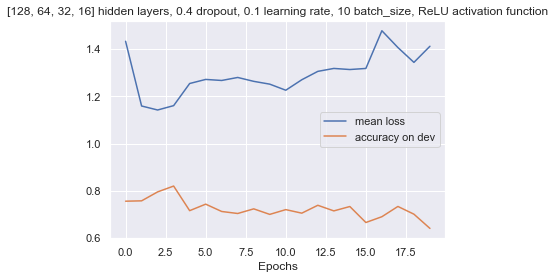

Starting epoch: 0
mean loss:  1.6844496317728312
dev accuracy:  0.7825
Starting epoch: 1
mean loss:  1.0718750595570563
dev accuracy:  0.8174
Starting epoch: 2
mean loss:  0.8807744659825475
dev accuracy:  0.8773
Starting epoch: 3
mean loss:  0.777813202011847
dev accuracy:  0.9046
Starting epoch: 4
mean loss:  0.7043488784702476
dev accuracy:  0.9265
Starting epoch: 5
mean loss:  0.6577288805248732
dev accuracy:  0.9377
Starting epoch: 6
mean loss:  0.62666140005974
dev accuracy:  0.9367
Starting epoch: 7
mean loss:  0.6035191680856807
dev accuracy:  0.945
Starting epoch: 8
mean loss:  0.5723366567831554
dev accuracy:  0.9471
Starting epoch: 9
mean loss:  0.5521588261255961
dev accuracy:  0.9468
Starting epoch: 10
mean loss:  0.539184884902484
dev accuracy:  0.9504
Starting epoch: 11
mean loss:  0.5240091347468352
dev accuracy:  0.9514
Starting epoch: 12
mean loss:  0.5136013148787493
dev accuracy:  0.9437
Starting epoch: 13
mean loss:  0.49856569104922743
dev accuracy:  0.9542
Starti

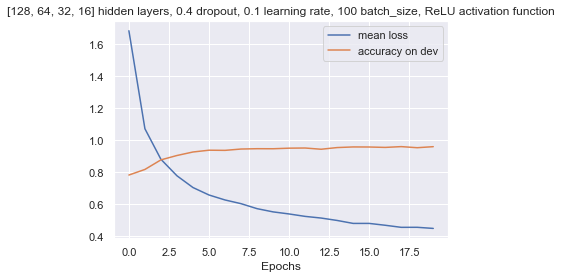

Starting epoch: 0
mean loss:  2.2698148465624044
dev accuracy:  0.4304
Starting epoch: 1
mean loss:  2.0750340877794753
dev accuracy:  0.5771
Starting epoch: 2
mean loss:  1.8858718451331644
dev accuracy:  0.6352
Starting epoch: 3
mean loss:  1.6821512825348799
dev accuracy:  0.696
Starting epoch: 4
mean loss:  1.5091807982500862
dev accuracy:  0.7302
Starting epoch: 5
mean loss:  1.3788031760384054
dev accuracy:  0.7648
Starting epoch: 6
mean loss:  1.2911742621777105
dev accuracy:  0.7874
Starting epoch: 7
mean loss:  1.2151427245607562
dev accuracy:  0.8023
Starting epoch: 8
mean loss:  1.1392221614426257
dev accuracy:  0.8135
Starting epoch: 9
mean loss:  1.077980991672067
dev accuracy:  0.8287
Starting epoch: 10
mean loss:  1.0391930084602505
dev accuracy:  0.8415
Starting epoch: 11
mean loss:  0.9983197544135299
dev accuracy:  0.8499
Starting epoch: 12
mean loss:  0.951126006304049
dev accuracy:  0.8491
Starting epoch: 13
mean loss:  0.9240725893600314
dev accuracy:  0.8556
Start

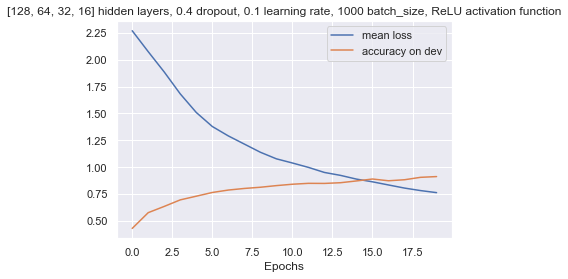

Starting epoch: 0
mean loss:  2.2377853957063505
dev accuracy:  0.195
Starting epoch: 1
mean loss:  2.2349939453580383
dev accuracy:  0.1604
Starting epoch: 2
mean loss:  2.2541099686642645
dev accuracy:  0.1958
Starting epoch: 3
mean loss:  2.25368786516058
dev accuracy:  0.18
Starting epoch: 4
mean loss:  2.26856230895678
dev accuracy:  0.1737
Starting epoch: 5
mean loss:  2.276404687367161
dev accuracy:  0.1638
Starting epoch: 6
mean loss:  2.281179423952932
dev accuracy:  0.0991
Starting epoch: 7
mean loss:  2.2895827074333135
dev accuracy:  0.1639
Starting epoch: 8
mean loss:  2.2813193003098218
dev accuracy:  0.1841
Starting epoch: 9
mean loss:  2.2724062226052713
dev accuracy:  0.1721
Starting epoch: 10


KeyboardInterrupt: 

In [0]:
layer_dims_testing = [[128, 128], [128,64,32,16], [256,128,64,32,16], [512,256,128,64,32,16], [800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4, 0.6]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
models_list = []
mean_loss_list = []
dev_accuracy_list = []

EPOCHS = 20
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = ReluMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model = model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list.append(model)
                mean_loss_list.append(mean_losses)
                dev_accuracy_list.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "ReLU")

Starting epoch: 0
mean loss:  0.20350924095596584
dev accuracy:  0.9608
Starting epoch: 1
mean loss:  0.07602751962692768
dev accuracy:  0.9697
Starting epoch: 2
mean loss:  0.039567558888335144
dev accuracy:  0.9779
Starting epoch: 3
mean loss:  0.02502108796064109
dev accuracy:  0.9763
Starting epoch: 4
mean loss:  0.018866315566298236
dev accuracy:  0.9783
Starting epoch: 5
mean loss:  0.016962716706641876
dev accuracy:  0.9756
Starting epoch: 6
mean loss:  0.013507248135077395
dev accuracy:  0.9805
Starting epoch: 7
mean loss:  0.008401685997410993
dev accuracy:  0.9813
Starting epoch: 8
mean loss:  0.005551607039307946
dev accuracy:  0.9825
Starting epoch: 9
mean loss:  0.004659316678532946
dev accuracy:  0.9815
Starting epoch: 10
mean loss:  0.0029607315778649194
dev accuracy:  0.9828
Starting epoch: 11
mean loss:  0.0006179251267139515
dev accuracy:  0.9838
Starting epoch: 12
mean loss:  0.0001711548957897475
dev accuracy:  0.9843
Starting epoch: 13
mean loss:  0.000116419234382

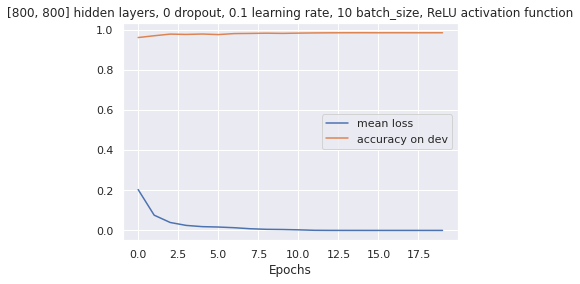

Starting epoch: 0
mean loss:  0.35315301264831406
dev accuracy:  0.9527
Starting epoch: 1
mean loss:  0.16289472846154443
dev accuracy:  0.9644
Starting epoch: 2
mean loss:  0.11554267504689342
dev accuracy:  0.9693
Starting epoch: 3
mean loss:  0.08821078820782388
dev accuracy:  0.9719
Starting epoch: 4
mean loss:  0.06970109763795031
dev accuracy:  0.974
Starting epoch: 5
mean loss:  0.0559401044253996
dev accuracy:  0.9751
Starting epoch: 6
mean loss:  0.04533096880256059
dev accuracy:  0.9765
Starting epoch: 7
mean loss:  0.03698340859338493
dev accuracy:  0.9767
Starting epoch: 8
mean loss:  0.030267843067601413
dev accuracy:  0.9767
Starting epoch: 9
mean loss:  0.024869302751500153
dev accuracy:  0.9775
Starting epoch: 10
mean loss:  0.02052441357445351
dev accuracy:  0.9778
Starting epoch: 11
mean loss:  0.01703272035118646
dev accuracy:  0.9782
Starting epoch: 12
mean loss:  0.014209295771253887
dev accuracy:  0.9784
Starting epoch: 13
mean loss:  0.011957904749165128
dev accu

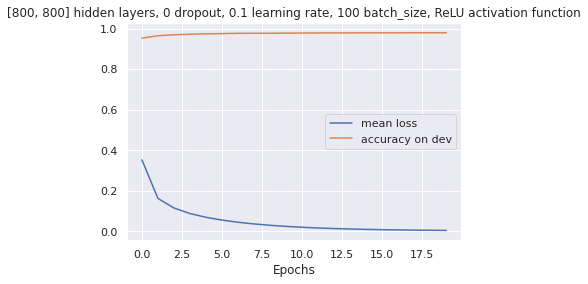

Starting epoch: 0
mean loss:  0.842758996813905
dev accuracy:  0.8956
Starting epoch: 1
mean loss:  0.3834132435275059
dev accuracy:  0.9181
Starting epoch: 2
mean loss:  0.3081961455298405
dev accuracy:  0.9262
Starting epoch: 3
mean loss:  0.2734683001158284
dev accuracy:  0.9329
Starting epoch: 4
mean loss:  0.2494484966292101
dev accuracy:  0.9379
Starting epoch: 5
mean loss:  0.2308120487951765
dev accuracy:  0.9421
Starting epoch: 6
mean loss:  0.21540037060485168
dev accuracy:  0.9458
Starting epoch: 7
mean loss:  0.20217779629370747
dev accuracy:  0.9486
Starting epoch: 8
mean loss:  0.19060601615438275
dev accuracy:  0.9514
Starting epoch: 9
mean loss:  0.18033742817009196
dev accuracy:  0.9539
Starting epoch: 10
mean loss:  0.17112441390168434
dev accuracy:  0.9558
Starting epoch: 11
mean loss:  0.16279991321703968
dev accuracy:  0.9569
Starting epoch: 12
mean loss:  0.15521927265559926
dev accuracy:  0.959
Starting epoch: 13
mean loss:  0.14829448040793924
dev accuracy:  0.9

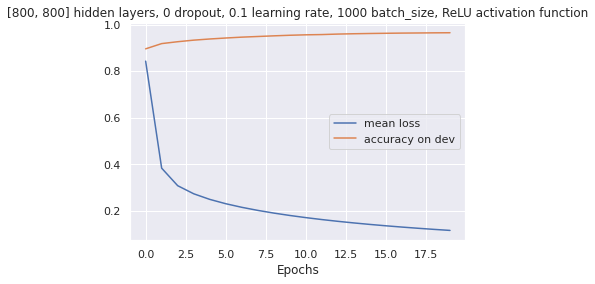

Starting epoch: 0
mean loss:  0.28210316376098427
dev accuracy:  0.9581
Starting epoch: 1
mean loss:  0.14353985956268106
dev accuracy:  0.9676
Starting epoch: 2
mean loss:  0.10609891055288695
dev accuracy:  0.973
Starting epoch: 3
mean loss:  0.09036612792732386
dev accuracy:  0.9735
Starting epoch: 4
mean loss:  0.0756724036222047
dev accuracy:  0.9764
Starting epoch: 5
mean loss:  0.06773364544023203
dev accuracy:  0.9774
Starting epoch: 6
mean loss:  0.057025792952461275
dev accuracy:  0.9795
Starting epoch: 7
mean loss:  0.052801355822986396
dev accuracy:  0.9783
Starting epoch: 8
mean loss:  0.04923898295827951
dev accuracy:  0.9788
Starting epoch: 9
mean loss:  0.04484556315310605
dev accuracy:  0.9809
Starting epoch: 10
mean loss:  0.03980872820290304
dev accuracy:  0.979
Starting epoch: 11
mean loss:  0.039795413630607346
dev accuracy:  0.9818
Starting epoch: 12
mean loss:  0.04050476165550899
dev accuracy:  0.9816
Starting epoch: 13
mean loss:  0.03473606158982637
dev accura

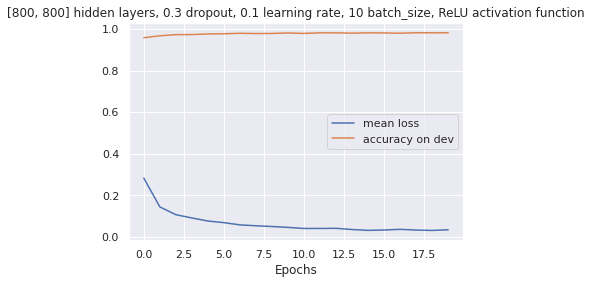

Starting epoch: 0
mean loss:  0.43533912235629296
dev accuracy:  0.9472
Starting epoch: 1
mean loss:  0.21183469948059547
dev accuracy:  0.962
Starting epoch: 2
mean loss:  0.15754956560964117
dev accuracy:  0.9665
Starting epoch: 3
mean loss:  0.12866719955663958
dev accuracy:  0.9711
Starting epoch: 4
mean loss:  0.10897016696289866
dev accuracy:  0.9745
Starting epoch: 5
mean loss:  0.09409979723780575
dev accuracy:  0.9749
Starting epoch: 6
mean loss:  0.08436666596718058
dev accuracy:  0.977
Starting epoch: 7
mean loss:  0.07405478993389837
dev accuracy:  0.978
Starting epoch: 8
mean loss:  0.0669893658182727
dev accuracy:  0.979
Starting epoch: 9
mean loss:  0.0609445884162021
dev accuracy:  0.9776
Starting epoch: 10
mean loss:  0.05518212103881611
dev accuracy:  0.9785
Starting epoch: 11
mean loss:  0.04954982076319838
dev accuracy:  0.9804
Starting epoch: 12
mean loss:  0.045662630470227936
dev accuracy:  0.98
Starting epoch: 13
mean loss:  0.04077022067157778
dev accuracy:  0.

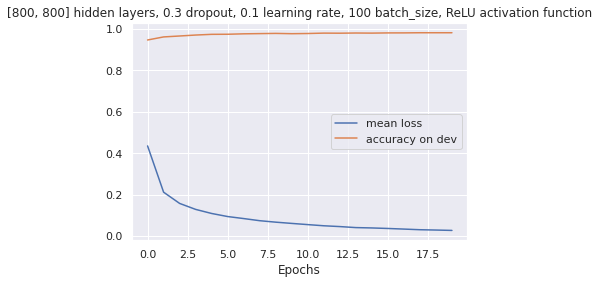

Starting epoch: 0
mean loss:  1.018251334919649
dev accuracy:  0.8914
Starting epoch: 1
mean loss:  0.49990562130423155
dev accuracy:  0.9119
Starting epoch: 2
mean loss:  0.4099141055462407
dev accuracy:  0.9235
Starting epoch: 3
mean loss:  0.36466869945619623
dev accuracy:  0.9273
Starting epoch: 4
mean loss:  0.32881980608491335
dev accuracy:  0.9329
Starting epoch: 5
mean loss:  0.3055364027911541
dev accuracy:  0.9368
Starting epoch: 6
mean loss:  0.28649186094601947
dev accuracy:  0.9396
Starting epoch: 7
mean loss:  0.2685481420919007
dev accuracy:  0.9437
Starting epoch: 8
mean loss:  0.25498819964773517
dev accuracy:  0.9471
Starting epoch: 9
mean loss:  0.2403691536655613
dev accuracy:  0.9489
Starting epoch: 10
mean loss:  0.22974744731304692
dev accuracy:  0.9517
Starting epoch: 11
mean loss:  0.22138388863965577
dev accuracy:  0.9541
Starting epoch: 12
mean loss:  0.21079629162947336
dev accuracy:  0.9563
Starting epoch: 13
mean loss:  0.20404960010565965
dev accuracy:  0

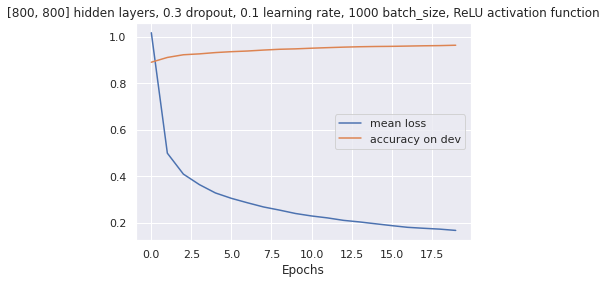

Starting epoch: 0
mean loss:  0.5667995057916145
dev accuracy:  0.9504
Starting epoch: 1
mean loss:  0.36430156841081196
dev accuracy:  0.9565
Starting epoch: 2
mean loss:  0.31635006507109464
dev accuracy:  0.961
Starting epoch: 3
mean loss:  0.2924341872861557
dev accuracy:  0.9562
Starting epoch: 4
mean loss:  0.2627590627556168
dev accuracy:  0.9624
Starting epoch: 5
mean loss:  0.24801543315367383
dev accuracy:  0.9659
Starting epoch: 6
mean loss:  0.2571903378767675
dev accuracy:  0.9642
Starting epoch: 7
mean loss:  0.23509879706730674
dev accuracy:  0.9665
Starting epoch: 8
mean loss:  0.2424611890746358
dev accuracy:  0.9658
Starting epoch: 9
mean loss:  0.22070552871708315
dev accuracy:  0.9684
Starting epoch: 10
mean loss:  0.21465237127178696
dev accuracy:  0.9676
Starting epoch: 11
mean loss:  0.20988456821110096
dev accuracy:  0.969
Starting epoch: 12
mean loss:  0.2159721026998725
dev accuracy:  0.9687
Starting epoch: 13
mean loss:  0.21021943308113483
dev accuracy:  0.9

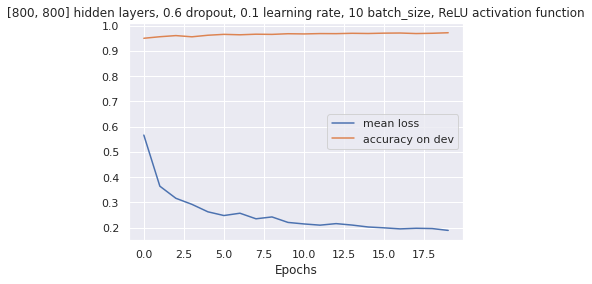

Starting epoch: 0
mean loss:  0.6035285051354391
dev accuracy:  0.941
Starting epoch: 1
mean loss:  0.3099190030774908
dev accuracy:  0.9546
Starting epoch: 2
mean loss:  0.24295903273863706
dev accuracy:  0.9622
Starting epoch: 3
mean loss:  0.2095016516269205
dev accuracy:  0.9673
Starting epoch: 4
mean loss:  0.1859530824535859
dev accuracy:  0.9705
Starting epoch: 5
mean loss:  0.1656398042337504
dev accuracy:  0.9723
Starting epoch: 6
mean loss:  0.1505337708598066
dev accuracy:  0.9735
Starting epoch: 7
mean loss:  0.13589342717386171
dev accuracy:  0.9743
Starting epoch: 8
mean loss:  0.1299750918481581
dev accuracy:  0.9754
Starting epoch: 9
mean loss:  0.12005025661455657
dev accuracy:  0.9762
Starting epoch: 10
mean loss:  0.1154743118059195
dev accuracy:  0.9774
Starting epoch: 11
mean loss:  0.10649930097408102
dev accuracy:  0.977
Starting epoch: 12
mean loss:  0.10067671748201647
dev accuracy:  0.9778
Starting epoch: 13
mean loss:  0.09637179694690569
dev accuracy:  0.978

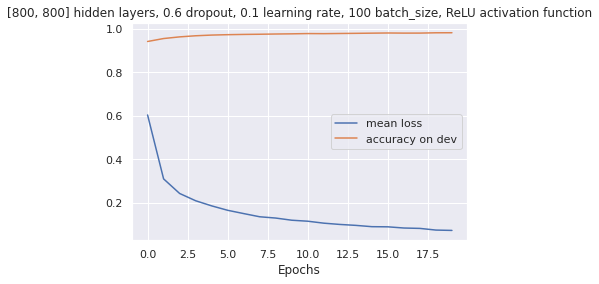

Starting epoch: 0
mean loss:  1.3753368036419737
dev accuracy:  0.8714
Starting epoch: 1
mean loss:  0.7336141525530347
dev accuracy:  0.8999
Starting epoch: 2
mean loss:  0.5825349992396784
dev accuracy:  0.9123
Starting epoch: 3
mean loss:  0.5125235254858055
dev accuracy:  0.9186
Starting epoch: 4
mean loss:  0.46852398327752653
dev accuracy:  0.925
Starting epoch: 5
mean loss:  0.4297225539590798
dev accuracy:  0.9287
Starting epoch: 6
mean loss:  0.40072425849297466
dev accuracy:  0.9318
Starting epoch: 7
mean loss:  0.37777990687127205
dev accuracy:  0.9347
Starting epoch: 8
mean loss:  0.3613111429354724
dev accuracy:  0.9359
Starting epoch: 9
mean loss:  0.3428790767987569
dev accuracy:  0.9392
Starting epoch: 10
mean loss:  0.3310914840184006
dev accuracy:  0.9423
Starting epoch: 11
mean loss:  0.31415731941952424
dev accuracy:  0.9445
Starting epoch: 12
mean loss:  0.3039022987964107
dev accuracy:  0.9466
Starting epoch: 13
mean loss:  0.2898157916817011
dev accuracy:  0.9478

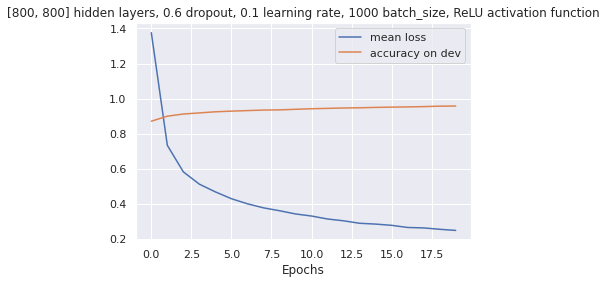

Starting epoch: 0
mean loss:  0.3405038088564201
dev accuracy:  0.9508
Starting epoch: 1
mean loss:  0.16448256595150923
dev accuracy:  0.962
Starting epoch: 2
mean loss:  0.1163368388907469
dev accuracy:  0.9678
Starting epoch: 3
mean loss:  0.08853264881463083
dev accuracy:  0.9711
Starting epoch: 4
mean loss:  0.06959689282857105
dev accuracy:  0.9726
Starting epoch: 5
mean loss:  0.055684355856065494
dev accuracy:  0.9748
Starting epoch: 6
mean loss:  0.04492704153207486
dev accuracy:  0.9763
Starting epoch: 7
mean loss:  0.03644062543014736
dev accuracy:  0.9765
Starting epoch: 8
mean loss:  0.029711156943878728
dev accuracy:  0.9765
Starting epoch: 9
mean loss:  0.024363628123157063
dev accuracy:  0.977
Starting epoch: 10
mean loss:  0.020066304787819407
dev accuracy:  0.9776
Starting epoch: 11
mean loss:  0.01660142990670681
dev accuracy:  0.9774
Starting epoch: 12
mean loss:  0.013828658548977883
dev accuracy:  0.9775
Starting epoch: 13
mean loss:  0.011599967046093661
dev accu

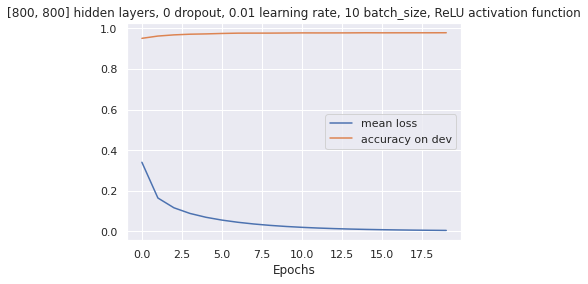

Starting epoch: 0
mean loss:  0.8309895058948836
dev accuracy:  0.9014
Starting epoch: 1
mean loss:  0.3754599023900346
dev accuracy:  0.9159
Starting epoch: 2
mean loss:  0.310161873252092
dev accuracy:  0.9261
Starting epoch: 3
mean loss:  0.2761125494828243
dev accuracy:  0.9315
Starting epoch: 4
mean loss:  0.25254966323068756
dev accuracy:  0.9377
Starting epoch: 5
mean loss:  0.23413154569095718
dev accuracy:  0.9414
Starting epoch: 6
mean loss:  0.21883079995533186
dev accuracy:  0.9446
Starting epoch: 7
mean loss:  0.20566980624032355
dev accuracy:  0.9477
Starting epoch: 8
mean loss:  0.19412667653755752
dev accuracy:  0.9499
Starting epoch: 9
mean loss:  0.18380600341155143
dev accuracy:  0.9526
Starting epoch: 10
mean loss:  0.17449146187947895
dev accuracy:  0.9552
Starting epoch: 11
mean loss:  0.16605051484947908
dev accuracy:  0.9564
Starting epoch: 12
mean loss:  0.15836130435803455
dev accuracy:  0.9583
Starting epoch: 13
mean loss:  0.15128938887944954
dev accuracy:  

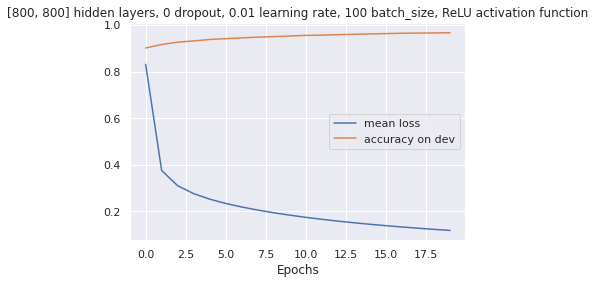

Starting epoch: 0
mean loss:  1.8700169208003026
dev accuracy:  0.7171
Starting epoch: 1
mean loss:  1.2861868774189669
dev accuracy:  0.8119
Starting epoch: 2
mean loss:  0.9521651373190039
dev accuracy:  0.8464
Starting epoch: 3
mean loss:  0.7652346550249586
dev accuracy:  0.8653
Starting epoch: 4
mean loss:  0.6536890572192622
dev accuracy:  0.8757
Starting epoch: 5
mean loss:  0.581032230573542
dev accuracy:  0.8824
Starting epoch: 6
mean loss:  0.5300753052328148
dev accuracy:  0.8886
Starting epoch: 7
mean loss:  0.4922729865008709
dev accuracy:  0.8927
Starting epoch: 8
mean loss:  0.4630029411876903
dev accuracy:  0.8967
Starting epoch: 9
mean loss:  0.43956946450121265
dev accuracy:  0.9001
Starting epoch: 10
mean loss:  0.4203205079424615
dev accuracy:  0.9036
Starting epoch: 11
mean loss:  0.40416168640641603
dev accuracy:  0.9064
Starting epoch: 12
mean loss:  0.39035430141523775
dev accuracy:  0.9089
Starting epoch: 13
mean loss:  0.3783755956911573
dev accuracy:  0.9095


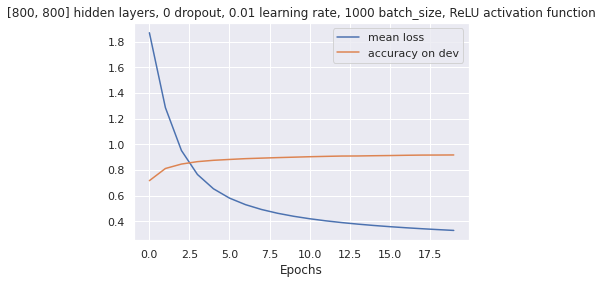

Starting epoch: 0
mean loss:  0.4237475378971068
dev accuracy:  0.9477
Starting epoch: 1
mean loss:  0.21585382758713312
dev accuracy:  0.9631
Starting epoch: 2
mean loss:  0.16056144139867715
dev accuracy:  0.968
Starting epoch: 3
mean loss:  0.13075623035653822
dev accuracy:  0.9715
Starting epoch: 4
mean loss:  0.1096060560546723
dev accuracy:  0.9725
Starting epoch: 5
mean loss:  0.094776972732871
dev accuracy:  0.9766
Starting epoch: 6
mean loss:  0.08268214602423483
dev accuracy:  0.9769
Starting epoch: 7
mean loss:  0.07322298823812229
dev accuracy:  0.9766
Starting epoch: 8
mean loss:  0.06759833649936639
dev accuracy:  0.9784
Starting epoch: 9
mean loss:  0.06288146642560268
dev accuracy:  0.9793
Starting epoch: 10
mean loss:  0.053126271714630524
dev accuracy:  0.98
Starting epoch: 11
mean loss:  0.048303543262339425
dev accuracy:  0.9801
Starting epoch: 12
mean loss:  0.0459995134059169
dev accuracy:  0.9801
Starting epoch: 13
mean loss:  0.043899372776278395
dev accuracy:  

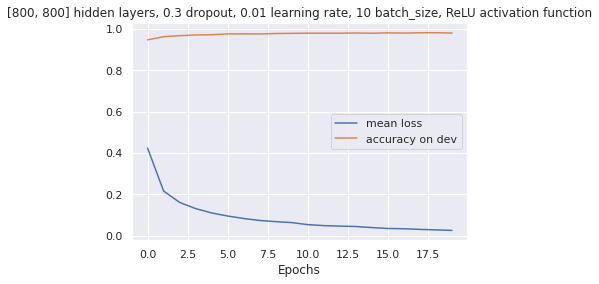

Starting epoch: 0
mean loss:  1.0282973476393733
dev accuracy:  0.8875
Starting epoch: 1
mean loss:  0.5088063862747298
dev accuracy:  0.9115
Starting epoch: 2
mean loss:  0.4168102690976061
dev accuracy:  0.9232
Starting epoch: 3
mean loss:  0.3677401259511769
dev accuracy:  0.9282
Starting epoch: 4
mean loss:  0.3363453961477546
dev accuracy:  0.9335
Starting epoch: 5
mean loss:  0.3119640330414096
dev accuracy:  0.9379
Starting epoch: 6
mean loss:  0.2933589685076249
dev accuracy:  0.9403
Starting epoch: 7
mean loss:  0.2755414645620687
dev accuracy:  0.9442
Starting epoch: 8
mean loss:  0.2586587423573949
dev accuracy:  0.9476
Starting epoch: 9
mean loss:  0.24500574695017047
dev accuracy:  0.9507
Starting epoch: 10
mean loss:  0.2348580607872999
dev accuracy:  0.9533
Starting epoch: 11
mean loss:  0.22592447109208136
dev accuracy:  0.9544
Starting epoch: 12
mean loss:  0.21443937436311306
dev accuracy:  0.9563
Starting epoch: 13
mean loss:  0.2056259139331277
dev accuracy:  0.9575

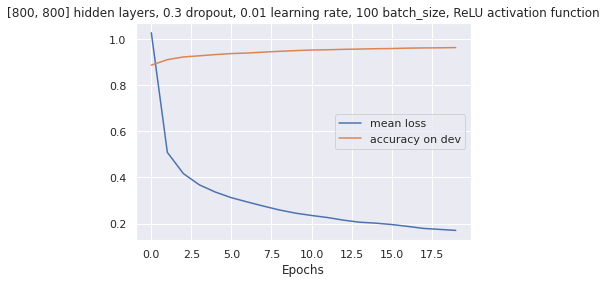

Starting epoch: 0
mean loss:  2.0327551855760464
dev accuracy:  0.6751
Starting epoch: 1
mean loss:  1.5232991751502543
dev accuracy:  0.7849
Starting epoch: 2
mean loss:  1.2019936150195552
dev accuracy:  0.8272
Starting epoch: 3
mean loss:  0.995620608329773
dev accuracy:  0.8503
Starting epoch: 4
mean loss:  0.8642074150197646
dev accuracy:  0.8638
Starting epoch: 5
mean loss:  0.7706560702884898
dev accuracy:  0.872
Starting epoch: 6
mean loss:  0.7087260145767063
dev accuracy:  0.8788
Starting epoch: 7
mean loss:  0.6560896483122134
dev accuracy:  0.8829
Starting epoch: 8
mean loss:  0.6186570840723374
dev accuracy:  0.8878
Starting epoch: 9
mean loss:  0.5901533248377782
dev accuracy:  0.892
Starting epoch: 10
mean loss:  0.5629723562913782
dev accuracy:  0.8956
Starting epoch: 11
mean loss:  0.5402789840511247
dev accuracy:  0.898
Starting epoch: 12
mean loss:  0.5230442408253165
dev accuracy:  0.9008
Starting epoch: 13
mean loss:  0.5064414242903391
dev accuracy:  0.9027
Starti

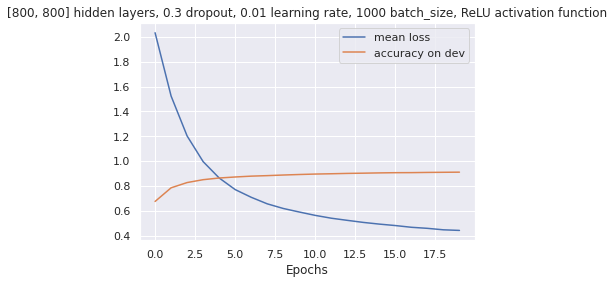

Starting epoch: 0
mean loss:  0.6082489568435834
dev accuracy:  0.9387
Starting epoch: 1
mean loss:  0.3197038814855095
dev accuracy:  0.9546
Starting epoch: 2
mean loss:  0.24719842371007159
dev accuracy:  0.9625
Starting epoch: 3
mean loss:  0.21041722263278334
dev accuracy:  0.9662
Starting epoch: 4
mean loss:  0.18495307976748349
dev accuracy:  0.9693
Starting epoch: 5
mean loss:  0.16451050615179025
dev accuracy:  0.9701
Starting epoch: 6
mean loss:  0.1517497463102765
dev accuracy:  0.9733
Starting epoch: 7
mean loss:  0.13960177127089074
dev accuracy:  0.9727
Starting epoch: 8
mean loss:  0.12760008604500622
dev accuracy:  0.9753
Starting epoch: 9
mean loss:  0.11808381779031321
dev accuracy:  0.976
Starting epoch: 10
mean loss:  0.11637364050554926
dev accuracy:  0.976
Starting epoch: 11
mean loss:  0.10616719192404184
dev accuracy:  0.9767
Starting epoch: 12
mean loss:  0.10273561571837107
dev accuracy:  0.9779
Starting epoch: 13
mean loss:  0.09851445145592301
dev accuracy:  

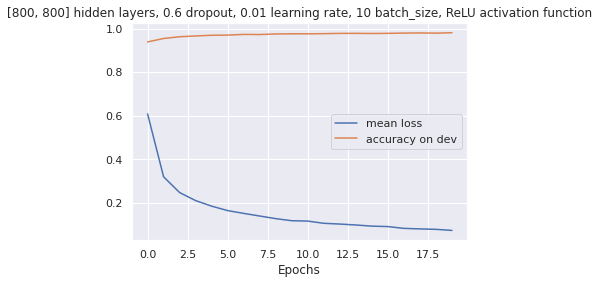

Starting epoch: 0
mean loss:  1.3992523264266297
dev accuracy:  0.8616
Starting epoch: 1
mean loss:  0.7478155237947871
dev accuracy:  0.8956
Starting epoch: 2
mean loss:  0.5997437742536891
dev accuracy:  0.9085
Starting epoch: 3
mean loss:  0.5250110353776318
dev accuracy:  0.9174
Starting epoch: 4
mean loss:  0.475008460010835
dev accuracy:  0.9231
Starting epoch: 5
mean loss:  0.43820800651571234
dev accuracy:  0.9265
Starting epoch: 6
mean loss:  0.4138720977211189
dev accuracy:  0.9296
Starting epoch: 7
mean loss:  0.38790505877630915
dev accuracy:  0.933
Starting epoch: 8
mean loss:  0.36714528022174114
dev accuracy:  0.9362
Starting epoch: 9
mean loss:  0.34922814874829883
dev accuracy:  0.939
Starting epoch: 10
mean loss:  0.33649554551242594
dev accuracy:  0.9419
Starting epoch: 11
mean loss:  0.32506691668918747
dev accuracy:  0.945
Starting epoch: 12
mean loss:  0.3139936433818764
dev accuracy:  0.9463
Starting epoch: 13
mean loss:  0.3019607379705368
dev accuracy:  0.9488


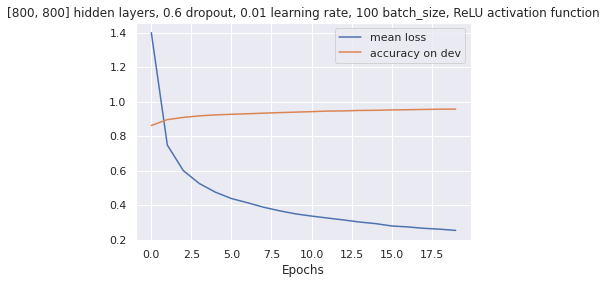

Starting epoch: 0
mean loss:  2.3861136062472474
dev accuracy:  0.6381
Starting epoch: 1
mean loss:  1.939335493480458
dev accuracy:  0.7522
Starting epoch: 2
mean loss:  1.6524061432071762
dev accuracy:  0.792
Starting epoch: 3
mean loss:  1.4459975560506184
dev accuracy:  0.8175
Starting epoch: 4
mean loss:  1.2901280627531164
dev accuracy:  0.8358
Starting epoch: 5
mean loss:  1.1680941675223557
dev accuracy:  0.8474
Starting epoch: 6
mean loss:  1.0745301573884254
dev accuracy:  0.8561
Starting epoch: 7
mean loss:  0.9972741615538504
dev accuracy:  0.863
Starting epoch: 8
mean loss:  0.9410680824635076
dev accuracy:  0.8679
Starting epoch: 9
mean loss:  0.8898753371893191
dev accuracy:  0.8721
Starting epoch: 10
mean loss:  0.8476209827497894
dev accuracy:  0.8761
Starting epoch: 11
mean loss:  0.815425758268319
dev accuracy:  0.8788
Starting epoch: 12
mean loss:  0.7885367835269255
dev accuracy:  0.8824
Starting epoch: 13
mean loss:  0.7601047894533943
dev accuracy:  0.8854
Starti

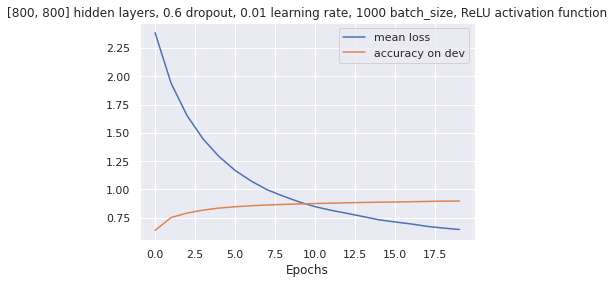

Starting epoch: 0
mean loss:  0.8612285426374054
dev accuracy:  0.9
Starting epoch: 1
mean loss:  0.3835272473841608
dev accuracy:  0.9194
Starting epoch: 2
mean loss:  0.31284310384226116
dev accuracy:  0.9288
Starting epoch: 3
mean loss:  0.2764156080577191
dev accuracy:  0.9344
Starting epoch: 4
mean loss:  0.25155350753804345
dev accuracy:  0.9395
Starting epoch: 5
mean loss:  0.2323941264015307
dev accuracy:  0.9426
Starting epoch: 6
mean loss:  0.21665793795436933
dev accuracy:  0.9456
Starting epoch: 7
mean loss:  0.20327167938979426
dev accuracy:  0.9486
Starting epoch: 8
mean loss:  0.19161948463508002
dev accuracy:  0.9513
Starting epoch: 9
mean loss:  0.18129173800061701
dev accuracy:  0.9539
Starting epoch: 10
mean loss:  0.17202252789212055
dev accuracy:  0.9557
Starting epoch: 11
mean loss:  0.1636455038627038
dev accuracy:  0.9575
Starting epoch: 12
mean loss:  0.15601232322342612
dev accuracy:  0.9585
Starting epoch: 13
mean loss:  0.14902151558786397
dev accuracy:  0.9

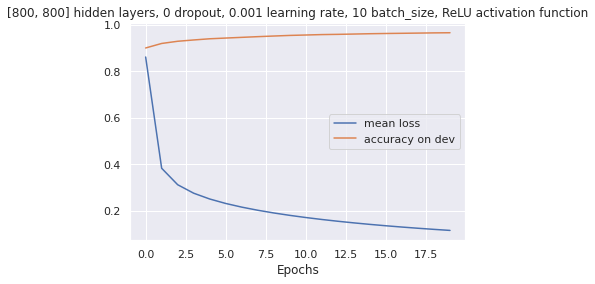

Starting epoch: 0
mean loss:  1.9382082064470607
dev accuracy:  0.687
Starting epoch: 1
mean loss:  1.340611804626183
dev accuracy:  0.8032
Starting epoch: 2
mean loss:  0.9949728921501936
dev accuracy:  0.8443
Starting epoch: 3
mean loss:  0.79820547489349
dev accuracy:  0.865
Starting epoch: 4
mean loss:  0.6784660757896667
dev accuracy:  0.8777
Starting epoch: 5
mean loss:  0.5997677615540709
dev accuracy:  0.8846
Starting epoch: 6
mean loss:  0.544608614223446
dev accuracy:  0.89
Starting epoch: 7
mean loss:  0.5039251118363021
dev accuracy:  0.895
Starting epoch: 8
mean loss:  0.4726571772031917
dev accuracy:  0.8994
Starting epoch: 9
mean loss:  0.4478171959727586
dev accuracy:  0.9029
Starting epoch: 10
mean loss:  0.4275493877019711
dev accuracy:  0.9061
Starting epoch: 11
mean loss:  0.4106382368924375
dev accuracy:  0.9074
Starting epoch: 12
mean loss:  0.3962579055163199
dev accuracy:  0.9099
Starting epoch: 13
mean loss:  0.3838345020890474
dev accuracy:  0.9117
Starting ep

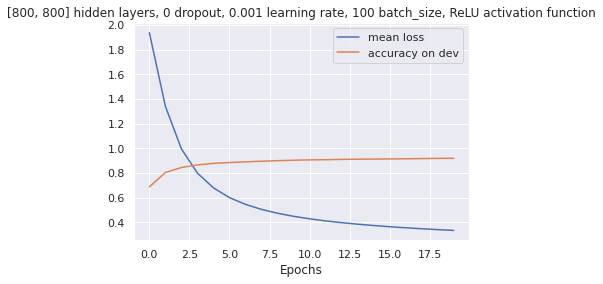

Starting epoch: 0
mean loss:  2.3353086639853085
dev accuracy:  0.1646
Starting epoch: 1
mean loss:  2.209873545403574
dev accuracy:  0.2491
Starting epoch: 2
mean loss:  2.1127194329804064
dev accuracy:  0.3585
Starting epoch: 3
mean loss:  2.0290384432848763
dev accuracy:  0.4494
Starting epoch: 4
mean loss:  1.9525641015931672
dev accuracy:  0.5179
Starting epoch: 5
mean loss:  1.8807002516353832
dev accuracy:  0.5715
Starting epoch: 6
mean loss:  1.812375405255486
dev accuracy:  0.6144
Starting epoch: 7
mean loss:  1.747108066783232
dev accuracy:  0.6488
Starting epoch: 8
mean loss:  1.6846689289691401
dev accuracy:  0.676
Starting epoch: 9
mean loss:  1.6249298652013142
dev accuracy:  0.6971
Starting epoch: 10
mean loss:  1.567806650610531
dev accuracy:  0.7157
Starting epoch: 11
mean loss:  1.513235973376854
dev accuracy:  0.7308
Starting epoch: 12
mean loss:  1.461173361422969
dev accuracy:  0.7456
Starting epoch: 13
mean loss:  1.411571231542849
dev accuracy:  0.7563
Starting e

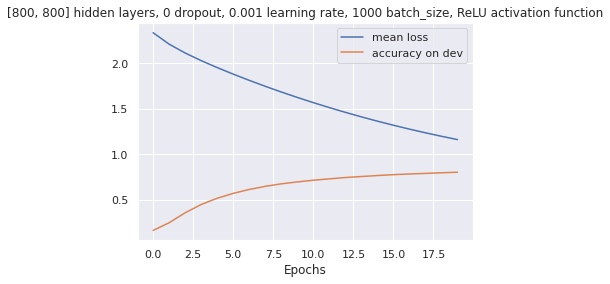

Starting epoch: 0
mean loss:  1.0224514496660762
dev accuracy:  0.8912
Starting epoch: 1
mean loss:  0.5033899374586288
dev accuracy:  0.9126
Starting epoch: 2
mean loss:  0.4137826854591398
dev accuracy:  0.9216
Starting epoch: 3
mean loss:  0.36741444254802436
dev accuracy:  0.9288
Starting epoch: 4
mean loss:  0.33548532674207143
dev accuracy:  0.9337
Starting epoch: 5
mean loss:  0.3099932837996679
dev accuracy:  0.9376
Starting epoch: 6
mean loss:  0.2905304466228589
dev accuracy:  0.9415
Starting epoch: 7
mean loss:  0.271204488044573
dev accuracy:  0.9449
Starting epoch: 8
mean loss:  0.2581557353953925
dev accuracy:  0.9487
Starting epoch: 9
mean loss:  0.24415271311755898
dev accuracy:  0.9509
Starting epoch: 10
mean loss:  0.230899890808497
dev accuracy:  0.9526
Starting epoch: 11
mean loss:  0.22227175348717476
dev accuracy:  0.9546
Starting epoch: 12
mean loss:  0.2159364238667524
dev accuracy:  0.9556
Starting epoch: 13
mean loss:  0.20633391284836738
dev accuracy:  0.9576

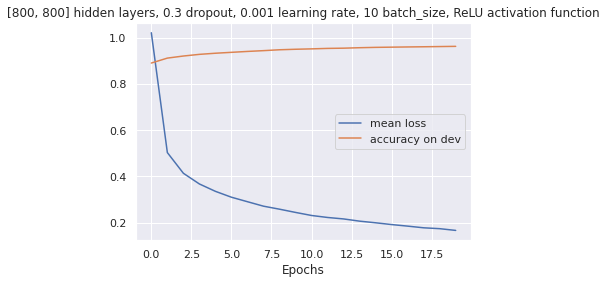

Starting epoch: 0
mean loss:  2.085946554433324
dev accuracy:  0.6944
Starting epoch: 1
mean loss:  1.5448109784763968
dev accuracy:  0.8034
Starting epoch: 2
mean loss:  1.2045738386536786
dev accuracy:  0.8368
Starting epoch: 3
mean loss:  0.9978249848721746
dev accuracy:  0.8561
Starting epoch: 4
mean loss:  0.860603884665552
dev accuracy:  0.8663
Starting epoch: 5
mean loss:  0.7703646404776506
dev accuracy:  0.8754
Starting epoch: 6
mean loss:  0.7069813253398903
dev accuracy:  0.8825
Starting epoch: 7
mean loss:  0.6614818134588634
dev accuracy:  0.8871
Starting epoch: 8
mean loss:  0.6239355445027114
dev accuracy:  0.8914
Starting epoch: 9
mean loss:  0.5946947584252158
dev accuracy:  0.8934
Starting epoch: 10
mean loss:  0.5658172852621821
dev accuracy:  0.8974
Starting epoch: 11
mean loss:  0.5466710092897663
dev accuracy:  0.9004
Starting epoch: 12
mean loss:  0.5314267282476445
dev accuracy:  0.9025
Starting epoch: 13
mean loss:  0.514083961288848
dev accuracy:  0.9043
Start

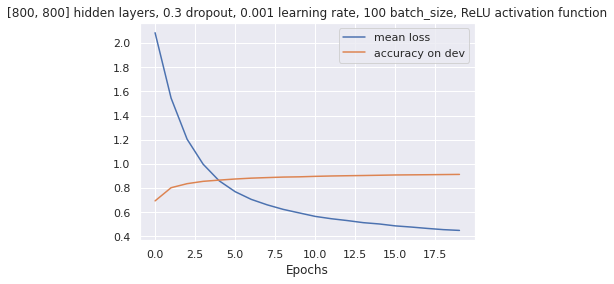

Starting epoch: 0
mean loss:  2.388135676290475
dev accuracy:  0.1349
Starting epoch: 1
mean loss:  2.269391265569949
dev accuracy:  0.2454
Starting epoch: 2
mean loss:  2.178469447528615
dev accuracy:  0.3597
Starting epoch: 3
mean loss:  2.109451406142291
dev accuracy:  0.4448
Starting epoch: 4
mean loss:  2.03529140995998
dev accuracy:  0.5141
Starting epoch: 5
mean loss:  1.972238395728317
dev accuracy:  0.5674
Starting epoch: 6
mean loss:  1.9131102024340163
dev accuracy:  0.6106
Starting epoch: 7
mean loss:  1.8553572963265812
dev accuracy:  0.6438
Starting epoch: 8
mean loss:  1.7983597096274881
dev accuracy:  0.6689
Starting epoch: 9
mean loss:  1.7475518268697403
dev accuracy:  0.6899
Starting epoch: 10
mean loss:  1.6929615852879543
dev accuracy:  0.7063
Starting epoch: 11
mean loss:  1.6439795283710255
dev accuracy:  0.7222
Starting epoch: 12
mean loss:  1.600447694460551
dev accuracy:  0.7371
Starting epoch: 13
mean loss:  1.5570862456864
dev accuracy:  0.7479
Starting epoc

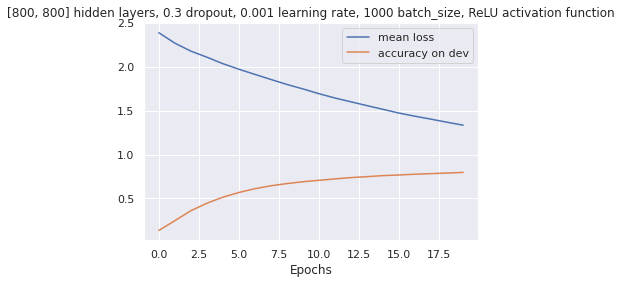

Starting epoch: 0
mean loss:  1.3887157716546814
dev accuracy:  0.8718
Starting epoch: 1
mean loss:  0.7458386817092992
dev accuracy:  0.8981
Starting epoch: 2
mean loss:  0.5992183433214329
dev accuracy:  0.9098
Starting epoch: 3
mean loss:  0.5211426636356458
dev accuracy:  0.9189
Starting epoch: 4
mean loss:  0.47480586873934677
dev accuracy:  0.9237
Starting epoch: 5
mean loss:  0.4365443382587249
dev accuracy:  0.9274
Starting epoch: 6
mean loss:  0.40596864596504617
dev accuracy:  0.9307
Starting epoch: 7
mean loss:  0.38699197187893863
dev accuracy:  0.9347
Starting epoch: 8
mean loss:  0.3641699896008465
dev accuracy:  0.9379
Starting epoch: 9
mean loss:  0.3494451319906094
dev accuracy:  0.9401
Starting epoch: 10
mean loss:  0.33239430332192477
dev accuracy:  0.9434
Starting epoch: 11
mean loss:  0.31842844876509335
dev accuracy:  0.9457
Starting epoch: 12
mean loss:  0.30652094756693865
dev accuracy:  0.9471
Starting epoch: 13
mean loss:  0.29702189191174894
dev accuracy:  0.

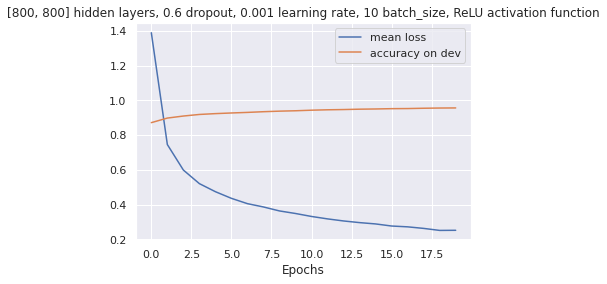

Starting epoch: 0
mean loss:  2.38177449070289
dev accuracy:  0.616
Starting epoch: 1
mean loss:  1.944768700057161
dev accuracy:  0.7373
Starting epoch: 2
mean loss:  1.6591967363319473
dev accuracy:  0.7895
Starting epoch: 3
mean loss:  1.455368105284944
dev accuracy:  0.8178
Starting epoch: 4
mean loss:  1.2976409491902579
dev accuracy:  0.835
Starting epoch: 5
mean loss:  1.1770267887505705
dev accuracy:  0.8468
Starting epoch: 6
mean loss:  1.0798535243479792
dev accuracy:  0.8546
Starting epoch: 7
mean loss:  1.004845287509545
dev accuracy:  0.8626
Starting epoch: 8
mean loss:  0.9461292186659015
dev accuracy:  0.8686
Starting epoch: 9
mean loss:  0.9058610131878577
dev accuracy:  0.8723
Starting epoch: 10
mean loss:  0.8611303082483257
dev accuracy:  0.8766
Starting epoch: 11
mean loss:  0.8243502134572485
dev accuracy:  0.8803
Starting epoch: 12
mean loss:  0.796591606504189
dev accuracy:  0.8834
Starting epoch: 13
mean loss:  0.7649276729472383
dev accuracy:  0.8854
Starting e

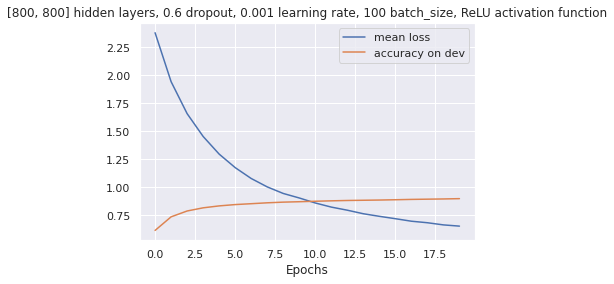

Starting epoch: 0
mean loss:  2.730026502235263
dev accuracy:  0.2004
Starting epoch: 1
mean loss:  2.6094806755290314
dev accuracy:  0.266
Starting epoch: 2
mean loss:  2.5206326176138485
dev accuracy:  0.3354
Starting epoch: 3
mean loss:  2.454863623076794
dev accuracy:  0.4021
Starting epoch: 4
mean loss:  2.3827679718241974
dev accuracy:  0.4581
Starting epoch: 5
mean loss:  2.324784863228891
dev accuracy:  0.5054
Starting epoch: 6
mean loss:  2.2752229232414094
dev accuracy:  0.5498
Starting epoch: 7
mean loss:  2.2158106822593537
dev accuracy:  0.5827
Starting epoch: 8
mean loss:  2.1706346764284024
dev accuracy:  0.6142
Starting epoch: 9
mean loss:  2.1231947178934134
dev accuracy:  0.6403
Starting epoch: 10
mean loss:  2.0756610141080967
dev accuracy:  0.6614
Starting epoch: 11
mean loss:  2.0440464323642207
dev accuracy:  0.6782
Starting epoch: 12
mean loss:  1.9994935942631142
dev accuracy:  0.6916
Starting epoch: 13
mean loss:  1.9666891635632981
dev accuracy:  0.7049
Starti

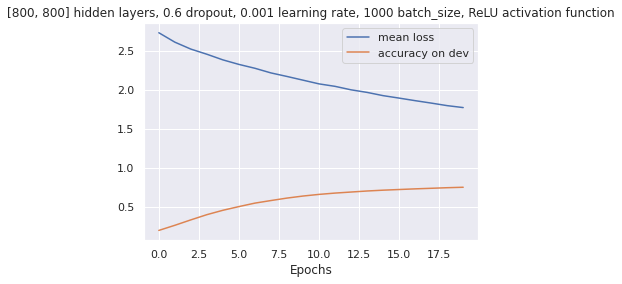

In [0]:
layer_dims_testing = [[800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.3, 0.6]
learning_rates = [0.1, 0.01, 0.001]
models_list_extra = []
mean_loss_list_extra = []
dev_accuracy_list_extra = []

EPOCHS = 20
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = ReluMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list_extra.append(model)
                mean_loss_list_extra.append(mean_losses)
                dev_accuracy_list_extra.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "ReLU")

In [0]:
class SigmoidMLP(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_value):
        super(SigmoidMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_dims[0]))
        layers.append(nn.Sigmoid())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[0], layer_dims[1]))
        layers.append(nn.Sigmoid())
        for i in range(len(layer_dims)-2):
            layers.append(nn.Dropout(dropout_value))
            layers.append(nn.Linear(layer_dims[i+1], layer_dims[i+2]))
            layers.append(nn.Sigmoid())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[-1], 10))
        self.seq = nn.Sequential(*layers)
      
            
    def forward(self, inputs):
        return self.seq(inputs)

Starting epoch: 0
mean loss:  0.5613274199668734
dev accuracy:  0.9113
Starting epoch: 1
mean loss:  0.2891291234737429
dev accuracy:  0.9296
Starting epoch: 2
mean loss:  0.22746443830842442
dev accuracy:  0.9411
Starting epoch: 3
mean loss:  0.18682371263979444
dev accuracy:  0.9493
Starting epoch: 4
mean loss:  0.15820791709162868
dev accuracy:  0.9548
Starting epoch: 5
mean loss:  0.13640252066200667
dev accuracy:  0.9578
Starting epoch: 6
mean loss:  0.11928941872264619
dev accuracy:  0.9603
Starting epoch: 7
mean loss:  0.1054694551578546
dev accuracy:  0.9626
Starting epoch: 8
mean loss:  0.09402505856891824
dev accuracy:  0.9654
Starting epoch: 9
mean loss:  0.08432122251386204
dev accuracy:  0.9673


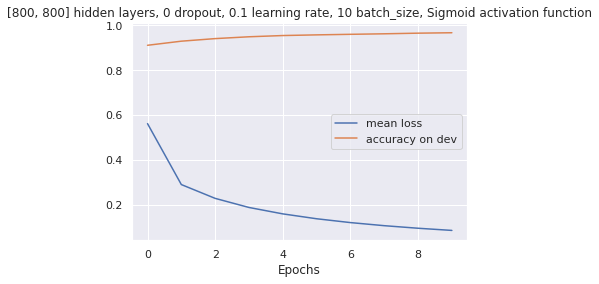

Starting epoch: 0
mean loss:  1.3763956723812811
dev accuracy:  0.835
Starting epoch: 1
mean loss:  0.5035804289424729
dev accuracy:  0.8907
Starting epoch: 2
mean loss:  0.3979961748073201
dev accuracy:  0.9017
Starting epoch: 3
mean loss:  0.3601145862402792
dev accuracy:  0.9087
Starting epoch: 4
mean loss:  0.3388419337198882
dev accuracy:  0.913
Starting epoch: 5
mean loss:  0.32445695383582046
dev accuracy:  0.9167
Starting epoch: 6
mean loss:  0.3136421492743397
dev accuracy:  0.9192
Starting epoch: 7
mean loss:  0.30486996674133154
dev accuracy:  0.9206
Starting epoch: 8
mean loss:  0.2973343122921542
dev accuracy:  0.9216
Starting epoch: 9
mean loss:  0.29057069189712675
dev accuracy:  0.9235


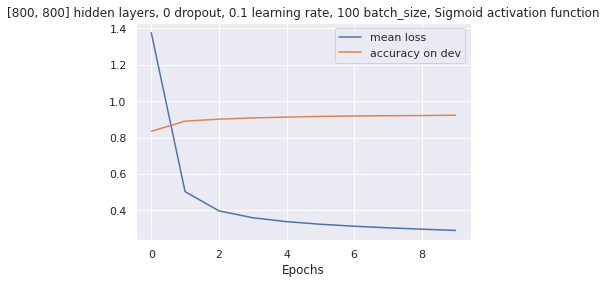

Starting epoch: 0
mean loss:  2.368155890820073
dev accuracy:  0.2034
Starting epoch: 1
mean loss:  2.0459422060087618
dev accuracy:  0.2766
Starting epoch: 2
mean loss:  1.752520577580321
dev accuracy:  0.5328
Starting epoch: 3
mean loss:  1.4333524563733269
dev accuracy:  0.6549
Starting epoch: 4
mean loss:  1.1547135184792912
dev accuracy:  0.7162
Starting epoch: 5
mean loss:  0.955270831491433
dev accuracy:  0.7599
Starting epoch: 6
mean loss:  0.8178868036644131
dev accuracy:  0.7979
Starting epoch: 7
mean loss:  0.7217255608708251
dev accuracy:  0.8268
Starting epoch: 8
mean loss:  0.6515726832782521
dev accuracy:  0.8476
Starting epoch: 9
mean loss:  0.5986711032250348
dev accuracy:  0.8614


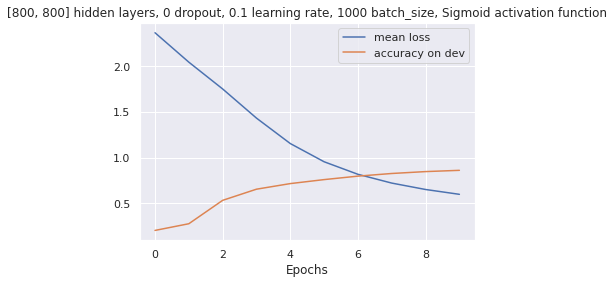

Starting epoch: 0
mean loss:  0.6548076288909066
dev accuracy:  0.9184
Starting epoch: 1
mean loss:  0.3354658556968373
dev accuracy:  0.9337
Starting epoch: 2
mean loss:  0.27053132302782273
dev accuracy:  0.9426
Starting epoch: 3
mean loss:  0.22810712839102262
dev accuracy:  0.9526
Starting epoch: 4
mean loss:  0.19959360977881632
dev accuracy:  0.9566
Starting epoch: 5
mean loss:  0.17705588502138941
dev accuracy:  0.9595
Starting epoch: 6
mean loss:  0.16164240244202616
dev accuracy:  0.9636
Starting epoch: 7
mean loss:  0.14625882546467486
dev accuracy:  0.9658
Starting epoch: 8
mean loss:  0.13592965078344352
dev accuracy:  0.9658
Starting epoch: 9
mean loss:  0.12313436706614156
dev accuracy:  0.9689


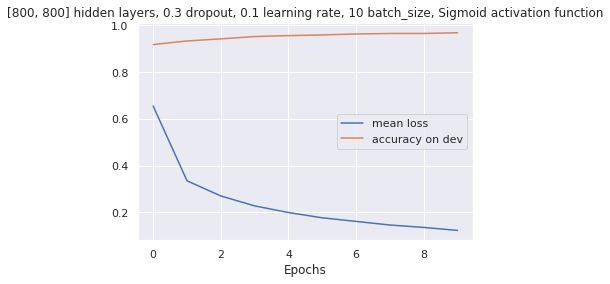

Starting epoch: 0
mean loss:  1.5544457536733556
dev accuracy:  0.8265
Starting epoch: 1
mean loss:  0.6794058609151554
dev accuracy:  0.8747
Starting epoch: 2
mean loss:  0.5366038353500252
dev accuracy:  0.8968
Starting epoch: 3
mean loss:  0.4803159880245517
dev accuracy:  0.9031
Starting epoch: 4
mean loss:  0.4437939576105681
dev accuracy:  0.9075
Starting epoch: 5
mean loss:  0.4225958127996879
dev accuracy:  0.9109
Starting epoch: 6
mean loss:  0.4023425373548043
dev accuracy:  0.9132
Starting epoch: 7
mean loss:  0.3856273961519291
dev accuracy:  0.9173
Starting epoch: 8
mean loss:  0.37587716125561565
dev accuracy:  0.9195
Starting epoch: 9
mean loss:  0.3615571023401862
dev accuracy:  0.9206


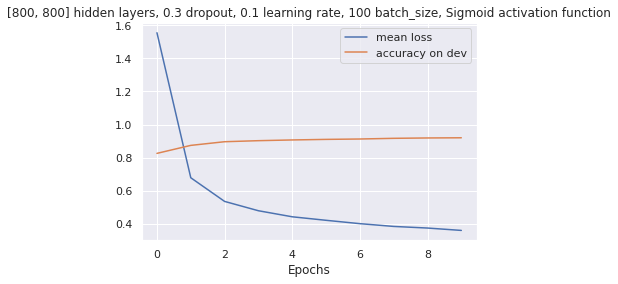

Starting epoch: 0
mean loss:  2.4370129061680212
dev accuracy:  0.1855
Starting epoch: 1
mean loss:  2.1485870305229637
dev accuracy:  0.3072
Starting epoch: 2
mean loss:  1.932858331530702
dev accuracy:  0.5143
Starting epoch: 3
mean loss:  1.6948816449034447
dev accuracy:  0.6599
Starting epoch: 4
mean loss:  1.4593101389267866
dev accuracy:  0.7337
Starting epoch: 5
mean loss:  1.2538112962947172
dev accuracy:  0.7695
Starting epoch: 6
mean loss:  1.1035382771024518
dev accuracy:  0.7998
Starting epoch: 7
mean loss:  0.9894819002525479
dev accuracy:  0.8207
Starting epoch: 8
mean loss:  0.9037153861101936
dev accuracy:  0.8336
Starting epoch: 9
mean loss:  0.8354087752454421
dev accuracy:  0.8481


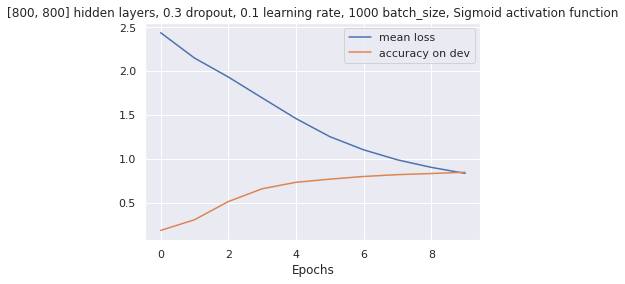

Starting epoch: 0
mean loss:  0.8221128873915893
dev accuracy:  0.9126
Starting epoch: 1
mean loss:  0.419968417100478
dev accuracy:  0.9253
Starting epoch: 2
mean loss:  0.3472482917360683
dev accuracy:  0.9396
Starting epoch: 3
mean loss:  0.3037272332689122
dev accuracy:  0.9452
Starting epoch: 4
mean loss:  0.27095984762794845
dev accuracy:  0.9519
Starting epoch: 5
mean loss:  0.24593520251108705
dev accuracy:  0.9565
Starting epoch: 6
mean loss:  0.22738198445865654
dev accuracy:  0.9584
Starting epoch: 7
mean loss:  0.21393705625978585
dev accuracy:  0.9609
Starting epoch: 8
mean loss:  0.1983623087926815
dev accuracy:  0.9652
Starting epoch: 9
mean loss:  0.1869485965125703
dev accuracy:  0.9653


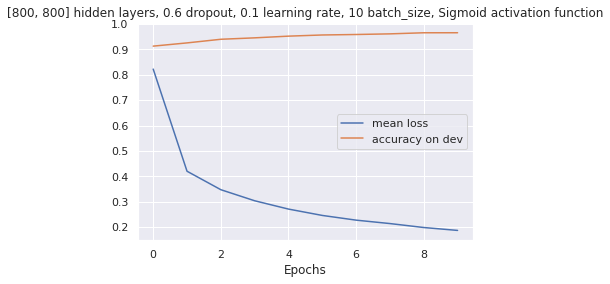

Starting epoch: 0
mean loss:  1.911379691607462
dev accuracy:  0.7766
Starting epoch: 1
mean loss:  1.010347925498338
dev accuracy:  0.8537
Starting epoch: 2
mean loss:  0.7603517214576165
dev accuracy:  0.8724
Starting epoch: 3
mean loss:  0.6562670679268485
dev accuracy:  0.8853
Starting epoch: 4
mean loss:  0.5965538940386858
dev accuracy:  0.8925
Starting epoch: 5
mean loss:  0.5553357271020284
dev accuracy:  0.8972
Starting epoch: 6
mean loss:  0.5196956312228106
dev accuracy:  0.9003
Starting epoch: 7
mean loss:  0.4980476591996328
dev accuracy:  0.905
Starting epoch: 8
mean loss:  0.47944653477378474
dev accuracy:  0.9072
Starting epoch: 9
mean loss:  0.4602471985026986
dev accuracy:  0.9091


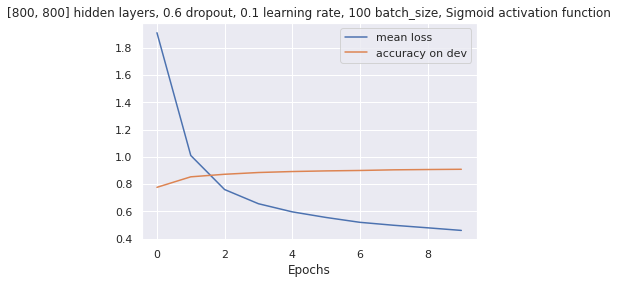

Starting epoch: 0
mean loss:  2.5567796464059867
dev accuracy:  0.1962
Starting epoch: 1
mean loss:  2.3023793977849625
dev accuracy:  0.3038
Starting epoch: 2
mean loss:  2.155941313388301
dev accuracy:  0.3925
Starting epoch: 3
mean loss:  2.040092482286341
dev accuracy:  0.5527
Starting epoch: 4
mean loss:  1.913673571511811
dev accuracy:  0.6479
Starting epoch: 5
mean loss:  1.776458651411767
dev accuracy:  0.6732
Starting epoch: 6
mean loss:  1.6388412106270884
dev accuracy:  0.7151
Starting epoch: 7
mean loss:  1.509610419179879
dev accuracy:  0.739
Starting epoch: 8
mean loss:  1.3907562190411138
dev accuracy:  0.7768
Starting epoch: 9
mean loss:  1.2922799844367832
dev accuracy:  0.7756


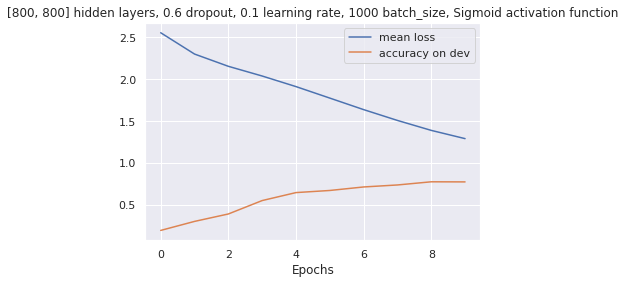

Starting epoch: 0
mean loss:  1.2469615727511079
dev accuracy:  0.8692
Starting epoch: 1
mean loss:  0.4873700356306469
dev accuracy:  0.8995
Starting epoch: 2
mean loss:  0.3911769063705666
dev accuracy:  0.9074
Starting epoch: 3
mean loss:  0.3553510935626249
dev accuracy:  0.9114
Starting epoch: 4
mean loss:  0.3352666489688325
dev accuracy:  0.9138
Starting epoch: 5
mean loss:  0.32175803558043936
dev accuracy:  0.9174
Starting epoch: 6
mean loss:  0.311635717967854
dev accuracy:  0.9189
Starting epoch: 7
mean loss:  0.3034397694996415
dev accuracy:  0.9193
Starting epoch: 8
mean loss:  0.2964045920680595
dev accuracy:  0.9202
Starting epoch: 9
mean loss:  0.29009062205652664
dev accuracy:  0.9218


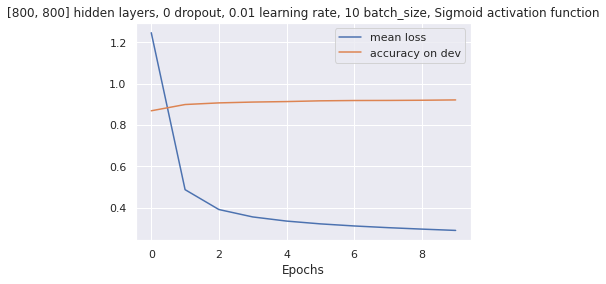

Starting epoch: 0
mean loss:  2.2103569174479105
dev accuracy:  0.3226
Starting epoch: 1
mean loss:  1.9977502768149158
dev accuracy:  0.5551
Starting epoch: 2
mean loss:  1.7197956348845582
dev accuracy:  0.702
Starting epoch: 3
mean loss:  1.404229690214831
dev accuracy:  0.7768
Starting epoch: 4
mean loss:  1.132759172045542
dev accuracy:  0.8136
Starting epoch: 5
mean loss:  0.9393287692479269
dev accuracy:  0.8365
Starting epoch: 6
mean loss:  0.8078661883424618
dev accuracy:  0.848
Starting epoch: 7
mean loss:  0.7162577355217316
dev accuracy:  0.8585
Starting epoch: 8
mean loss:  0.6498201296120109
dev accuracy:  0.866
Starting epoch: 9
mean loss:  0.5998198782612464
dev accuracy:  0.8724


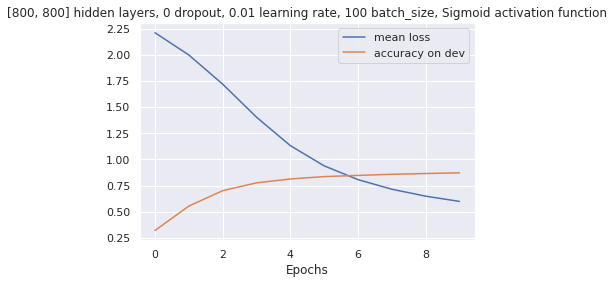

Starting epoch: 0
mean loss:  2.267254997702206
dev accuracy:  0.1969
Starting epoch: 1
mean loss:  2.2263376058316697
dev accuracy:  0.2373
Starting epoch: 2
mean loss:  2.207346200942993
dev accuracy:  0.2697
Starting epoch: 3
mean loss:  2.188329575108547
dev accuracy:  0.2986
Starting epoch: 4
mean loss:  2.1692022342307893
dev accuracy:  0.3315
Starting epoch: 5
mean loss:  2.1498835227068733
dev accuracy:  0.3659
Starting epoch: 6
mean loss:  2.1302971372417376
dev accuracy:  0.4011
Starting epoch: 7
mean loss:  2.1103715429119037
dev accuracy:  0.4331
Starting epoch: 8
mean loss:  2.0900394449047015
dev accuracy:  0.4623
Starting epoch: 9
mean loss:  2.069238443000644
dev accuracy:  0.4905


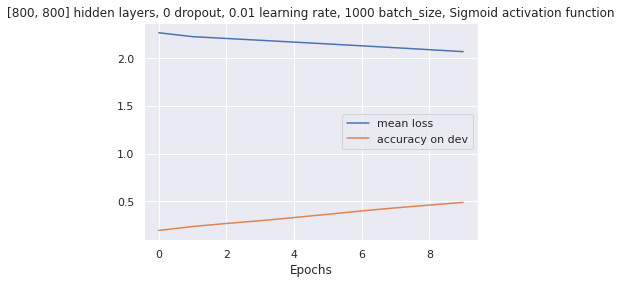

Starting epoch: 0
mean loss:  1.4970163086924975
dev accuracy:  0.8478
Starting epoch: 1
mean loss:  0.6812555183978873
dev accuracy:  0.8885
Starting epoch: 2
mean loss:  0.5370355978581315
dev accuracy:  0.8986
Starting epoch: 3
mean loss:  0.4799478744461885
dev accuracy:  0.9029
Starting epoch: 4
mean loss:  0.44121437008576264
dev accuracy:  0.9073
Starting epoch: 5
mean loss:  0.41861972011591503
dev accuracy:  0.9114
Starting epoch: 6
mean loss:  0.40149181052428606
dev accuracy:  0.9134
Starting epoch: 7
mean loss:  0.38625072897779683
dev accuracy:  0.9174
Starting epoch: 8
mean loss:  0.37162692953792037
dev accuracy:  0.9187
Starting epoch: 9
mean loss:  0.3617088265865639
dev accuracy:  0.9213


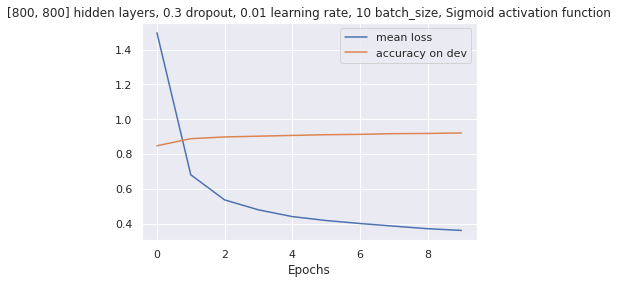

Starting epoch: 0
mean loss:  2.3299341963198845
dev accuracy:  0.3081
Starting epoch: 1
mean loss:  2.15812190849624
dev accuracy:  0.4629
Starting epoch: 2
mean loss:  1.9649547436042223
dev accuracy:  0.6395
Starting epoch: 3
mean loss:  1.7438797274987379
dev accuracy:  0.7056
Starting epoch: 4
mean loss:  1.5052659247449771
dev accuracy:  0.7692
Starting epoch: 5
mean loss:  1.298463339577178
dev accuracy:  0.7996
Starting epoch: 6
mean loss:  1.1361509053531045
dev accuracy:  0.8188
Starting epoch: 7
mean loss:  1.0115963211078605
dev accuracy:  0.8313
Starting epoch: 8
mean loss:  0.9233852352448804
dev accuracy:  0.842
Starting epoch: 9
mean loss:  0.8563119139737949
dev accuracy:  0.8489


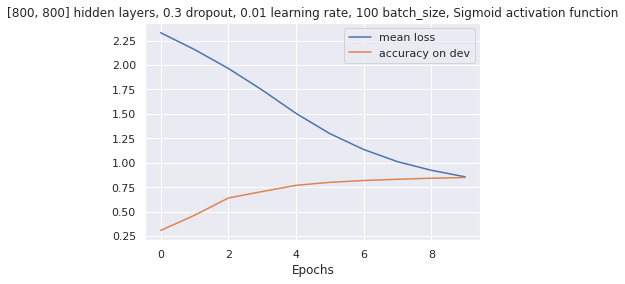

Starting epoch: 0
mean loss:  2.373337605420281
dev accuracy:  0.1991
Starting epoch: 1
mean loss:  2.3341458217770445
dev accuracy:  0.2464
Starting epoch: 2
mean loss:  2.3185259594636807
dev accuracy:  0.2602
Starting epoch: 3
mean loss:  2.2989070415496826
dev accuracy:  0.299
Starting epoch: 4
mean loss:  2.2816153975094067
dev accuracy:  0.3239
Starting epoch: 5
mean loss:  2.2618243647556677
dev accuracy:  0.3456
Starting epoch: 6
mean loss:  2.2503501574198403
dev accuracy:  0.3708
Starting epoch: 7
mean loss:  2.224045529085047
dev accuracy:  0.3898
Starting epoch: 8
mean loss:  2.2078395965052584
dev accuracy:  0.4433
Starting epoch: 9
mean loss:  2.1938420838000727
dev accuracy:  0.4524


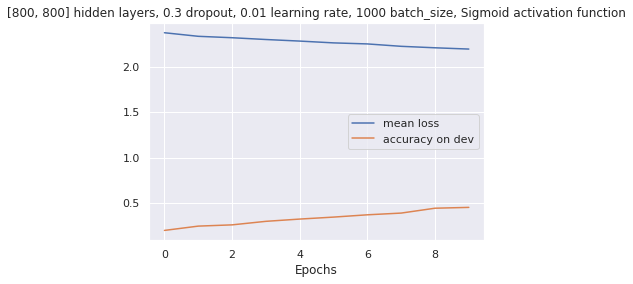

Starting epoch: 0
mean loss:  1.9273124264552817
dev accuracy:  0.7848
Starting epoch: 1
mean loss:  1.0198892885429862
dev accuracy:  0.8514
Starting epoch: 2
mean loss:  0.7651762052628547
dev accuracy:  0.8744
Starting epoch: 3
mean loss:  0.657273884636209
dev accuracy:  0.8874
Starting epoch: 4
mean loss:  0.5929853234948861
dev accuracy:  0.8938
Starting epoch: 5
mean loss:  0.5554345113662357
dev accuracy:  0.8987
Starting epoch: 6
mean loss:  0.5223690416146918
dev accuracy:  0.9026
Starting epoch: 7
mean loss:  0.4958906394437513
dev accuracy:  0.9052
Starting epoch: 8
mean loss:  0.4762218862707181
dev accuracy:  0.9086
Starting epoch: 9
mean loss:  0.46086064900758206
dev accuracy:  0.9107


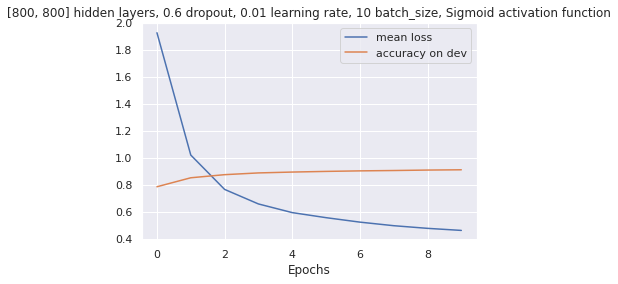

Starting epoch: 0
mean loss:  2.5556132598313503
dev accuracy:  0.2777
Starting epoch: 1
mean loss:  2.3397494366544924
dev accuracy:  0.3485
Starting epoch: 2
mean loss:  2.202857864117194
dev accuracy:  0.5201
Starting epoch: 3
mean loss:  2.0871234109063823
dev accuracy:  0.5985
Starting epoch: 4
mean loss:  1.9640537172020553
dev accuracy:  0.6656
Starting epoch: 5
mean loss:  1.829618738558954
dev accuracy:  0.6987
Starting epoch: 6
mean loss:  1.6870668453132798
dev accuracy:  0.7255
Starting epoch: 7
mean loss:  1.5394295325536214
dev accuracy:  0.7409
Starting epoch: 8
mean loss:  1.4332676033773821
dev accuracy:  0.7682
Starting epoch: 9
mean loss:  1.3315894223020939
dev accuracy:  0.7768


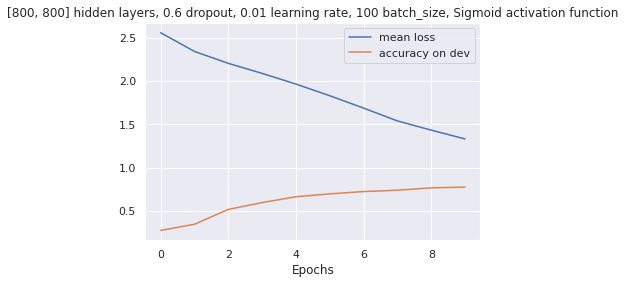

Starting epoch: 0
mean loss:  2.6611238273919797
dev accuracy:  0.1373
Starting epoch: 1
mean loss:  2.603615961822809
dev accuracy:  0.1958
Starting epoch: 2
mean loss:  2.5656659977108824
dev accuracy:  0.2613
Starting epoch: 3
mean loss:  2.532966791414747
dev accuracy:  0.3443
Starting epoch: 4
mean loss:  2.509303756788665
dev accuracy:  0.3579
Starting epoch: 5
mean loss:  2.4684018387514004
dev accuracy:  0.3762
Starting epoch: 6
mean loss:  2.4521019879509423
dev accuracy:  0.3815
Starting epoch: 7
mean loss:  2.4309052205553243
dev accuracy:  0.4076
Starting epoch: 8
mean loss:  2.4054777435227934
dev accuracy:  0.4307
Starting epoch: 9
mean loss:  2.3835054051642324
dev accuracy:  0.4456


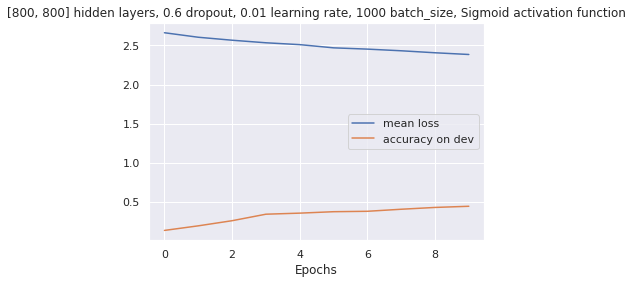

Starting epoch: 0
mean loss:  2.2020820394274567
dev accuracy:  0.328
Starting epoch: 1
mean loss:  1.9877851995270959
dev accuracy:  0.548
Starting epoch: 2
mean loss:  1.7081179529207988
dev accuracy:  0.6955
Starting epoch: 3
mean loss:  1.398350037591168
dev accuracy:  0.7668
Starting epoch: 4
mean loss:  1.1352921716989552
dev accuracy:  0.807
Starting epoch: 5
mean loss:  0.9458423407524497
dev accuracy:  0.8309
Starting epoch: 6
mean loss:  0.8152046483877873
dev accuracy:  0.8418
Starting epoch: 7
mean loss:  0.7235328000149853
dev accuracy:  0.8505
Starting epoch: 8
mean loss:  0.6568692659728648
dev accuracy:  0.8596
Starting epoch: 9
mean loss:  0.6065677132899225
dev accuracy:  0.8679


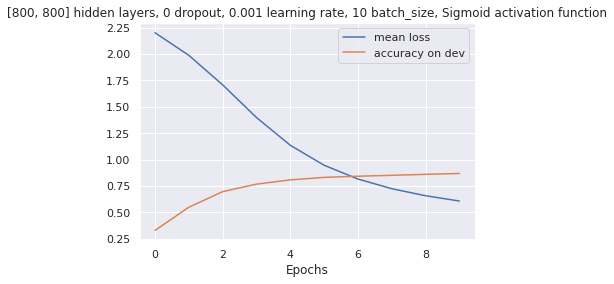

Starting epoch: 0
mean loss:  2.299125917419464
dev accuracy:  0.1336
Starting epoch: 1
mean loss:  2.273829209352444
dev accuracy:  0.19
Starting epoch: 2
mean loss:  2.2552347754290003
dev accuracy:  0.2508
Starting epoch: 3
mean loss:  2.2366708705049314
dev accuracy:  0.3005
Starting epoch: 4
mean loss:  2.2180520231852277
dev accuracy:  0.3432
Starting epoch: 5
mean loss:  2.1992972696612694
dev accuracy:  0.3796
Starting epoch: 6
mean loss:  2.180329427033841
dev accuracy:  0.4134
Starting epoch: 7
mean loss:  2.1610747530550776
dev accuracy:  0.446
Starting epoch: 8
mean loss:  2.1414627605331633
dev accuracy:  0.4789
Starting epoch: 9
mean loss:  2.121426112161663
dev accuracy:  0.5073


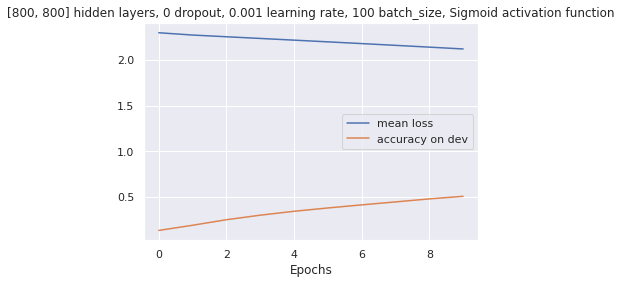

Starting epoch: 0
mean loss:  2.3178240551668057
dev accuracy:  0.1162
Starting epoch: 1
mean loss:  2.2522490866043987
dev accuracy:  0.1124
Starting epoch: 2
mean loss:  2.2427067569657866
dev accuracy:  0.1219
Starting epoch: 3
mean loss:  2.2399989483403226
dev accuracy:  0.1307
Starting epoch: 4
mean loss:  2.2380293303844976
dev accuracy:  0.1363
Starting epoch: 5
mean loss:  2.236141686346017
dev accuracy:  0.1417
Starting epoch: 6
mean loss:  2.2342664540982713
dev accuracy:  0.1472
Starting epoch: 7
mean loss:  2.2323945456860113
dev accuracy:  0.153
Starting epoch: 8
mean loss:  2.2305244838490204
dev accuracy:  0.1588
Starting epoch: 9
mean loss:  2.2286557450014004
dev accuracy:  0.1646


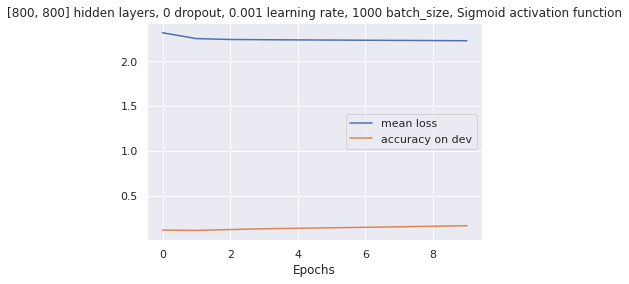

Starting epoch: 0
mean loss:  2.3351007534298653
dev accuracy:  0.286
Starting epoch: 1
mean loss:  2.147957559753194
dev accuracy:  0.4884
Starting epoch: 2
mean loss:  1.9454177469998402
dev accuracy:  0.6491
Starting epoch: 3
mean loss:  1.7057968256259484
dev accuracy:  0.7299
Starting epoch: 4
mean loss:  1.469013681652021
dev accuracy:  0.7814
Starting epoch: 5
mean loss:  1.2690351501724
dev accuracy:  0.804
Starting epoch: 6
mean loss:  1.111167029252507
dev accuracy:  0.8226
Starting epoch: 7
mean loss:  0.9986830873325857
dev accuracy:  0.8365
Starting epoch: 8
mean loss:  0.9113887813634287
dev accuracy:  0.8419
Starting epoch: 9
mean loss:  0.8435611323913653
dev accuracy:  0.8495


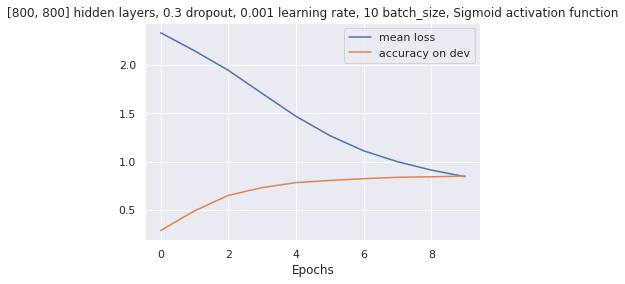

Starting epoch: 0
mean loss:  2.4130583623212254
dev accuracy:  0.1643
Starting epoch: 1
mean loss:  2.38831608642837
dev accuracy:  0.2158
Starting epoch: 2
mean loss:  2.3679229989499153
dev accuracy:  0.2658
Starting epoch: 3
mean loss:  2.3553950786590576
dev accuracy:  0.2886
Starting epoch: 4
mean loss:  2.334103895518594
dev accuracy:  0.326
Starting epoch: 5
mean loss:  2.320108702558719
dev accuracy:  0.3542
Starting epoch: 6
mean loss:  2.2959218229838236
dev accuracy:  0.3728
Starting epoch: 7
mean loss:  2.2836771054182226
dev accuracy:  0.408
Starting epoch: 8
mean loss:  2.2620382742015663
dev accuracy:  0.4317
Starting epoch: 9
mean loss:  2.24702148665925
dev accuracy:  0.4576


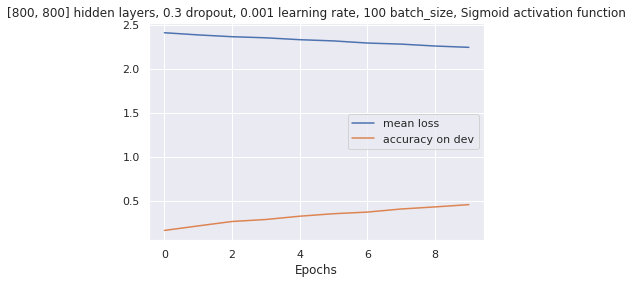

Starting epoch: 0
mean loss:  2.4511192312427594
dev accuracy:  0.0984
Starting epoch: 1
mean loss:  2.380654624864167
dev accuracy:  0.1278
Starting epoch: 2
mean loss:  2.3746197831396962
dev accuracy:  0.1195
Starting epoch: 3
mean loss:  2.3654690910788143
dev accuracy:  0.1139
Starting epoch: 4
mean loss:  2.365305180643119
dev accuracy:  0.1132
Starting epoch: 5
mean loss:  2.365095250746783
dev accuracy:  0.1175
Starting epoch: 6
mean loss:  2.3599121430340935
dev accuracy:  0.1221
Starting epoch: 7
mean loss:  2.363672737981759
dev accuracy:  0.12
Starting epoch: 8
mean loss:  2.360999350454293
dev accuracy:  0.1233
Starting epoch: 9
mean loss:  2.3588960451238297
dev accuracy:  0.1255


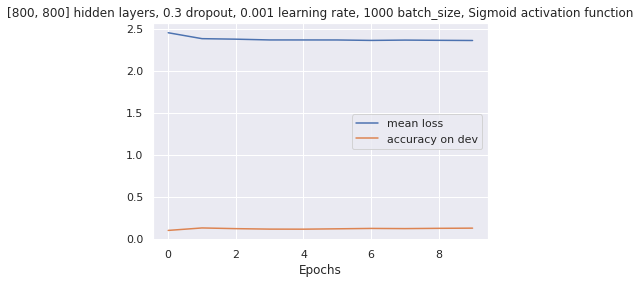

Starting epoch: 0
mean loss:  2.563394700091163
dev accuracy:  0.291
Starting epoch: 1
mean loss:  2.3417556810989257
dev accuracy:  0.3749
Starting epoch: 2
mean loss:  2.208875114620745
dev accuracy:  0.5118
Starting epoch: 3
mean loss:  2.089958686943985
dev accuracy:  0.6061
Starting epoch: 4
mean loss:  1.967639268219316
dev accuracy:  0.6693
Starting epoch: 5
mean loss:  1.8277020537836555
dev accuracy:  0.694
Starting epoch: 6
mean loss:  1.6828362502185994
dev accuracy:  0.7366
Starting epoch: 7
mean loss:  1.5420872952265396
dev accuracy:  0.7522
Starting epoch: 8
mean loss:  1.429325138740696
dev accuracy:  0.7631
Starting epoch: 9
mean loss:  1.3287903068244897
dev accuracy:  0.7735


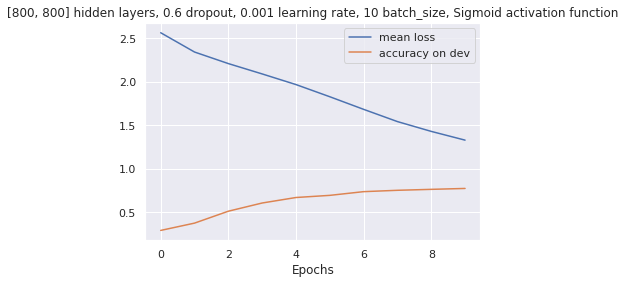

Starting epoch: 0
mean loss:  2.7089967975121536
dev accuracy:  0.1502
Starting epoch: 1
mean loss:  2.66377788627457
dev accuracy:  0.24
Starting epoch: 2
mean loss:  2.6240492390539356
dev accuracy:  0.2686
Starting epoch: 3
mean loss:  2.5810879376120197
dev accuracy:  0.2944
Starting epoch: 4
mean loss:  2.5503231060957003
dev accuracy:  0.3369
Starting epoch: 5
mean loss:  2.5214254584854947
dev accuracy:  0.3591
Starting epoch: 6
mean loss:  2.4973475285870825
dev accuracy:  0.3806
Starting epoch: 7
mean loss:  2.4703773714587123
dev accuracy:  0.4196
Starting epoch: 8
mean loss:  2.4559589698167144
dev accuracy:  0.4218
Starting epoch: 9
mean loss:  2.423769657245415
dev accuracy:  0.4428


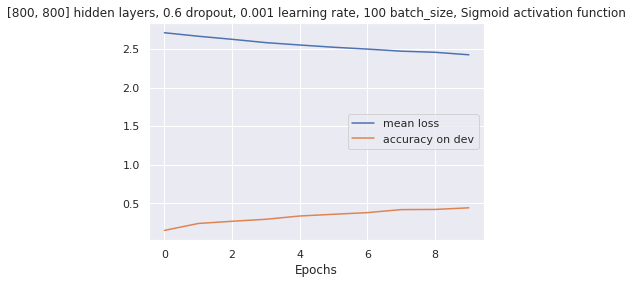

Starting epoch: 0
mean loss:  2.699634916642133
dev accuracy:  0.1029
Starting epoch: 1
mean loss:  2.649269506043079
dev accuracy:  0.1169
Starting epoch: 2
mean loss:  2.645145565855737
dev accuracy:  0.1119
Starting epoch: 3
mean loss:  2.636797872244143
dev accuracy:  0.1085
Starting epoch: 4
mean loss:  2.632315289740469
dev accuracy:  0.1095
Starting epoch: 5
mean loss:  2.6268102468228807
dev accuracy:  0.1092
Starting epoch: 6
mean loss:  2.622836945103664
dev accuracy:  0.1094
Starting epoch: 7
mean loss:  2.6248058571535
dev accuracy:  0.1105
Starting epoch: 8
mean loss:  2.6175602136873732
dev accuracy:  0.1108
Starting epoch: 9
mean loss:  2.609467529783062
dev accuracy:  0.1109


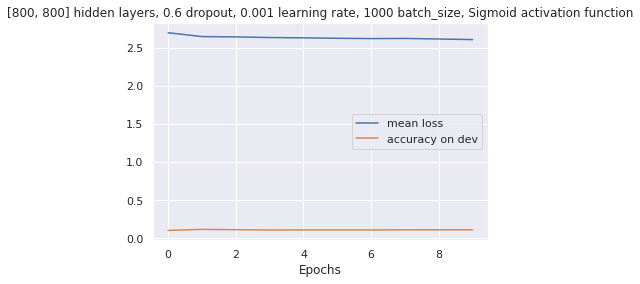

In [0]:
layer_dims_testing = [[800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.3, 0.6]
learning_rates = [0.1, 0.01, 0.001]
models_list = []
mean_loss_list = []
dev_accuracy_list = []

EPOCHS = 10
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = SigmoidMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list.append(model)
                mean_loss_list.append(mean_losses)
                dev_accuracy_list.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "Sigmoid")

In [0]:
class TanhMLP(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_value):
        super(TanhMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_dims[0]))
        layers.append(nn.Tanh())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[0], layer_dims[1]))
        layers.append(nn.Tanh())
        for i in range(len(layer_dims)-2):
            layers.append(nn.Dropout(dropout_value))
            layers.append(nn.Linear(layer_dims[i+1], layer_dims[i+2]))
            layers.append(nn.Tanh())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[-1], 10))
        self.seq = nn.Sequential(*layers)
            
    def forward(self, inputs):
        return self.seq(inputs)

#### In order to run a more elaborate test, the cell below can be run, though I recommend saving the time and going to the cell below.

In [0]:
layer_dims_testing = [[128, 128], [128,64,32,16], [256,128,64,32,16], [512,256,128,64,32,16]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
models_list_tanh = []
mean_loss_list_tanh = []
dev_accuracy_list_tanh = []

EPOCHS = 20
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = TanhMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list_tanh.append(model)
                mean_loss_list_tanh.append(mean_losses)
                dev_accuracy_list_tanh.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "TanhMLP")

Starting epoch: 0
mean loss:  0.34604704572590905
dev accuracy:  0.9244
Starting epoch: 1
mean loss:  0.16238488962235662
dev accuracy:  0.9556
Starting epoch: 2
mean loss:  0.10461942339522151
dev accuracy:  0.9555
Starting epoch: 3
mean loss:  0.07772398350428365
dev accuracy:  0.9709
Starting epoch: 4
mean loss:  0.0584518043642587
dev accuracy:  0.965
Starting epoch: 5
mean loss:  0.04361117161513575
dev accuracy:  0.9713
Starting epoch: 6
mean loss:  0.028377076861713653
dev accuracy:  0.9715
Starting epoch: 7
mean loss:  0.025438198848651374
dev accuracy:  0.9726
Starting epoch: 8
mean loss:  0.021225306533981327
dev accuracy:  0.9755
Starting epoch: 9
mean loss:  0.012331598364637538
dev accuracy:  0.9758


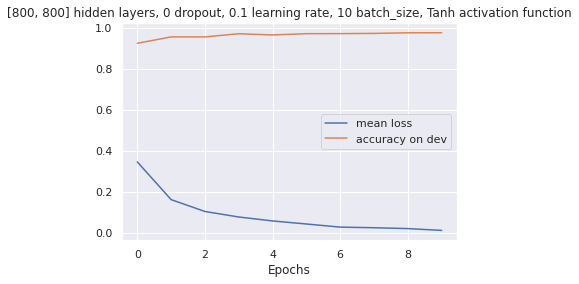

Starting epoch: 0
mean loss:  0.3609615802437721
dev accuracy:  0.9305
Starting epoch: 1
mean loss:  0.22878918173665297
dev accuracy:  0.9478
Starting epoch: 2
mean loss:  0.1744138117574765
dev accuracy:  0.9565
Starting epoch: 3
mean loss:  0.13859770026154622
dev accuracy:  0.9633
Starting epoch: 4
mean loss:  0.1135443405930451
dev accuracy:  0.9672
Starting epoch: 5
mean loss:  0.09497539788677901
dev accuracy:  0.9693
Starting epoch: 6
mean loss:  0.08066489238165572
dev accuracy:  0.971
Starting epoch: 7
mean loss:  0.06927361412758301
dev accuracy:  0.9728
Starting epoch: 8
mean loss:  0.05995628510057153
dev accuracy:  0.9737
Starting epoch: 9
mean loss:  0.05217911156374002
dev accuracy:  0.9752


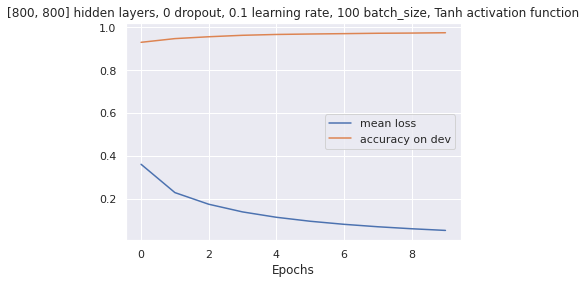

Starting epoch: 0
mean loss:  0.6515708559868383
dev accuracy:  0.9006
Starting epoch: 1
mean loss:  0.3672130148784787
dev accuracy:  0.9112
Starting epoch: 2
mean loss:  0.3228472044654921
dev accuracy:  0.9182
Starting epoch: 3
mean loss:  0.29857269280097065
dev accuracy:  0.9233
Starting epoch: 4
mean loss:  0.28167955986424986
dev accuracy:  0.9266
Starting epoch: 5
mean loss:  0.26842817693364385
dev accuracy:  0.9292
Starting epoch: 6
mean loss:  0.25726378636032926
dev accuracy:  0.9314
Starting epoch: 7
mean loss:  0.24741898038808038
dev accuracy:  0.9348
Starting epoch: 8
mean loss:  0.23847573002179465
dev accuracy:  0.9374
Starting epoch: 9
mean loss:  0.23019240182988784
dev accuracy:  0.9396


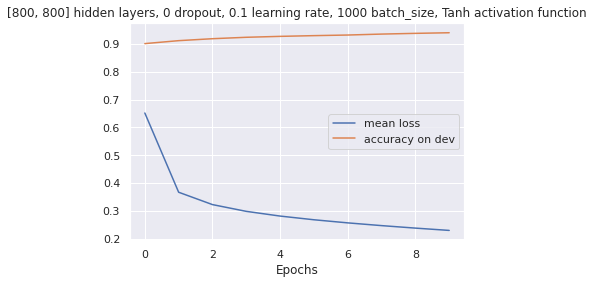

Starting epoch: 0
mean loss:  0.9329461133553804
dev accuracy:  0.9229
Starting epoch: 1
mean loss:  0.7536332945065941
dev accuracy:  0.9373
Starting epoch: 2
mean loss:  0.7132119118030915
dev accuracy:  0.9503
Starting epoch: 3
mean loss:  0.6870895688281573
dev accuracy:  0.9349
Starting epoch: 4
mean loss:  0.6505900270578884
dev accuracy:  0.9515
Starting epoch: 5
mean loss:  0.6196504339040444
dev accuracy:  0.9405
Starting epoch: 6
mean loss:  0.6140003259586388
dev accuracy:  0.9459
Starting epoch: 7
mean loss:  0.5921949757202282
dev accuracy:  0.9618
Starting epoch: 8
mean loss:  0.5933672383813987
dev accuracy:  0.9577
Starting epoch: 9
mean loss:  0.566357957964299
dev accuracy:  0.9621


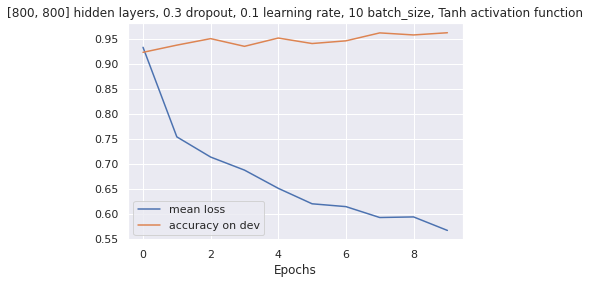

Starting epoch: 0
mean loss:  0.4234170506219426
dev accuracy:  0.9261
Starting epoch: 1
mean loss:  0.3039692574126754
dev accuracy:  0.9368
Starting epoch: 2
mean loss:  0.2614754184545157
dev accuracy:  0.9485
Starting epoch: 3
mean loss:  0.22537621675791616
dev accuracy:  0.9547
Starting epoch: 4
mean loss:  0.1995720393479822
dev accuracy:  0.9596
Starting epoch: 5
mean loss:  0.1796771566831542
dev accuracy:  0.9623
Starting epoch: 6
mean loss:  0.1642534277232702
dev accuracy:  0.9656
Starting epoch: 7
mean loss:  0.15102373517142562
dev accuracy:  0.9669
Starting epoch: 8
mean loss:  0.13928903392079228
dev accuracy:  0.9688
Starting epoch: 9
mean loss:  0.1296470520865477
dev accuracy:  0.9706


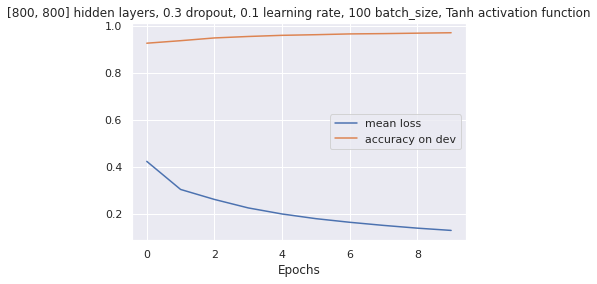

Starting epoch: 0
mean loss:  0.744541253529343
dev accuracy:  0.8977
Starting epoch: 1
mean loss:  0.4266226355936013
dev accuracy:  0.9091
Starting epoch: 2
mean loss:  0.3807099023286034
dev accuracy:  0.9147
Starting epoch: 3
mean loss:  0.3561617322996551
dev accuracy:  0.9192
Starting epoch: 4
mean loss:  0.34061518545244257
dev accuracy:  0.9223
Starting epoch: 5
mean loss:  0.32900672625092897
dev accuracy:  0.9236
Starting epoch: 6
mean loss:  0.31916015463716846
dev accuracy:  0.9261
Starting epoch: 7
mean loss:  0.30958839023814483
dev accuracy:  0.9277
Starting epoch: 8
mean loss:  0.3055361123646007
dev accuracy:  0.9289
Starting epoch: 9
mean loss:  0.29578329944143106
dev accuracy:  0.9301


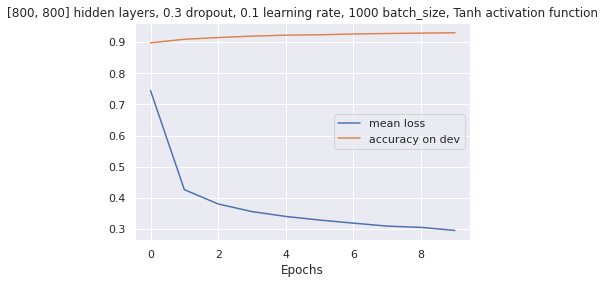

Starting epoch: 0
mean loss:  4.648409176737547
dev accuracy:  0.8505
Starting epoch: 1
mean loss:  4.962611897637803
dev accuracy:  0.8933
Starting epoch: 2
mean loss:  4.823405508455779
dev accuracy:  0.8256
Starting epoch: 3
mean loss:  4.711522051461574
dev accuracy:  0.8703
Starting epoch: 4
mean loss:  4.7202190267492155
dev accuracy:  0.8827
Starting epoch: 5
mean loss:  4.732392189933342
dev accuracy:  0.8905
Starting epoch: 6
mean loss:  4.434798011818611
dev accuracy:  0.9141
Starting epoch: 7
mean loss:  4.383230393996315
dev accuracy:  0.8878
Starting epoch: 8
mean loss:  4.179970498533953
dev accuracy:  0.8546
Starting epoch: 9
mean loss:  4.258365666251679
dev accuracy:  0.8965


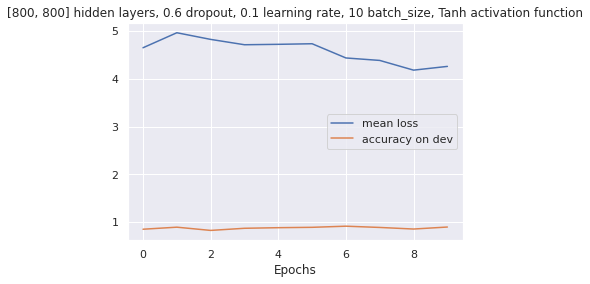

Starting epoch: 0
mean loss:  0.5573305818670524
dev accuracy:  0.9176
Starting epoch: 1
mean loss:  0.41181207976179446
dev accuracy:  0.9256
Starting epoch: 2
mean loss:  0.37533564197862457
dev accuracy:  0.9285
Starting epoch: 3
mean loss:  0.35239403334979763
dev accuracy:  0.9349
Starting epoch: 4
mean loss:  0.33547710967872907
dev accuracy:  0.9395
Starting epoch: 5
mean loss:  0.3156889363112088
dev accuracy:  0.9445
Starting epoch: 6
mean loss:  0.30300038931017625
dev accuracy:  0.9481
Starting epoch: 7
mean loss:  0.2884599228878459
dev accuracy:  0.9508
Starting epoch: 8
mean loss:  0.2775080274649247
dev accuracy:  0.9523
Starting epoch: 9
mean loss:  0.2632344443789737
dev accuracy:  0.9537


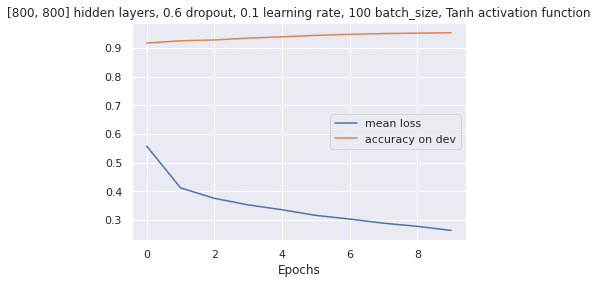

Starting epoch: 0
mean loss:  1.0310186474931007
dev accuracy:  0.8864
Starting epoch: 1
mean loss:  0.5601816580576056
dev accuracy:  0.9018
Starting epoch: 2
mean loss:  0.4891159516923568
dev accuracy:  0.9072
Starting epoch: 3
mean loss:  0.4575056877790713
dev accuracy:  0.9118
Starting epoch: 4
mean loss:  0.43731948207406435
dev accuracy:  0.9133
Starting epoch: 5
mean loss:  0.4197830014369067
dev accuracy:  0.9158
Starting epoch: 6
mean loss:  0.41434038678805035
dev accuracy:  0.9177
Starting epoch: 7
mean loss:  0.3986123496410893
dev accuracy:  0.9199
Starting epoch: 8
mean loss:  0.3904748249287699
dev accuracy:  0.9194
Starting epoch: 9
mean loss:  0.3800227969300513
dev accuracy:  0.9205


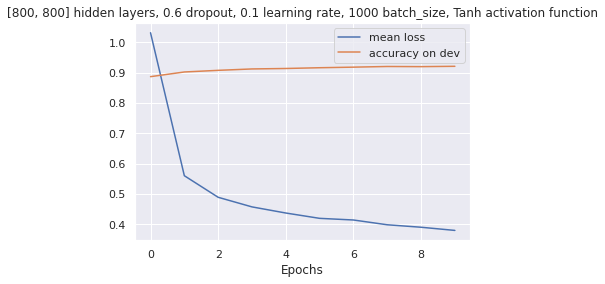

Starting epoch: 0
mean loss:  0.35084589691100787
dev accuracy:  0.9318
Starting epoch: 1
mean loss:  0.22361649976096493
dev accuracy:  0.9494
Starting epoch: 2
mean loss:  0.16936735180169352
dev accuracy:  0.9567
Starting epoch: 3
mean loss:  0.1342009001895828
dev accuracy:  0.9637
Starting epoch: 4
mean loss:  0.11003030477508075
dev accuracy:  0.9672
Starting epoch: 5
mean loss:  0.0923300780782577
dev accuracy:  0.9705
Starting epoch: 6
mean loss:  0.07874479871503025
dev accuracy:  0.9726
Starting epoch: 7
mean loss:  0.06791937246684637
dev accuracy:  0.9747
Starting epoch: 8
mean loss:  0.05903479282985649
dev accuracy:  0.9759
Starting epoch: 9
mean loss:  0.051579101299230254
dev accuracy:  0.9764


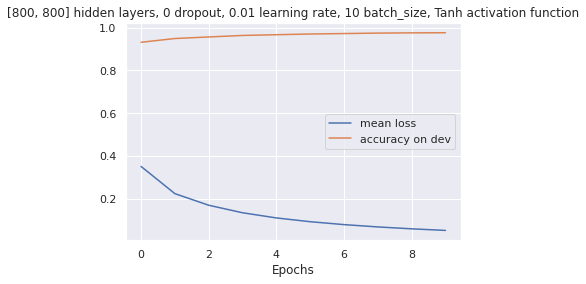

Starting epoch: 0
mean loss:  0.656143755612973
dev accuracy:  0.8991
Starting epoch: 1
mean loss:  0.37591191433266014
dev accuracy:  0.9108
Starting epoch: 2
mean loss:  0.33109560790295134
dev accuracy:  0.9189
Starting epoch: 3
mean loss:  0.30674809876256837
dev accuracy:  0.924
Starting epoch: 4
mean loss:  0.28975062610622415
dev accuracy:  0.9268
Starting epoch: 5
mean loss:  0.27633831837398565
dev accuracy:  0.9302
Starting epoch: 6
mean loss:  0.2649804449337209
dev accuracy:  0.9326
Starting epoch: 7
mean loss:  0.2549310884849278
dev accuracy:  0.9352
Starting epoch: 8
mean loss:  0.24578500927208427
dev accuracy:  0.9373
Starting epoch: 9
mean loss:  0.23730641673365516
dev accuracy:  0.9394


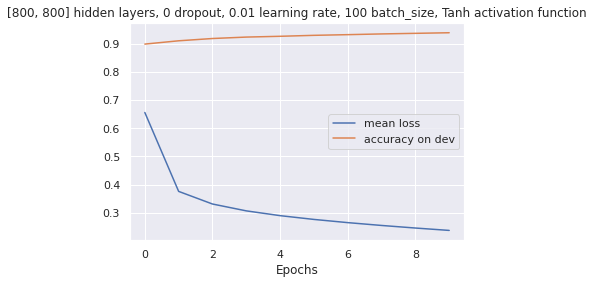

Starting epoch: 0
mean loss:  1.528885663724413
dev accuracy:  0.8014
Starting epoch: 1
mean loss:  0.8377797358176288
dev accuracy:  0.8542
Starting epoch: 2
mean loss:  0.6522318405263564
dev accuracy:  0.8714
Starting epoch: 3
mean loss:  0.5645060948297089
dev accuracy:  0.8806
Starting epoch: 4
mean loss:  0.5121147527414209
dev accuracy:  0.8877
Starting epoch: 5
mean loss:  0.47669925058589263
dev accuracy:  0.8909
Starting epoch: 6
mean loss:  0.4508376080615848
dev accuracy:  0.8946
Starting epoch: 7
mean loss:  0.4309280701712066
dev accuracy:  0.8982
Starting epoch: 8
mean loss:  0.4150005859487197
dev accuracy:  0.9009
Starting epoch: 9
mean loss:  0.40188172751781986
dev accuracy:  0.9021


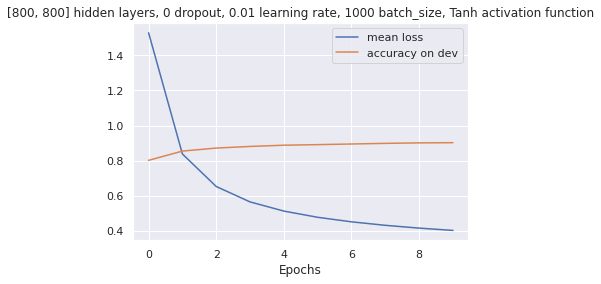

Starting epoch: 0
mean loss:  0.41535436591367003
dev accuracy:  0.927
Starting epoch: 1
mean loss:  0.30028374471184527
dev accuracy:  0.9403
Starting epoch: 2
mean loss:  0.2599261164820908
dev accuracy:  0.9489
Starting epoch: 3
mean loss:  0.2247375485077489
dev accuracy:  0.9567
Starting epoch: 4
mean loss:  0.19667163365357124
dev accuracy:  0.9613
Starting epoch: 5
mean loss:  0.1776544231236537
dev accuracy:  0.9636
Starting epoch: 6
mean loss:  0.16372456809967803
dev accuracy:  0.9663
Starting epoch: 7
mean loss:  0.14985017124880973
dev accuracy:  0.9676
Starting epoch: 8
mean loss:  0.1382562186608386
dev accuracy:  0.9706
Starting epoch: 9
mean loss:  0.12653613417625664
dev accuracy:  0.9726


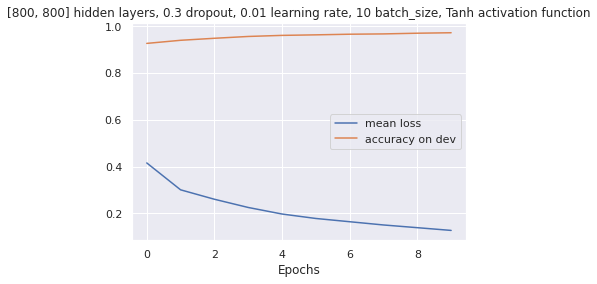

Starting epoch: 0
mean loss:  0.7501176087085358
dev accuracy:  0.8972
Starting epoch: 1
mean loss:  0.43216326413397305
dev accuracy:  0.9076
Starting epoch: 2
mean loss:  0.3845802855467844
dev accuracy:  0.915
Starting epoch: 3
mean loss:  0.35816993485548776
dev accuracy:  0.9192
Starting epoch: 4
mean loss:  0.3445870413216288
dev accuracy:  0.9228
Starting epoch: 5
mean loss:  0.3314653796826056
dev accuracy:  0.9249
Starting epoch: 6
mean loss:  0.3222261318962969
dev accuracy:  0.9258
Starting epoch: 7
mean loss:  0.31505629741503094
dev accuracy:  0.9276
Starting epoch: 8
mean loss:  0.30705484981367925
dev accuracy:  0.929
Starting epoch: 9
mean loss:  0.30125074491588893
dev accuracy:  0.9306


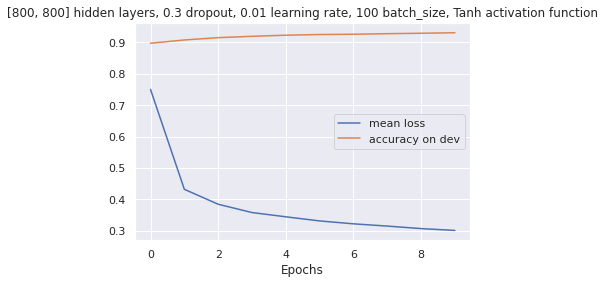

Starting epoch: 0
mean loss:  1.7177932823405546
dev accuracy:  0.7749
Starting epoch: 1
mean loss:  1.0072283102016824
dev accuracy:  0.8364
Starting epoch: 2
mean loss:  0.7848000421243555
dev accuracy:  0.8586
Starting epoch: 3
mean loss:  0.6773493663937438
dev accuracy:  0.8706
Starting epoch: 4
mean loss:  0.6164792787794974
dev accuracy:  0.8777
Starting epoch: 5
mean loss:  0.5692774817055347
dev accuracy:  0.8826
Starting epoch: 6
mean loss:  0.5389485657215118
dev accuracy:  0.8876
Starting epoch: 7
mean loss:  0.5149445054577846
dev accuracy:  0.8904
Starting epoch: 8
mean loss:  0.4930543846943799
dev accuracy:  0.893
Starting epoch: 9
mean loss:  0.4768262897052017
dev accuracy:  0.8957


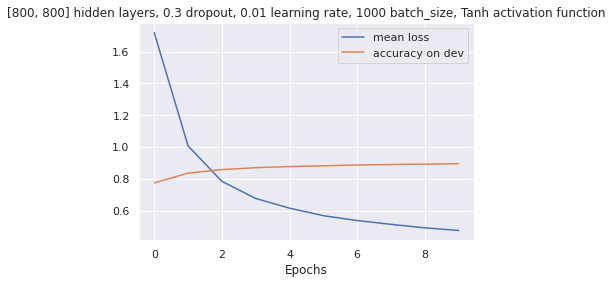

Starting epoch: 0
mean loss:  0.5599517715175634
dev accuracy:  0.9201
Starting epoch: 1
mean loss:  0.409120888761741
dev accuracy:  0.9234
Starting epoch: 2
mean loss:  0.37420582967850186
dev accuracy:  0.9303
Starting epoch: 3
mean loss:  0.3521006459277514
dev accuracy:  0.9365
Starting epoch: 4
mean loss:  0.3308056155742042
dev accuracy:  0.9403
Starting epoch: 5
mean loss:  0.3214717312160804
dev accuracy:  0.9438
Starting epoch: 6
mean loss:  0.30155863488569573
dev accuracy:  0.9463
Starting epoch: 7
mean loss:  0.2846699038167462
dev accuracy:  0.9492
Starting epoch: 8
mean loss:  0.2774961726964686
dev accuracy:  0.9523
Starting epoch: 9
mean loss:  0.2652128162629516
dev accuracy:  0.9543


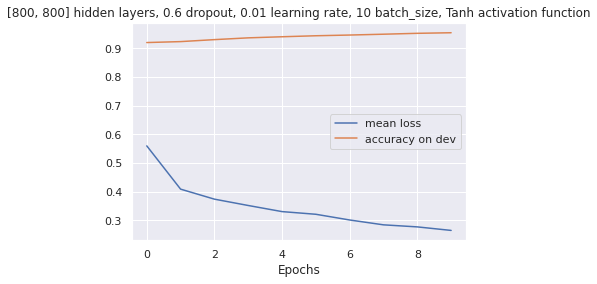

Starting epoch: 0
mean loss:  1.0212049472950653
dev accuracy:  0.8873
Starting epoch: 1
mean loss:  0.5742882204626849
dev accuracy:  0.9008
Starting epoch: 2
mean loss:  0.5018596848149499
dev accuracy:  0.9087
Starting epoch: 3
mean loss:  0.4657205276325077
dev accuracy:  0.913
Starting epoch: 4
mean loss:  0.4444828290425375
dev accuracy:  0.9161
Starting epoch: 5
mean loss:  0.42651711987283175
dev accuracy:  0.9178
Starting epoch: 6
mean loss:  0.41167508764657196
dev accuracy:  0.9201
Starting epoch: 7
mean loss:  0.4048562709859269
dev accuracy:  0.92
Starting epoch: 8
mean loss:  0.39473488394490736
dev accuracy:  0.9223
Starting epoch: 9
mean loss:  0.3855790043483951
dev accuracy:  0.9232


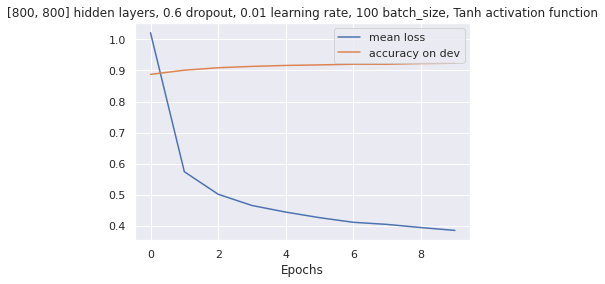

Starting epoch: 0
mean loss:  2.2378716842800963
dev accuracy:  0.7535
Starting epoch: 1
mean loss:  1.45488739714903
dev accuracy:  0.8312
Starting epoch: 2
mean loss:  1.1325685557197123
dev accuracy:  0.8525
Starting epoch: 3
mean loss:  0.9626876957276288
dev accuracy:  0.8622
Starting epoch: 4
mean loss:  0.8518285950024923
dev accuracy:  0.871
Starting epoch: 5
mean loss:  0.7830514685780394
dev accuracy:  0.8767
Starting epoch: 6
mean loss:  0.7336785349191404
dev accuracy:  0.8806
Starting epoch: 7
mean loss:  0.6998908157442131
dev accuracy:  0.8838
Starting epoch: 8
mean loss:  0.6633217381496056
dev accuracy:  0.8864
Starting epoch: 9
mean loss:  0.6396277710503223
dev accuracy:  0.8882


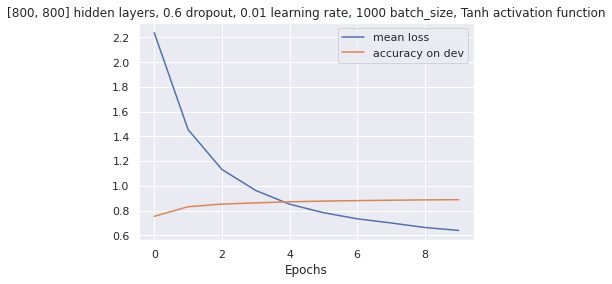

Starting epoch: 0
mean loss:  0.6599191023467768
dev accuracy:  0.9026
Starting epoch: 1
mean loss:  0.37726702401516937
dev accuracy:  0.9134
Starting epoch: 2
mean loss:  0.33139705575832756
dev accuracy:  0.9209
Starting epoch: 3
mean loss:  0.3063149145969902
dev accuracy:  0.9244
Starting epoch: 4
mean loss:  0.28883486321515156
dev accuracy:  0.9267
Starting epoch: 5
mean loss:  0.27508776993661155
dev accuracy:  0.9297
Starting epoch: 6
mean loss:  0.26347528157934136
dev accuracy:  0.9328
Starting epoch: 7
mean loss:  0.25321375524384576
dev accuracy:  0.9357
Starting epoch: 8
mean loss:  0.24387820581141081
dev accuracy:  0.9379
Starting epoch: 9
mean loss:  0.23522323654684107
dev accuracy:  0.9398


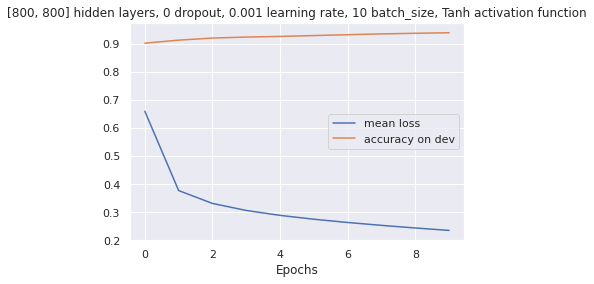

Starting epoch: 0
mean loss:  1.5062021381126907
dev accuracy:  0.7976
Starting epoch: 1
mean loss:  0.8695382641223138
dev accuracy:  0.8512
Starting epoch: 2
mean loss:  0.6815396630002591
dev accuracy:  0.8703
Starting epoch: 3
mean loss:  0.589868749092201
dev accuracy:  0.881
Starting epoch: 4
mean loss:  0.5343696214481742
dev accuracy:  0.8878
Starting epoch: 5
mean loss:  0.4965863794742706
dev accuracy:  0.8918
Starting epoch: 6
mean loss:  0.4688979296865102
dev accuracy:  0.8967
Starting epoch: 7
mean loss:  0.44755192901084045
dev accuracy:  0.8987
Starting epoch: 8
mean loss:  0.4304732274628447
dev accuracy:  0.9015
Starting epoch: 9
mean loss:  0.4164152530852906
dev accuracy:  0.903


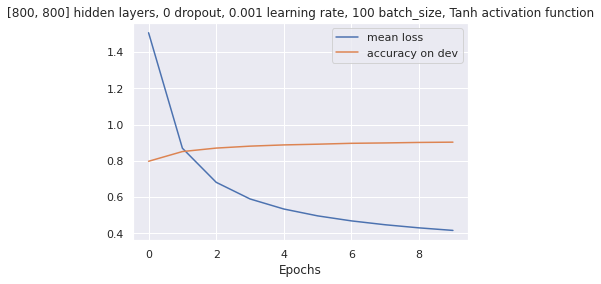

Starting epoch: 0
mean loss:  2.1506282628751268
dev accuracy:  0.3035
Starting epoch: 1
mean loss:  1.9054742911282707
dev accuracy:  0.4874
Starting epoch: 2
mean loss:  1.709135237862082
dev accuracy:  0.5903
Starting epoch: 3
mean loss:  1.5496855787202424
dev accuracy:  0.6512
Starting epoch: 4
mean loss:  1.4193862793492336
dev accuracy:  0.6966
Starting epoch: 5
mean loss:  1.3120697830237595
dev accuracy:  0.7244
Starting epoch: 6
mean loss:  1.2228260507770614
dev accuracy:  0.7477
Starting epoch: 7
mean loss:  1.1478326063530118
dev accuracy:  0.7686
Starting epoch: 8
mean loss:  1.08414967621074
dev accuracy:  0.7812
Starting epoch: 9
mean loss:  1.029522741542143
dev accuracy:  0.7938


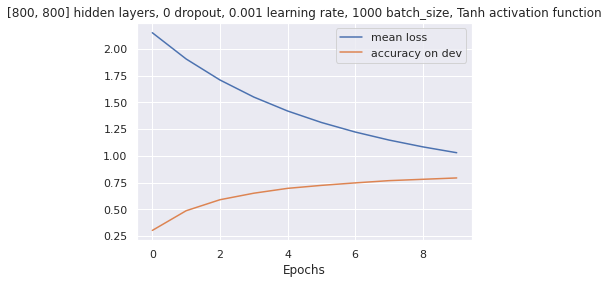

Starting epoch: 0
mean loss:  0.7770443369448781
dev accuracy:  0.8979
Starting epoch: 1
mean loss:  0.438957236707583
dev accuracy:  0.9095
Starting epoch: 2
mean loss:  0.3882903760567999
dev accuracy:  0.9155
Starting epoch: 3
mean loss:  0.36100612430956375
dev accuracy:  0.9197
Starting epoch: 4
mean loss:  0.34710404931660166
dev accuracy:  0.9216
Starting epoch: 5
mean loss:  0.33217016943067257
dev accuracy:  0.9238
Starting epoch: 6
mean loss:  0.3225498137892431
dev accuracy:  0.9257
Starting epoch: 7
mean loss:  0.3139766472961826
dev accuracy:  0.9278
Starting epoch: 8
mean loss:  0.30731088110385246
dev accuracy:  0.928
Starting epoch: 9
mean loss:  0.30391815249428045
dev accuracy:  0.9303


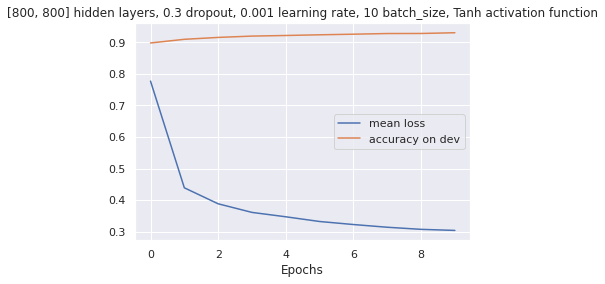

Starting epoch: 0
mean loss:  1.7911454710417878
dev accuracy:  0.7712
Starting epoch: 1
mean loss:  1.0586813583583412
dev accuracy:  0.8393
Starting epoch: 2
mean loss:  0.824247384856561
dev accuracy:  0.8616
Starting epoch: 3
mean loss:  0.7092141651821707
dev accuracy:  0.8733
Starting epoch: 4
mean loss:  0.6394967559330954
dev accuracy:  0.8789
Starting epoch: 5
mean loss:  0.5921274489033483
dev accuracy:  0.8854
Starting epoch: 6
mean loss:  0.5553736473152975
dev accuracy:  0.8905
Starting epoch: 7
mean loss:  0.5304143606069797
dev accuracy:  0.8925
Starting epoch: 8
mean loss:  0.5105754310142494
dev accuracy:  0.8951
Starting epoch: 9
mean loss:  0.4920833801437995
dev accuracy:  0.8972


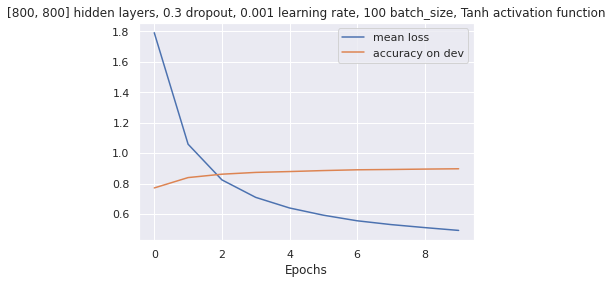

Starting epoch: 0
mean loss:  2.5778054443060183
dev accuracy:  0.1592
Starting epoch: 1
mean loss:  2.2998335080988266
dev accuracy:  0.3139
Starting epoch: 2
mean loss:  2.0863721978430654
dev accuracy:  0.4654
Starting epoch: 3
mean loss:  1.9176419926624673
dev accuracy:  0.5592
Starting epoch: 4
mean loss:  1.7657081145866245
dev accuracy:  0.6227
Starting epoch: 5
mean loss:  1.6396833821838976
dev accuracy:  0.6684
Starting epoch: 6
mean loss:  1.5351610043469597
dev accuracy:  0.701
Starting epoch: 7
mean loss:  1.4420522264405793
dev accuracy:  0.7295
Starting epoch: 8
mean loss:  1.3628165137534047
dev accuracy:  0.7494
Starting epoch: 9
mean loss:  1.2901643351012586
dev accuracy:  0.7673


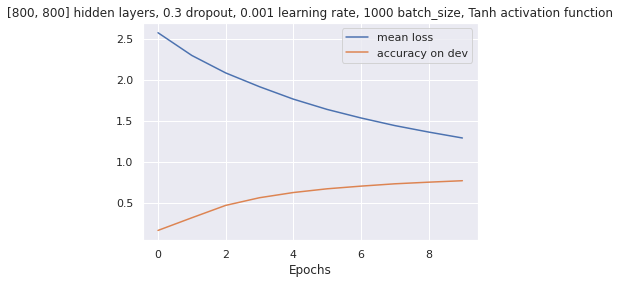

Starting epoch: 0
mean loss:  1.0360593739677264
dev accuracy:  0.887
Starting epoch: 1
mean loss:  0.5733209890867472
dev accuracy:  0.9003
Starting epoch: 2
mean loss:  0.50314137323055
dev accuracy:  0.9064
Starting epoch: 3
mean loss:  0.47115988960279936
dev accuracy:  0.9105
Starting epoch: 4
mean loss:  0.44308108783654243
dev accuracy:  0.9136
Starting epoch: 5
mean loss:  0.42467958298045305
dev accuracy:  0.9154
Starting epoch: 6
mean loss:  0.4171336579396896
dev accuracy:  0.917
Starting epoch: 7
mean loss:  0.40221728813450675
dev accuracy:  0.9185
Starting epoch: 8
mean loss:  0.39872844499036586
dev accuracy:  0.9206
Starting epoch: 9
mean loss:  0.39055347812157726
dev accuracy:  0.9206


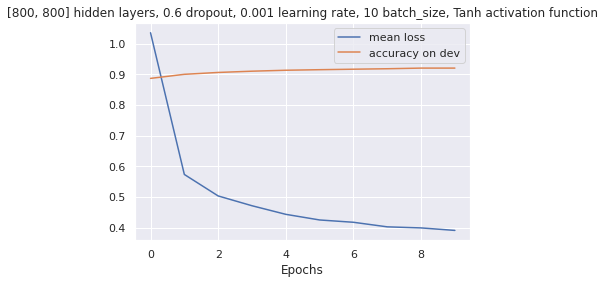

Starting epoch: 0
mean loss:  2.2757511138916016
dev accuracy:  0.7556
Starting epoch: 1
mean loss:  1.5029399547272337
dev accuracy:  0.8228
Starting epoch: 2
mean loss:  1.1707340006580849
dev accuracy:  0.8473
Starting epoch: 3
mean loss:  0.9875812033217348
dev accuracy:  0.8594
Starting epoch: 4
mean loss:  0.8816803378497293
dev accuracy:  0.871
Starting epoch: 5
mean loss:  0.8109720503974579
dev accuracy:  0.8774
Starting epoch: 6
mean loss:  0.7556582611359046
dev accuracy:  0.8819
Starting epoch: 7
mean loss:  0.7114720688965506
dev accuracy:  0.8854
Starting epoch: 8
mean loss:  0.6831450960236395
dev accuracy:  0.888
Starting epoch: 9
mean loss:  0.6528736169704658
dev accuracy:  0.8922


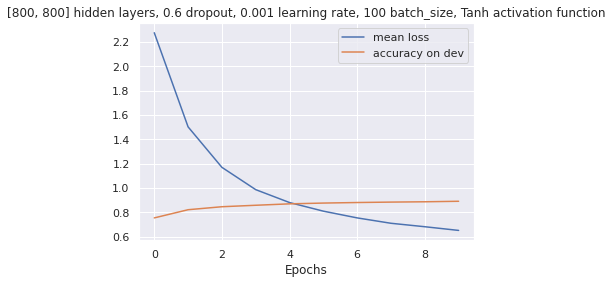

Starting epoch: 0
mean loss:  2.8191466378230676
dev accuracy:  0.1986
Starting epoch: 1
mean loss:  2.64208732399286
dev accuracy:  0.3729
Starting epoch: 2
mean loss:  2.474384677176382
dev accuracy:  0.4827
Starting epoch: 3
mean loss:  2.346059144711962
dev accuracy:  0.5573
Starting epoch: 4
mean loss:  2.2108932710161397
dev accuracy:  0.6098
Starting epoch: 5
mean loss:  2.093070235906863
dev accuracy:  0.6489
Starting epoch: 6
mean loss:  1.9928793463052488
dev accuracy:  0.6799
Starting epoch: 7
mean loss:  1.9007435803319894
dev accuracy:  0.7054
Starting epoch: 8
mean loss:  1.8149899781918992
dev accuracy:  0.7239
Starting epoch: 9
mean loss:  1.7338576223336013
dev accuracy:  0.74


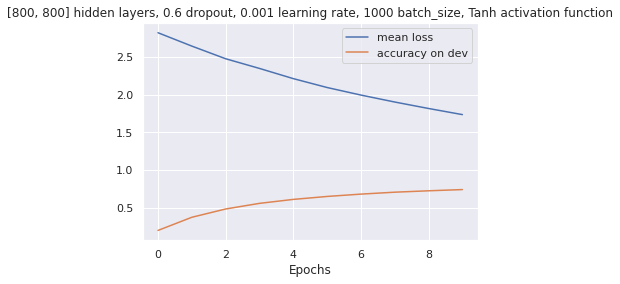

In [0]:
layer_dims_testing = [[800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.3, 0.6]
learning_rates = [0.1, 0.01, 0.001]
models_list_TanhMLP = []
mean_loss_list_TanhMLP = []
dev_accuracy_list_TanhMLP = []

EPOCHS = 10
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = TanhMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list_TanhMLP.append(model)
                mean_loss_list_TanhMLP.append(mean_losses)
                dev_accuracy_list_TanhMLP.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "Tanh")